## Telecom Churn Prediction Case Study

## Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [4]:
sns.set_style('whitegrid')

In [5]:
pd.set_option('max_columns', 300)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, log_loss, r2_score
from yellowbrick.classifier import ROCAUC
from sklearn import tree

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [8]:
from tqdm import tqdm

## Data Import

In [9]:
churn_df = pd.read_csv('telecom_churn_data.csv')

In [50]:
churn_df.head(10)

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   
5     7000286308        109             0.0             0.0             0.0   
6     7001051193        109             0.0             0.0             0.0   
7     7000701601        109             0.0             0.0             0.0   
8     7001524846        109             0.0             0.0             0.0   
9     7001864400        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   
5            6/30/2014            7/31/2014            8/31/2014   
6            6/30/2014            7/31/2014            8/31/2014   
7            6/30/2014            7/31/2014            8/31/2014   
8            6/30/2014            7/31/2014            8/31/2014   
9            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9    arpu_6    arpu_7    arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014   197.385   214.816   213.803   21.100          NaN   
1            9/30/2014    34.047   355.074   268.321   86.285        24.11   
2            9/30/2014   167.690   189.058   210.226  290.714        11.54   
3            9/30/2014   221.338   251.102   508.054  389.500        99.91   
4            9/30/2014   261.636   309.876   238.174  163.426        50.31   
5            9/30/2014    50.258    58.810    83.386  170.826        50.16   
6            9/30/2014   429.023   190.704   255.114  114.751        71.03   
7            9/30/2014  1069.180  1349.850  3171.480  500.000        57.84   
8            9/30/2014   378.721   492.223   137.362  166.787       413.69   
9            9/30/2014   119.518   247.435   170.231  160.042        33.89   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   
5        43.63        85.48       138.79         19.28         13.44   
6        45.03        76.66        15.23        262.73         49.24   
7        54.68        52.29          NaN        453.43        567.16   
8       351.03        35.08        33.46         94.66         80.63   
9        30.11        22.43        27.84         63.48         54.16   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76           0.00           0.00           0.00   
2        208.36        118.91           0.00           0.00           0.00   
3         71.68        113.54           0.00          54.86          44.38   
4        124.26         45.81           0.00           0.00           0.00   
5         14.46         46.91           0.00           0.00           0.00   
6         92.08         50.33           0.00           0.00           0.00   
7        325.91           NaN          16.23          33.49          31.64   
8        136.48        108.71 

## Inspecting the DataFrame

In [11]:
churn_df.shape

(99999, 226)

In [12]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [13]:
churn_df.describe()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.999900e+04    99999.0         98981.0         98981.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.956694e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001205e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count         98981.0  99999.000000  99999.000000  99999.000000  99999.000000   
mean              0.0    282.987358    278.536648    279.154731    261.645069   
std               0.0    328.439770    338.156291    344.474791    341.998630   
min               0.0  -2258.709000  -2014.045000   -945.808000  -1899.505000   
25%               0.0     93.411500     86.980500     84.126000     62.685000   
50%               0.0    197.704000    191.640000    192.080000    176.849000   
75%               0.0    371.060000    365.344500    369.370500    353.466500   
max               0.0  27731.088000  35145.834000  33543.624000  38805.617000   

        onnet_mou_6   onnet_mou_7   onnet_mou_8   onnet_mou_9  offnet_mou_6  \
count  96062.000000  96140.000000  94621.000000  92254.000000  96062.000000   
mean     132.395875    133.670805    133.018098    130.302327    197.935577   
std      297.207406    308.794148    308.951589    308.477668    316.851613   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        7.380000      6.660000      6.460000      5.330000     34.730000   
50%       34.310000     32.330000     32.360000     29.840000     96.310000   
75%      118.740000    115.595000    115.860000    112.130000    231.860000   
max     7376.710000   8157.780000  10752.560000  10427.460000   8362.360000   

       offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  \
count  96140.000000  94621.000000  92254.000000   96062.000000   96140.000000   
mean     197.045133    196.574803    190.337222       9.950013       7.149898   
std      325.862803    327.170662    319.396092      72.825411      73.447948   
min        0.000000      0.000000      0.000000       0.000000       0.000000   
25%       32.190000     31.630000     27.130000       0.000000       0.000000   
50%       91.735000     92.140000     87.290000       0.000000       0.000000   
75%      226.815000    228.260000    220.505000       0.000000       0.000000   
max     9667.130000  14007.340000  10310.760000   13724.380000   15371.040000   

       roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  \
count   94621.000000   92254.000000   96062.000000   96140.000000   
mean        7.292981       6.343841      13.911337       9.818732   
std        68.402466      57.137537      71.443196      58.455762   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max     13095.360000    8464.030000    3775.110000    2812.040000   

       roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   94621.000000   92254.000000      96062.000000      96140.000000   
mean        9.971890       8.555519         47.100763         46.473010   
std        64.713221      58.438186        150.856393        155.318705   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.660000          1.630000   
50%         0.000000       0.000000         11.910000         11.610000   
75%         0.000000       0.000000         40.960000         39.910000   
max      

- Most of columns have numerical data types
- 12 categorical date columns present 

## Missing Data Report

In [14]:
def get_missing_report(df):
    missing_df = (df.isnull().sum()/len(df)).rename_axis('columns').to_frame('missing_perc').reset_index()
    missing_df['missing_perc'] = missing_df['missing_perc'] * 100
    missing_df['type'] = missing_df['columns'].apply(lambda col: str(df[col].dtypes))
    return missing_df.sort_values(by = 'missing_perc', ascending=False)

In [15]:
missing_data = get_missing_report(churn_df)

In [16]:
missing_data

columns  missing_perc     type
189          arpu_3g_6     74.846748  float64
197   night_pck_user_6     74.846748  float64
161  total_rech_data_6     74.846748  float64
193          arpu_2g_6     74.846748  float64
165    max_rech_data_6     74.846748  float64
..                 ...           ...      ...
146     max_rech_amt_7      0.000000    int64
145     max_rech_amt_6      0.000000    int64
144   total_rech_amt_9      0.000000    int64
143   total_rech_amt_8      0.000000    int64
225         sep_vbc_3g      0.000000  float64

[226 rows x 3 columns]

In [17]:
print('Number of columns containing missing values: %d' %len(missing_data[missing_data['missing_perc'] > 0]))

Number of columns containing missing values: 166


## Data Cleaning

In [18]:
# features having more than 50% missing values
missing_data[missing_data['missing_perc'] >= 50]

columns  missing_perc     type
189                 arpu_3g_6     74.846748  float64
197          night_pck_user_6     74.846748  float64
161         total_rech_data_6     74.846748  float64
193                 arpu_2g_6     74.846748  float64
165           max_rech_data_6     74.846748  float64
217                 fb_user_6     74.846748  float64
177        av_rech_amt_data_6     74.846748  float64
157  date_of_last_rech_data_6     74.846748   object
169           count_rech_2g_6     74.846748  float64
173           count_rech_3g_6     74.846748  float64
158  date_of_last_rech_data_7     74.428744   object
162         total_rech_data_7     74.428744  float64
218                 fb_user_7     74.428744  float64
166           max_rech_data_7     74.428744  float64
198          night_pck_user_7     74.428744  float64
170           count_rech_2g_7     74.428744  float64
178        av_rech_amt_data_7     74.428744  float64
194                 arpu_2g_7     74.428744  float64
174           count_rech_3g_7     74.428744  float64
190                 arpu_3g_7     74.428744  float64
164         total_rech_data_9     74.077741  float64
176           count_rech_3g_9     74.077741  float64
220                 fb_user_9     74.077741  float64
168           max_rech_data_9     74.077741  float64
192                 arpu_3g_9     74.077741  float64
160  date_of_last_rech_data_9     74.077741   object
200          night_pck_user_9     74.077741  float64
196                 arpu_2g_9     74.077741  float64
172           count_rech_2g_9     74.077741  float64
180        av_rech_amt_data_9     74.077741  float64
163         total_rech_data_8     73.660737  float64
191                 arpu_3g_8     73.660737  float64
219                 fb_user_8     73.660737  float64
199          night_pck_user_8     73.660737  float64
179        av_rech_amt_data_8     73.660737  float64
167           max_rech_data_8     73.660737  float64
175           count_rech_3g_8     73.660737  float64
195                 arpu_2g_8     73.660737  float64
171           count_rech_2g_8     73.660737  float64
159  date_of_last_rech_data_8     73.660737   object

Churn Indicators -

- Monthly Usage going down

- Monthly revenue correlated with monthly usage

- customer making too many calls to call centre

- too many call drops

- Customer travells a lot to different places and using another service as primary SIM

In [19]:
columns = list(churn_df.columns)
columns

['mobile_number',
 'circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_9',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'onnet_mou_9',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'offnet_mou_9',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_ic_mou_9',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'roam_og_mou_9',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2c_mou_9',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_og_mou_9',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2t_mou_9',
 's

In [20]:
churn_df['circle_id'].unique()

array([109], dtype=int64)

There is only one circle which means data consists of only one geographic area.

### Finding high value customers

#### Filter High Value Customers
#### Define high-value customers as follows:
- Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
- There are lot of missing values for the Data and the Amt_Data Columns indicating that no recharge was done on that month
- The NaN values should be replaced by 0

Recharge amount for voice and data usage

In [21]:
churn_df[['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9']].isnull().sum()

total_rech_amt_6    0
total_rech_amt_7    0
total_rech_amt_8    0
total_rech_amt_9    0
dtype: int64

In [22]:
churn_df[['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9']].isnull().sum()

total_rech_data_6    74846
total_rech_data_7    74428
total_rech_data_8    73660
total_rech_data_9    74077
dtype: int64

In [23]:
# NULL recharge amount in a month implies that there hasn't been any recharge during that month
# Better to replace them 0 value
churn_df.total_rech_data_6.fillna(value=0, inplace=True)
churn_df.total_rech_data_7.fillna(value=0, inplace=True)
churn_df.total_rech_data_8.fillna(value=0, inplace=True)
churn_df.total_rech_data_9.fillna(value=0, inplace=True)
churn_df.av_rech_amt_data_6.fillna(value=0, inplace=True)
churn_df.av_rech_amt_data_7.fillna(value=0, inplace=True)
churn_df.av_rech_amt_data_8.fillna(value=0, inplace=True)
churn_df.av_rech_amt_data_9.fillna(value=0, inplace=True)

In [24]:
#Total recharge amounts for months 6 and 7 i.e good phase
#Total recharge amount logic = Total data recharge + Total recharge Amount. 
#if any of the data recharge columns are 0 then retain the total recharge amt column as is

churn_df['total_rech_amt_6'] = np.where((churn_df['total_rech_data_6'] != 0) & (churn_df['av_rech_amt_data_6'] != 0),
                                            churn_df['total_rech_data_6']*churn_df['av_rech_amt_data_6']+churn_df['total_rech_amt_6'],
                                            churn_df['total_rech_amt_6'])

churn_df['total_rech_amt_7'] = np.where((churn_df['total_rech_data_7'] != 0) & (churn_df['av_rech_amt_data_7'] != 0),
                                            churn_df['total_rech_data_7']*churn_df['av_rech_amt_data_7']+churn_df['total_rech_amt_7'],
                                            churn_df['total_rech_amt_7'])

In [25]:
# Filter high-value customers
churn_df['avg_recharge_amount'] = (churn_df['total_rech_amt_6'] + churn_df['total_rech_amt_7']) / 2.0

In [26]:
churn_df['avg_recharge_amount'].describe(percentiles=[0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99])

count    99999.000000
mean       485.328068
std        869.423594
min          0.000000
50%        275.000000
70%        478.000000
75%        553.000000
80%        656.500000
85%        800.000000
90%       1028.000000
95%       1512.000000
99%       3363.510000
max      61236.000000
Name: avg_recharge_amount, dtype: float64

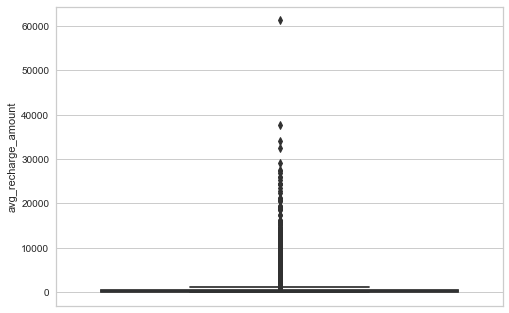

In [27]:
sns.boxplot(y=churn_df['avg_recharge_amount'])

In [28]:
# high value customer threshold value - 70th Percentile of the 1st 2 months

hvc_threshold_val = churn_df.avg_recharge_amount.quantile(.70)
print('70 percentile of first two months avg recharge amount: ', hvc_threshold_val)

70 percentile of first two months avg recharge amount:  478.0


In [29]:
#creating a dataframe for high value customers
high_value_df = churn_df[churn_df['avg_recharge_amount'] >= hvc_threshold_val]

In [30]:
print('There are %d high value customers.' %len(high_value_df))

There are 30001 high value customers.


In [31]:
tagged_churn_df = high_value_df.copy()

In [32]:
tagged_churn_df

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
0         7000842753        109             0.0             0.0   
7         7000701601        109             0.0             0.0   
8         7001524846        109             0.0             0.0   
21        7002124215        109             0.0             0.0   
23        7000887461        109             0.0             0.0   
...              ...        ...             ...             ...   
99981     7000630859        109             0.0             0.0   
99984     7000661676        109             0.0             0.0   
99986     7001729035        109             0.0             0.0   
99988     7002111859        109             0.0             0.0   
99997     7000498689        109             0.0             0.0   

       loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7  \
0                 0.0            6/30/2014            7/31/2014   
7                 0.0            6/30/2014            7/31/2014   
8                 0.0            6/30/2014            7/31/2014   
21                0.0            6/30/2014            7/31/2014   
23                0.0            6/30/2014            7/31/2014   
...               ...                  ...                  ...   
99981             0.0            6/30/2014            7/31/2014   
99984             0.0            6/30/2014            7/31/2014   
99986             0.0            6/30/2014            7/31/2014   
99988             0.0            6/30/2014            7/31/2014   
99997             0.0            6/30/2014            7/31/2014   

      last_date_of_month_8 last_date_of_month_9    arpu_6    arpu_7    arpu_8  \
0                8/31/2014            9/30/2014   197.385   214.816   213.803   
7                8/31/2014            9/30/2014  1069.180  1349.850  3171.480   
8                8/31/2014            9/30/2014   378.721   492.223   137.362   
21               8/31/2014            9/30/2014   514.453   597.753   637.760   
23               8/31/2014            9/30/2014    74.350   193.897   366.966   
...                    ...                  ...       ...       ...       ...   
99981            8/31/2014            9/30/2014   384.316   255.405   393.474   
99984            8/31/2014            9/30/2014   328.594   202.966   118.707   
99986            8/31/2014            9/30/2014   644.973   455.228   564.334   
99988            8/31/2014            9/30/2014   312.558   512.932   402.080   
99997            8/31/2014            9/30/2014   322.991   303.386   606.817   

        arpu_9  onnet_mou_6  onnet_mou_7  onnet_mou_8  onnet_mou_9  \
0       21.100          NaN          NaN         0.00          NaN   
7      500.000        57.84        54.68        52.29          NaN   
8      166.787       413.69       351.03        35.08        33.46   
21     578.596       102.41       132.11        85.14       161.63   
23     811.480        48.96        50.66        33.58        15.74   
...        ...          ...          ...          ...          ...   
99981   94.080        78.68        29.04       103.24        34.38   
99984  324.143       423.99       181.83         5.71         5.03   
99986  267.451       806.73       549.36       775.41       692.63   
99988  533.502       199.89       174.46         2.46         7.16   
99997  731.010         0.00         0.00         0.00         0.00   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  \
0               NaN           NaN          0.00           NaN            NaN   
7            453.43        567.16        325.91           NaN          16.23   
8             94.66         80.63        136.48        108.71           0.00   
21           757.93        896.68        983.39        869.89           0.00   
23            85.41         89.36        205.89        111.88           0.00   
...             ...           ...           ...           ...            ...   
99981         56.13    

In [33]:
def tag_churn(incoming, outgoing, vol_2g, vol_3g):
    # tag as churn for customers with no usage
    if incoming<=0 and outgoing<=0 and vol_2g<=0 and vol_3g<=0:
        return 1
    else:
        return 0

In [34]:
tagged_churn_df['churn'] = tagged_churn_df[['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']].apply(lambda x: tag_churn(x['total_ic_mou_9'], x['total_og_mou_9'], x['vol_2g_mb_9'], x['vol_3g_mb_9']), axis=1)

In [35]:
tagged_churn_df.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0      7000842753        109             0.0             0.0             0.0   
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
21     7002124215        109             0.0             0.0             0.0   
23     7000887461        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0             6/30/2014            7/31/2014            8/31/2014   
7             6/30/2014            7/31/2014            8/31/2014   
8             6/30/2014            7/31/2014            8/31/2014   
21            6/30/2014            7/31/2014            8/31/2014   
23            6/30/2014            7/31/2014            8/31/2014   

   last_date_of_month_9    arpu_6    arpu_7    arpu_8   arpu_9  onnet_mou_6  \
0             9/30/2014   197.385   214.816   213.803   21.100          NaN   
7             9/30/2014  1069.180  1349.850  3171.480  500.000        57.84   
8             9/30/2014   378.721   492.223   137.362  166.787       413.69   
21            9/30/2014   514.453   597.753   637.760  578.596       102.41   
23            9/30/2014    74.350   193.897   366.966  811.480        48.96   

    onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0           NaN         0.00          NaN           NaN           NaN   
7         54.68        52.29          NaN        453.43        567.16   
8        351.03        35.08        33.46         94.66         80.63   
21       132.11        85.14       161.63        757.93        896.68   
23        50.66        33.58        15.74         85.41         89.36   

    offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0           0.00           NaN            NaN            NaN           0.00   
7         325.91           NaN          16.23          33.49          31.64   
8         136.48        108.71           0.00           0.00           0.00   
21        983.39        869.89           0.00           0.00           0.00   
23        205.89        111.88           0.00           0.00           0.00   

    roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0             NaN            NaN            NaN           0.00            NaN   
7             NaN          23.74          12.59          38.06            NaN   
8             0.0           0.00           0.00           0.00            0.0   
21            0.0           0.00           0.00           0.00            0.0   
23            0.0           0.00           0.00           0.00            0.0   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0                NaN               NaN              0.00               NaN   
7              51.39             31.38             40.28               NaN   
8             297.13            217.59             12.49             26.13   
21              4.48              6.16             23.34             29.98   
23             48.96             50.66             33.58             15.74   

    loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0                NaN               NaN              0.00               NaN   
7             308.63            447.38            162.28               NaN   
8              80.96             70.58             50.54             34.58   
21             91.81             87.93            104.81            107.54   
23             82.94             83.01            148.56             83.73   

    loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0                NaN               NaN              0.00               NaN   
7              62.13             55.14             53.23               NaN   
8               0.00              0.00              0.00    

In [36]:
tagged_churn_df['churn'].value_counts(normalize=True)

0    0.918636
1    0.081364
Name: churn, dtype: float64

High Class Imbalance

In [37]:
tagged_churn_df['churn'].value_counts()

0    27560
1     2441
Name: churn, dtype: int64

In [38]:
all_columns = tagged_churn_df.columns
all_columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'fb_user_7', 'fb_user_8', 'fb_user_9', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g', 'avg_recharge_amount',
       'churn'],
      dtype='object', length=228)

### Dropping all attributes corresponding to churn phase

In [39]:
# list of all churn phase features
churn_phase_attributes = []
for col in all_columns:
    col_entities = col.split('_')
    if '9' in col_entities:
        churn_phase_attributes.append(col)

churn_phase_attributes

['last_date_of_month_9',
 'arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'date_of_last_rech_9',
 'last_day_rch_amt_9',
 'date_of_last_rech_data_9',
 'total_rech_data_9',
 'max_rech_data_9',
 'count_rech_2g_9',
 'count_rech_3g_9',
 'av_rech_amt_data_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'arpu_3g_9',
 'arpu_2g_9',
 'night_pck_user_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 

In [40]:
tagged_churn_df.shape

(30001, 228)

In [41]:
tagged_churn_df.drop(churn_phase_attributes, axis=1, inplace=True)

In [42]:
tagged_churn_df.shape

(30001, 174)

- 174 Features left

In [43]:
tagged_churn_df.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'arpu_6', 'arpu_7',
       ...
       'fb_user_6', 'fb_user_7', 'fb_user_8', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g', 'avg_recharge_amount',
       'churn'],
      dtype='object', length=174)

## Exploratory Data Analysis

### Incoming Minutes Over call vs Churn by Month

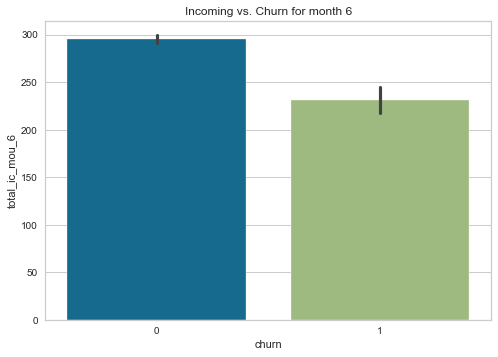

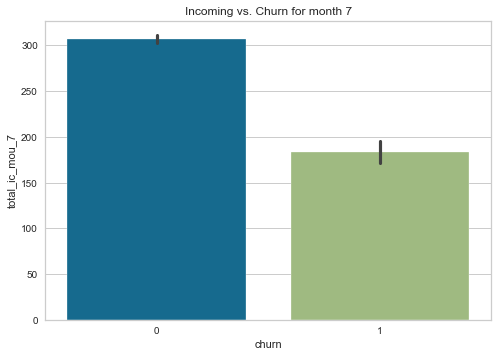

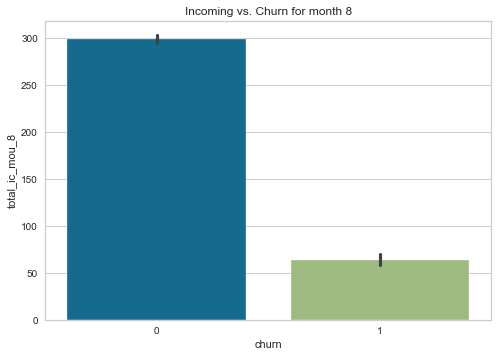

In [52]:
for month in [6,7,8]:
    plt.title('Incoming vs. Churn for month %d' %month)
    sns.barplot(x='churn', y='total_ic_mou_'+str(month), data=tagged_churn_df)
    plt.show()

- Here we see a decreasing trend of Incoming Minutes Over Calls for Churned users.With a striking drop from ~180 minutes to ~60 minutes going from Month 7 to Month 8 (Good to Active Phase)

### Outgoing Minutes Over call vs Churn by Month

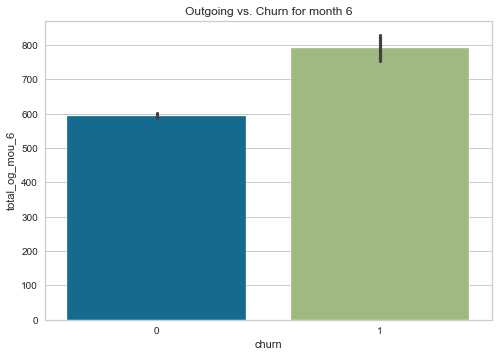

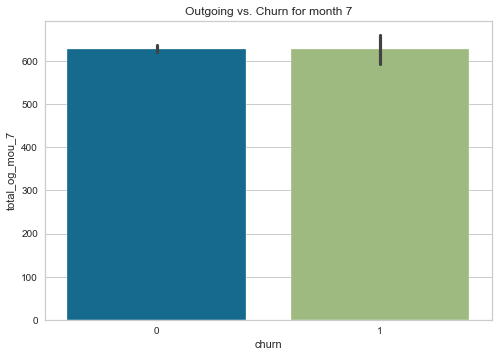

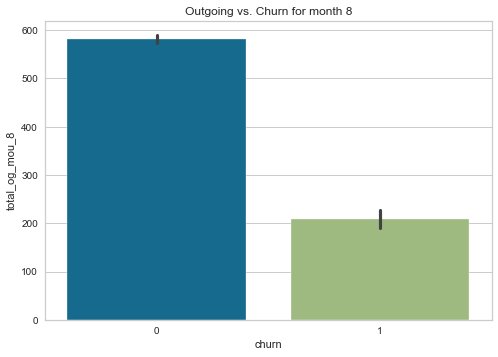

In [54]:
for month in [6,7,8]:
    plt.title('Outgoing vs. Churn for month %d' %month)
    sns.barplot(x='churn', y='total_og_mou_'+str(month), data=tagged_churn_df)
    plt.show()

- Similar trend has been observed for Outgoing Minutes over call with a decrease from ~600 minutes to ~200 minutes going from 7 to 8

### Average Revenue Per User (ARPU) vs Churn by Month

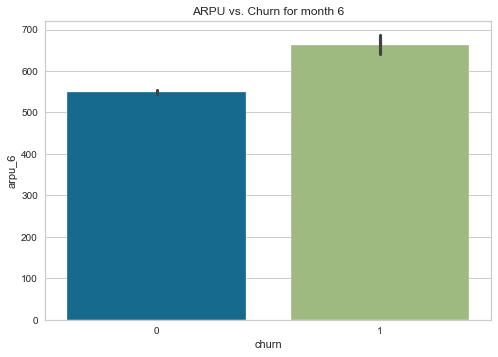

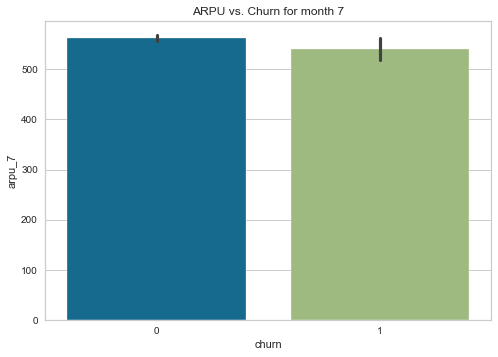

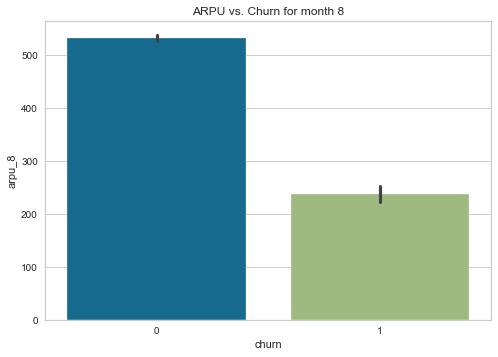

In [46]:
for month in [6,7,8]:
    plt.title('ARPU vs. Churn for month %d' %month)
    sns.barplot(x='churn', y='arpu_'+str(month), data=tagged_churn_df)
    plt.show()

- The Average Revenue per user metric Drop in month 8 indicates Churn

### Recharge Amount vs Churn by Month

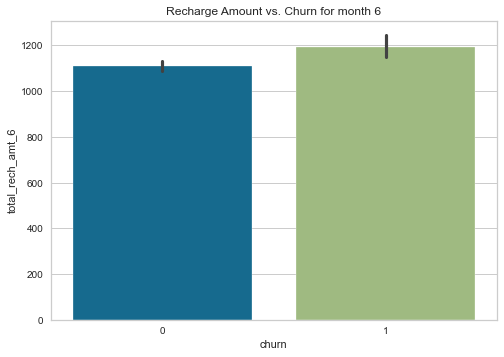

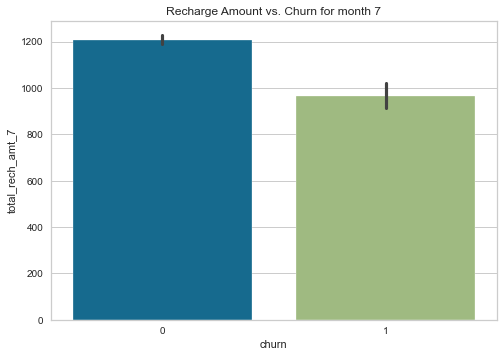

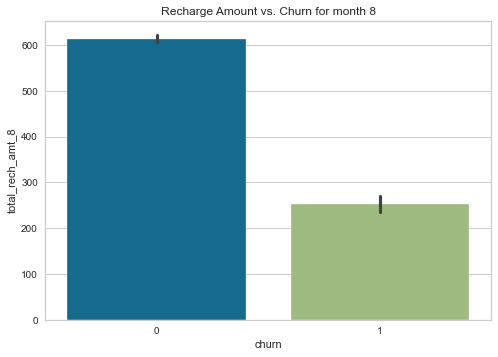

In [47]:
for month in [6,7,8]:
    plt.title('Recharge Amount vs. Churn for month %d' %month)
    sns.barplot(x='churn', y='total_rech_amt_'+str(month), data=tagged_churn_df)
    plt.show()

- Total Recharge amount decreased going from Month 7 to 8 indicating Churn

### All kind of calls within the same operator network Vs Churn by Month

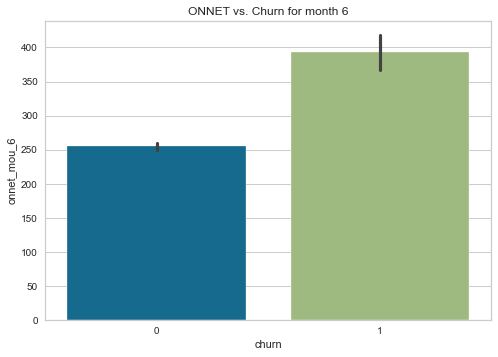

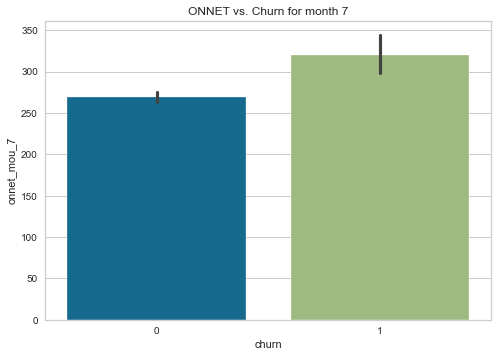

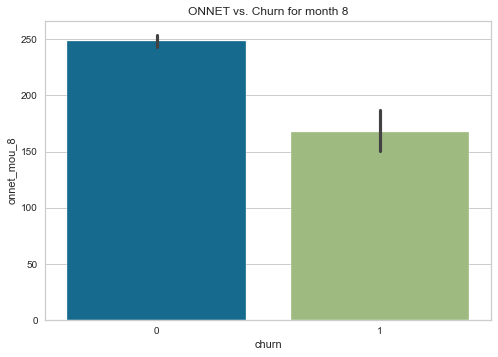

In [56]:
for month in [6,7,8]:
    plt.title('ONNET vs. Churn for month %d' %month)
    sns.barplot(x='churn', y='onnet_mou_'+str(month), data=tagged_churn_df)
    plt.show()

- The Same Operator/network Calls Drop in month 8 indicates Churn

### All kind of calls outside the operator T network vs Churn By Month

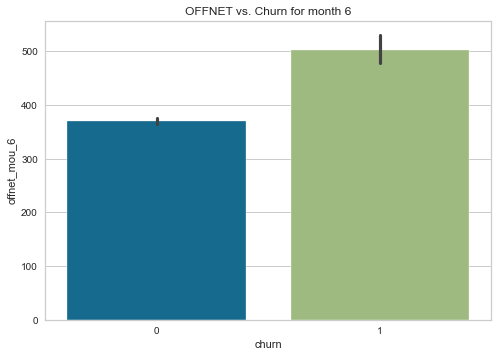

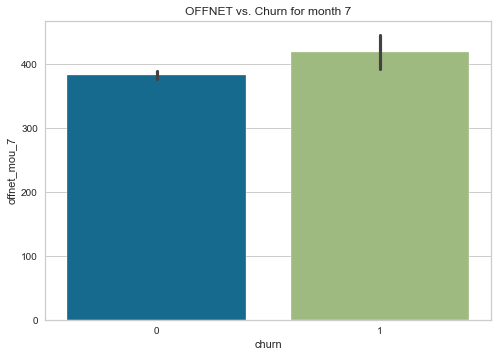

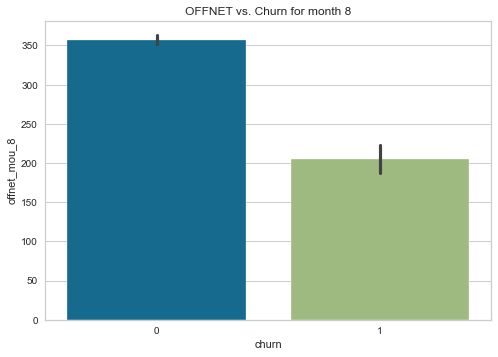

In [57]:
for month in [6,7,8]:
    plt.title('OFFNET vs. Churn for month %d' %month)
    sns.barplot(x='churn', y='offnet_mou_'+str(month), data=tagged_churn_df)
    plt.show()

- The Different operator/network Calls Drop in month 8 indicates Churn

### Checking correlation between features

Based on the above analysis we can check the correlation among incoming,outgoing,roaming and recharge amount features

In [49]:
corr_cols = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 
            'total_rech_amt_6', 'total_rech_amt_7', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
            'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8']

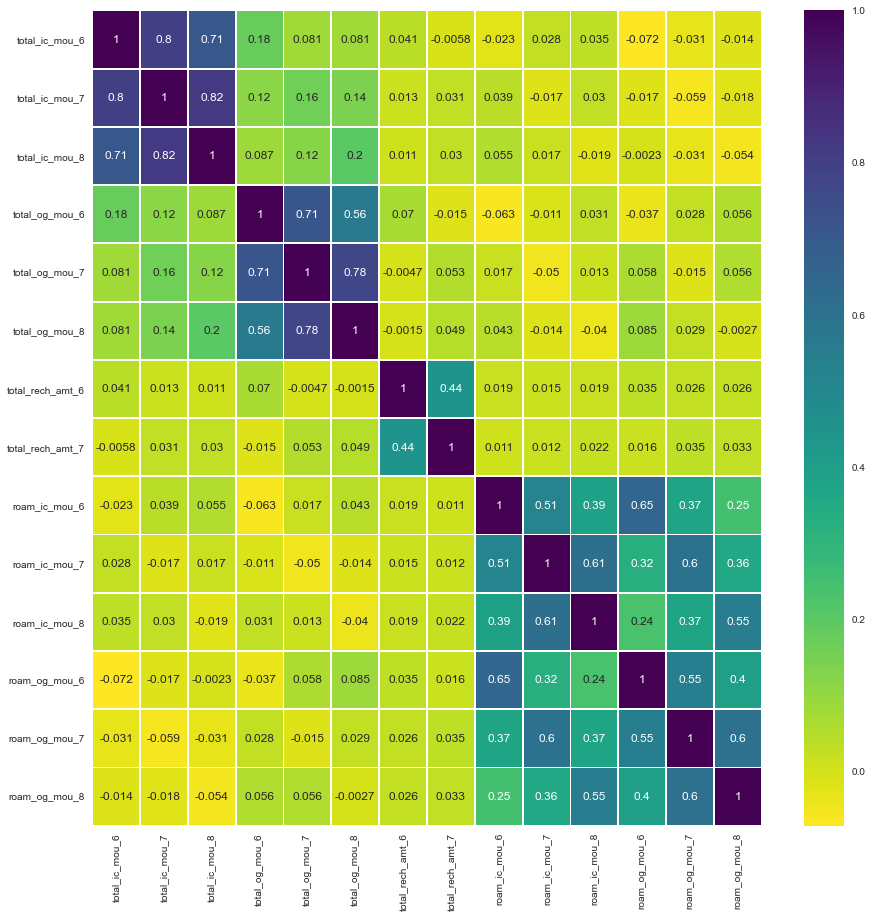

In [50]:
plt.figure(figsize=(15,15))
sns.heatmap(tagged_churn_df[corr_cols].corr(), cmap='viridis_r', annot=True, linecolor='white', linewidths=0.8)
plt.show()

- Total incoming mou for month 7 and 8 are highly correlated
- Total incoming mou for month 6 and 7 are highly correlated
- Also there is high correlation between Total outgoing mou for Total outgoing mou for month 6 and 7

Let's also check the correlation among Same network and different network calls

In [51]:
corr_cols = ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']

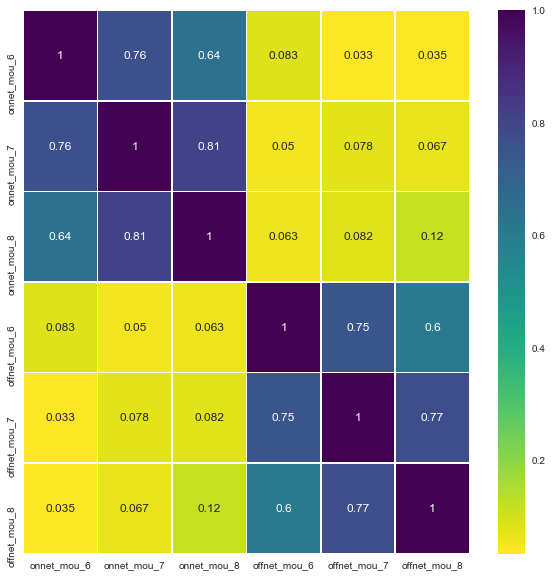

In [52]:
plt.figure(figsize=(10,10))
sns.heatmap(tagged_churn_df[corr_cols].corr(), cmap='viridis_r', annot=True, linecolor='white', linewidths=0.8)
plt.show()

- High Correlation between same network calls for month 7 and 8
- High Correlation between outside network calls for month 7 and 8

In [53]:
corr_cols = ['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8',
            'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 
             'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8']

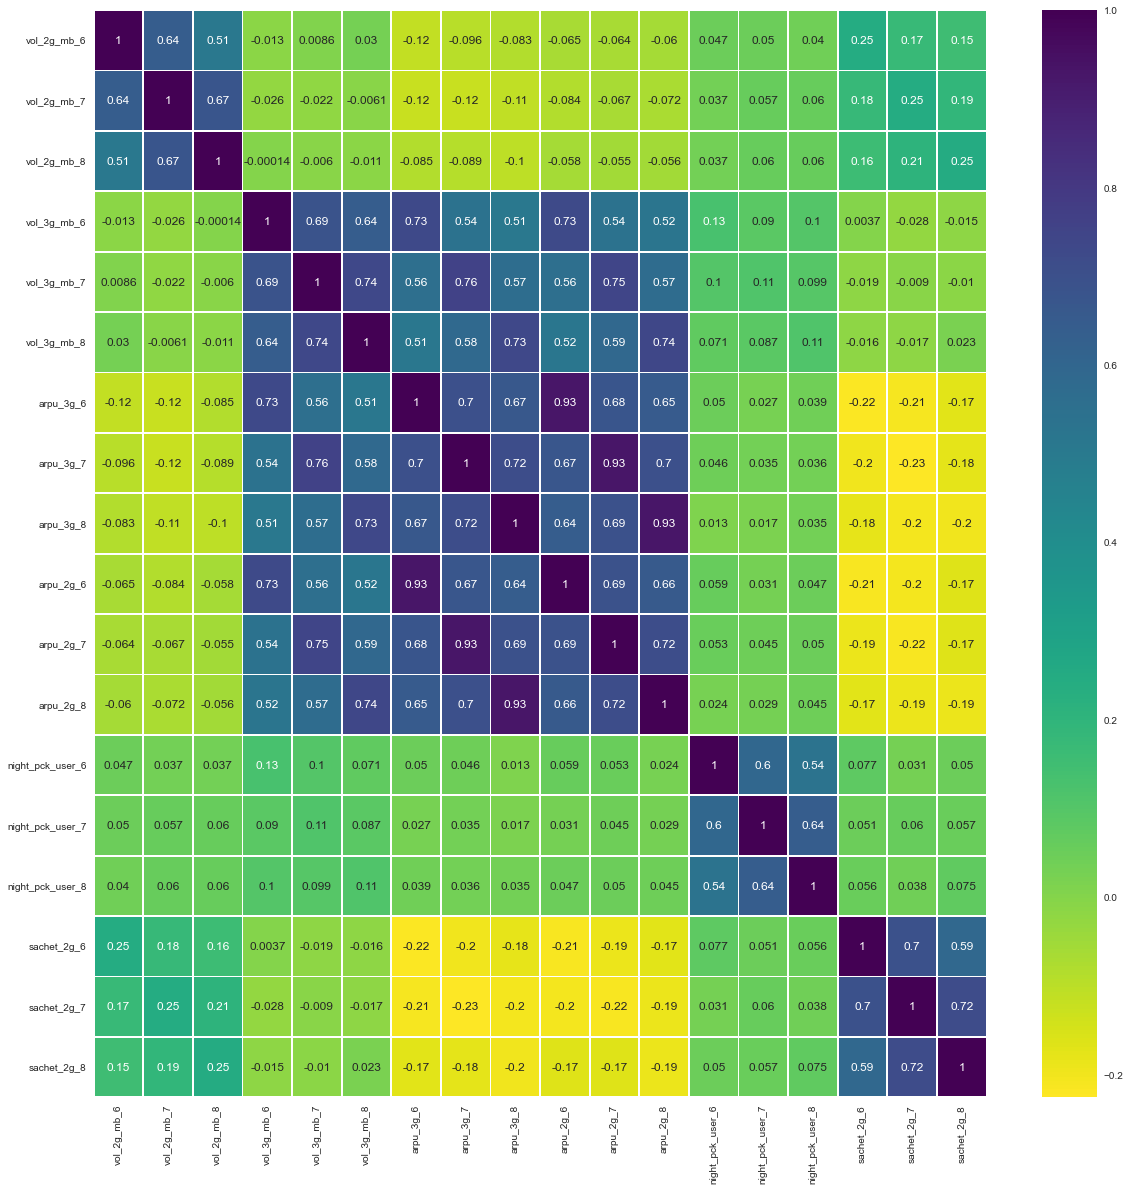

In [54]:
plt.figure(figsize=(20,20))
sns.heatmap(tagged_churn_df[corr_cols].corr(), cmap='viridis_r', annot=True, linecolor='white', linewidths=0.8)
plt.show()

- Here we can see high correlation between variables ARPU 2g and ARPU 3g for months 6 7 and 8

### Volume Based Cost Vs Churn by Month

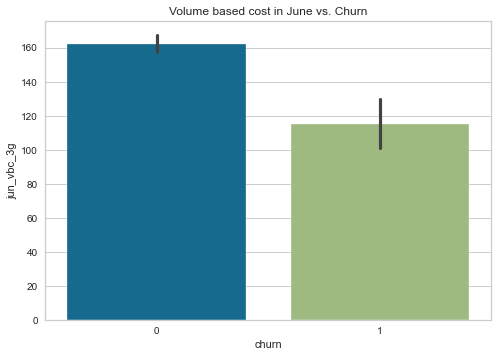

In [55]:
plt.title('Volume based cost in June vs. Churn')
sns.barplot(x='churn', y='jun_vbc_3g', data=tagged_churn_df)
plt.show()

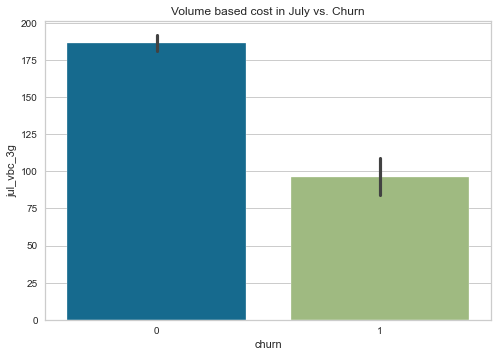

In [56]:
plt.title('Volume based cost in July vs. Churn')
sns.barplot(x='churn', y='jul_vbc_3g', data=tagged_churn_df)
plt.show()

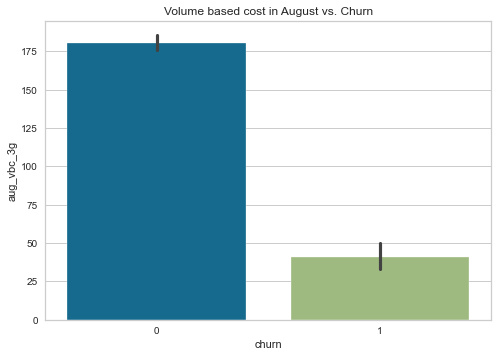

In [57]:
plt.title('Volume based cost in August vs. Churn')
sns.barplot(x='churn', y='aug_vbc_3g', data=tagged_churn_df)
plt.show()

- Drop in Volume based cost indicating Churn moving from month 7 to 8

In [58]:
tagged_churn_df.shape

(30001, 174)

In [59]:
#Dropping date columns
drop_date_columns = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
                    'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
                    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']

tagged_churn_df.drop(drop_date_columns, axis=1, inplace=True)

tagged_churn_df.shape

(30001, 165)

In [60]:
missing_tagged_data = get_missing_report(tagged_churn_df)
missing_tagged_data

columns  missing_perc     type
136           arpu_3g_8     46.825106  float64
157           fb_user_8     46.825106  float64
124     count_rech_3g_8     46.825106  float64
142    night_pck_user_8     46.825106  float64
121     count_rech_2g_8     46.825106  float64
..                  ...           ...      ...
126  av_rech_amt_data_7      0.000000  float64
127  av_rech_amt_data_8      0.000000  float64
128         vol_2g_mb_6      0.000000  float64
129         vol_2g_mb_7      0.000000  float64
164               churn      0.000000    int64

[165 rows x 3 columns]

In [61]:
missing_data = missing_tagged_data[missing_tagged_data['missing_perc'] > 0]
missing_data

columns  missing_perc     type
136         arpu_3g_8     46.825106  float64
157         fb_user_8     46.825106  float64
124   count_rech_3g_8     46.825106  float64
142  night_pck_user_8     46.825106  float64
121   count_rech_2g_8     46.825106  float64
..                ...           ...      ...
72       loc_ic_mou_7      1.789940  float64
96       isd_ic_mou_7      1.789940  float64
4      loc_ic_t2o_mou      0.746642  float64
3      std_og_t2o_mou      0.746642  float64
2      loc_og_t2o_mou      0.746642  float64

[111 rows x 3 columns]

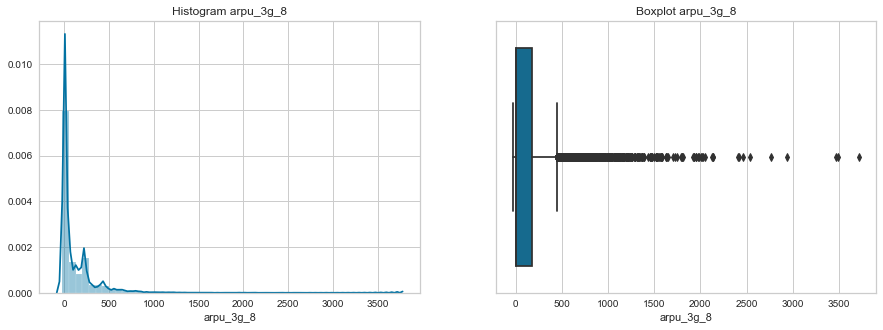

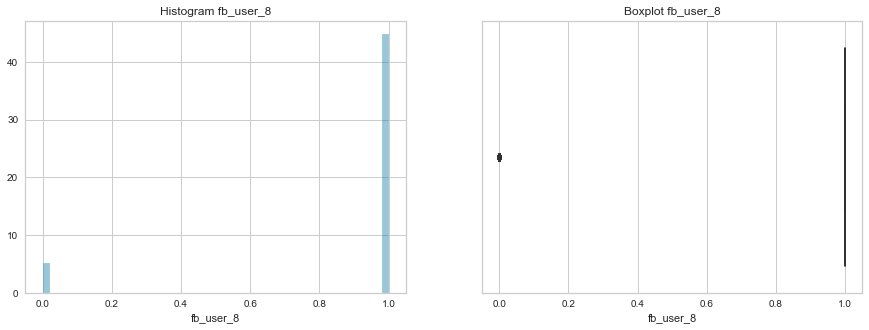

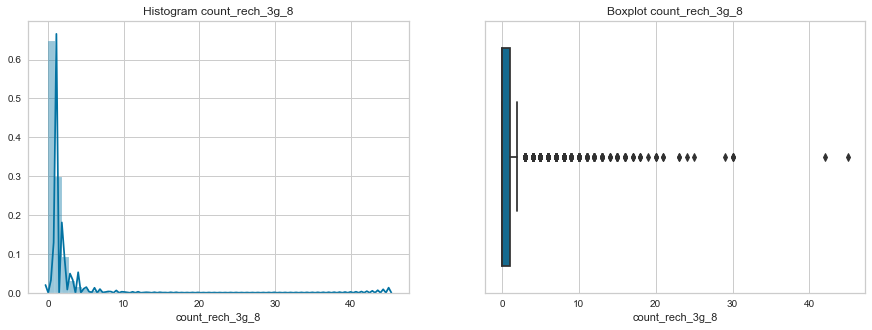

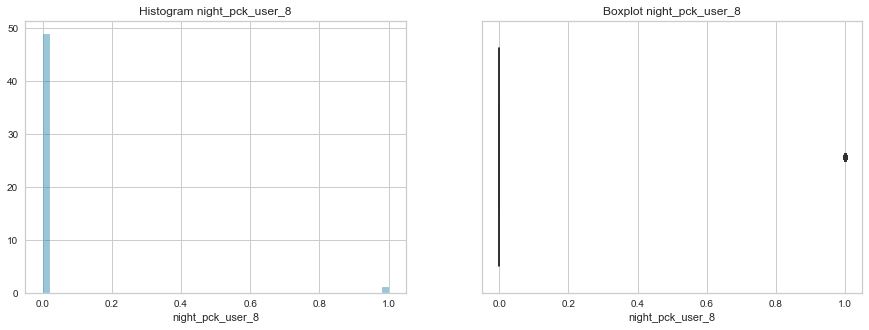

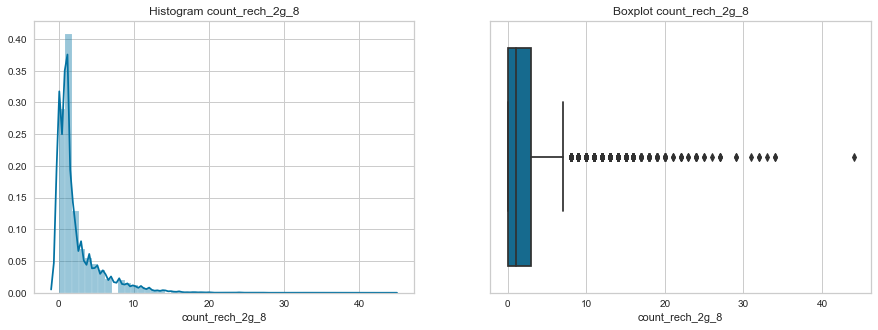

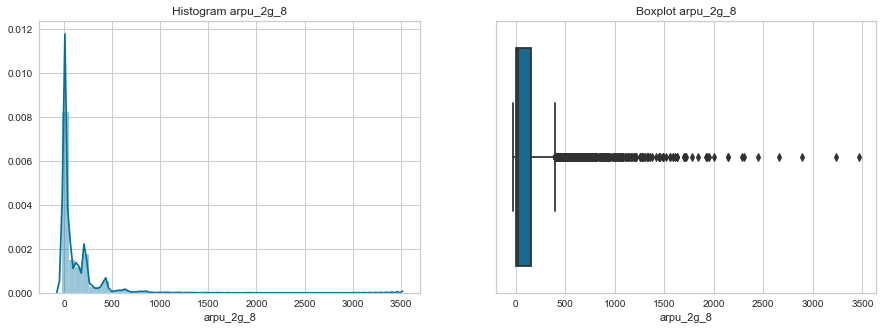

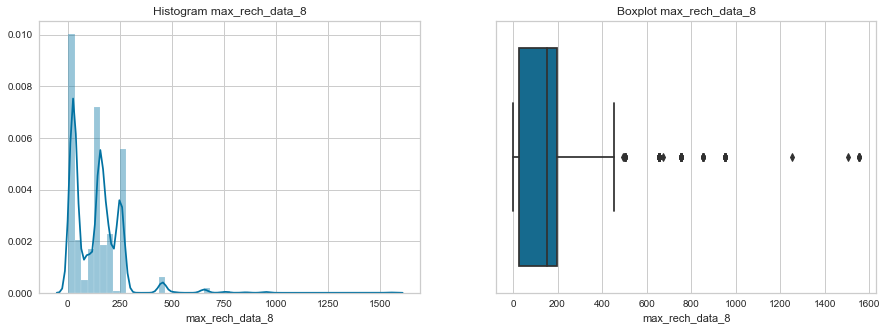

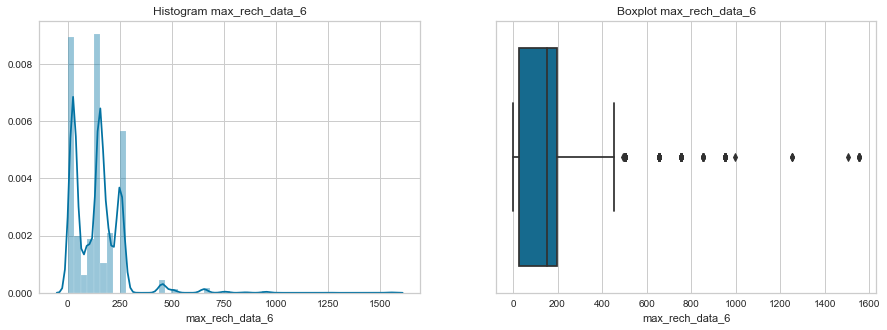

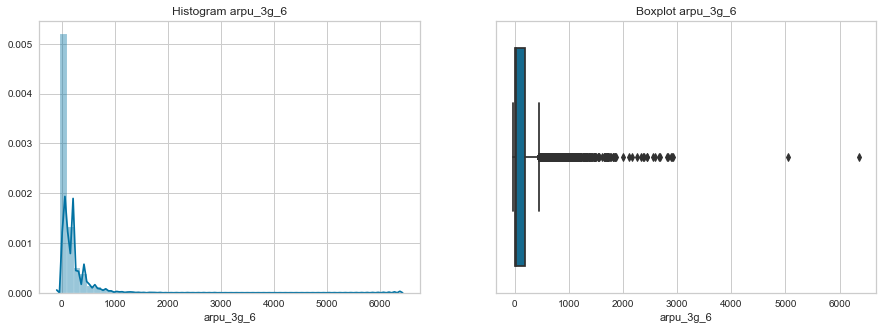

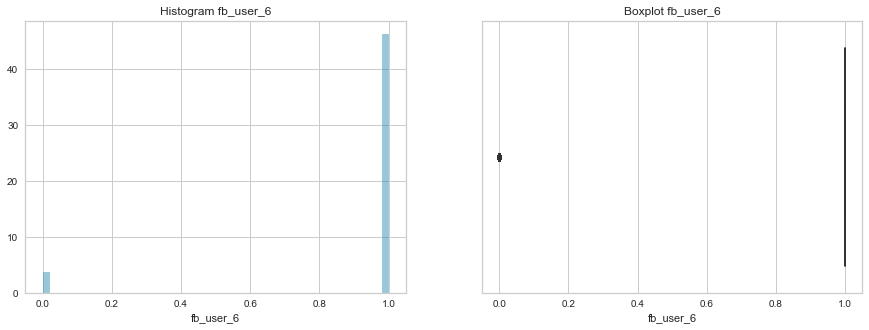

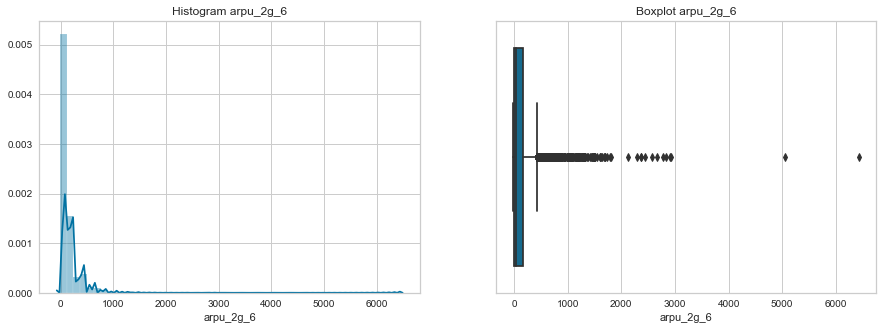

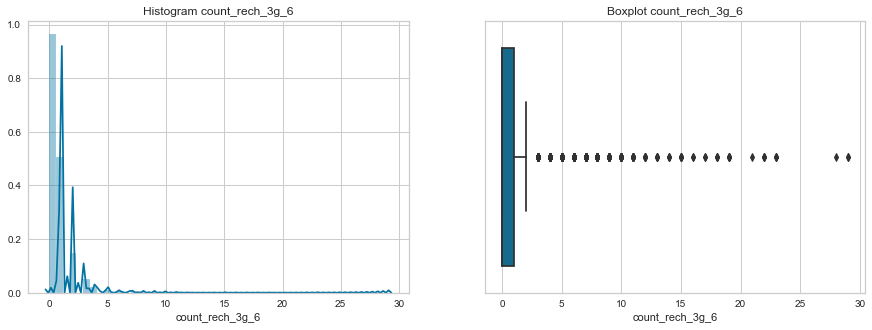

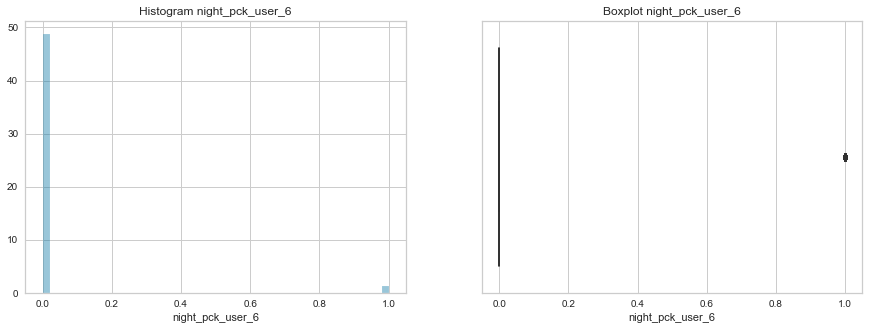

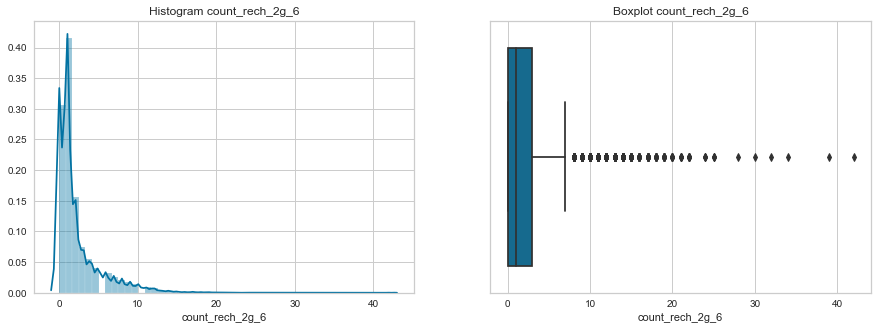

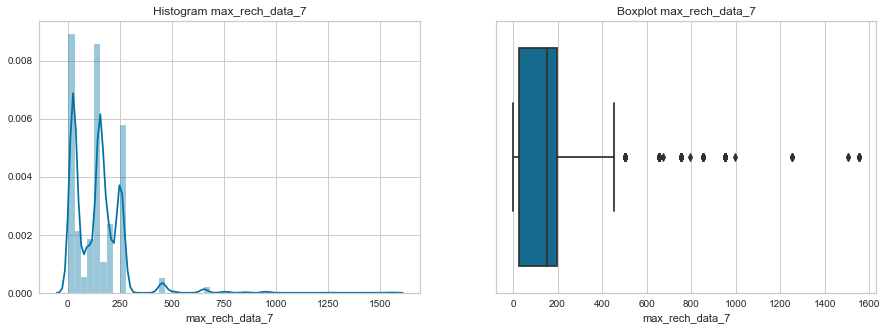

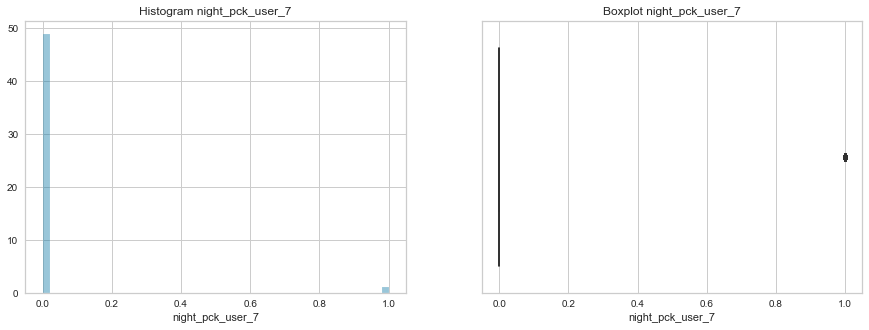

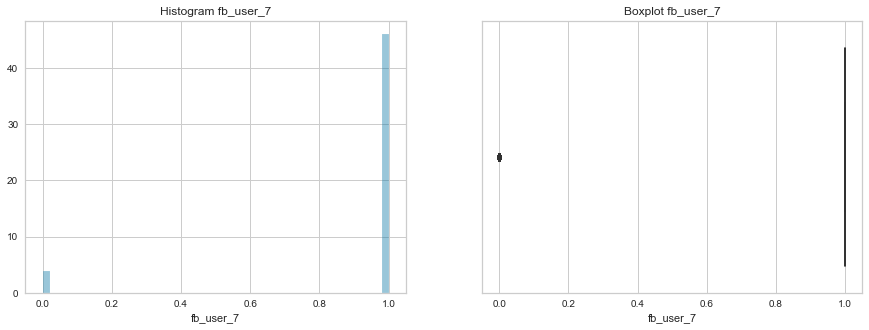

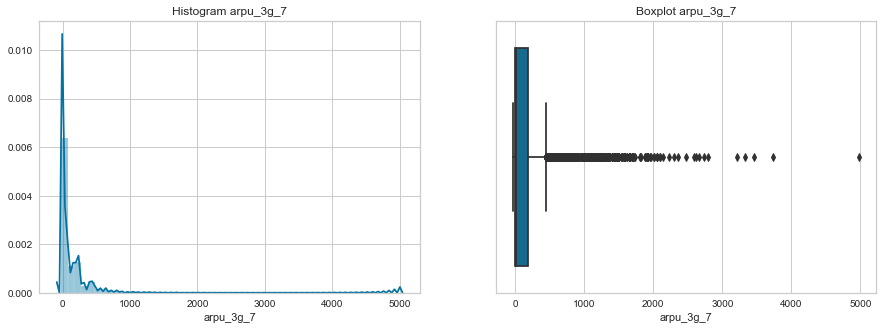

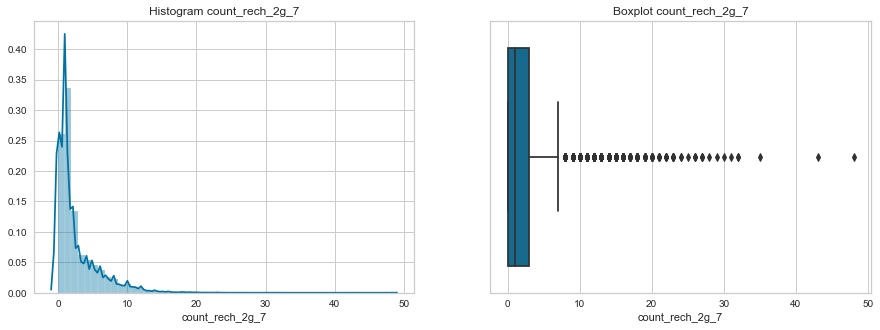

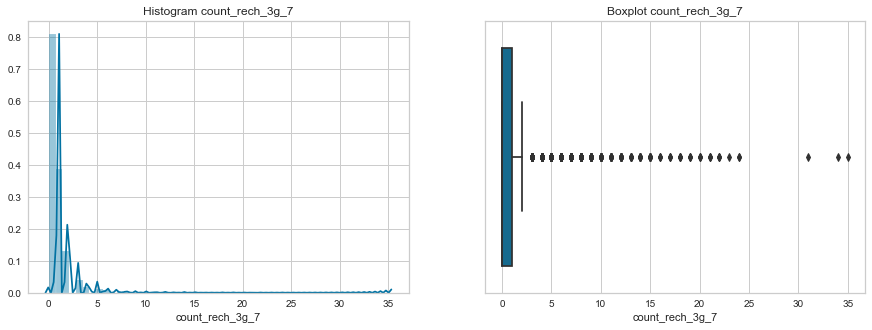

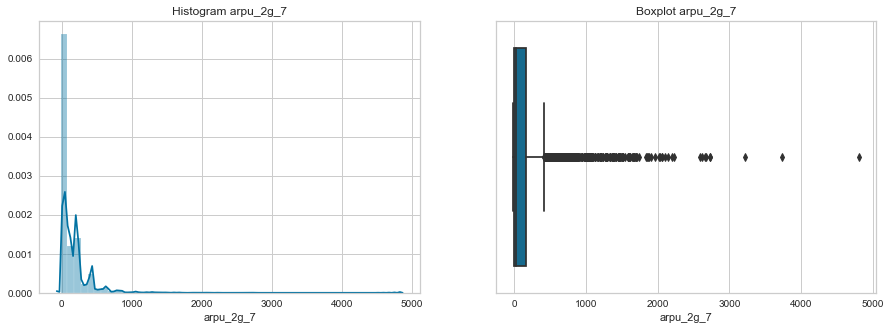

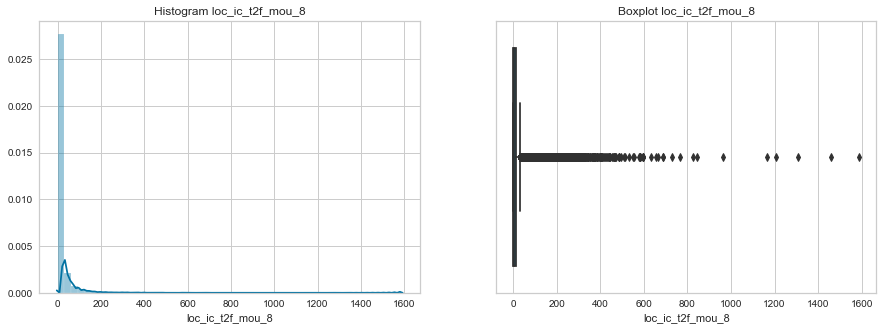

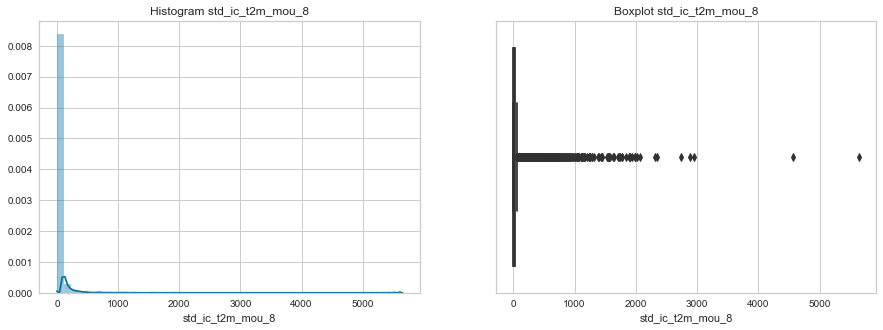

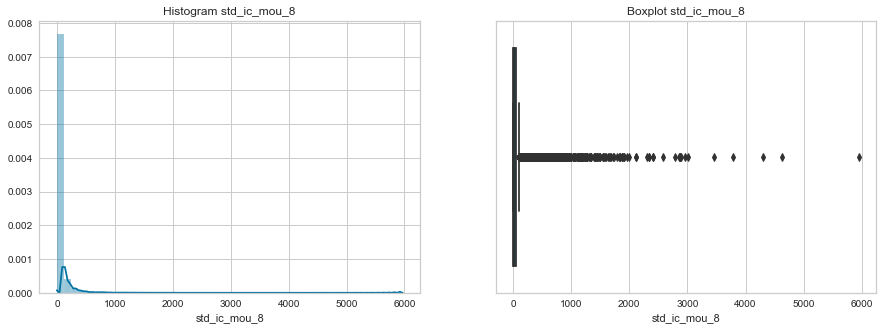

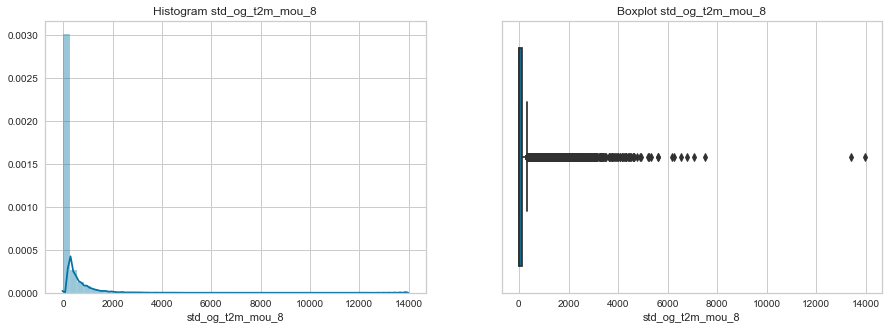

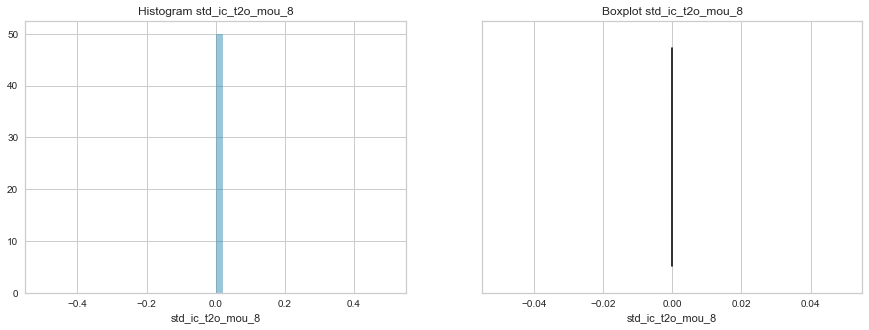

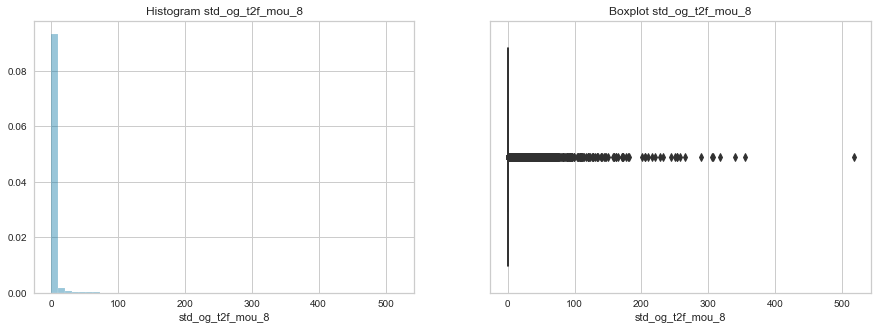

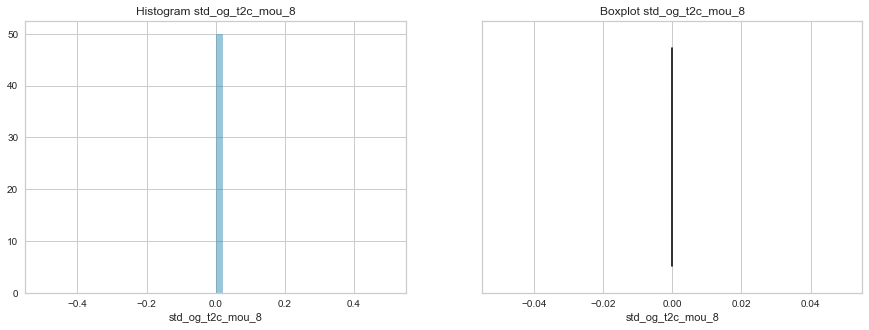

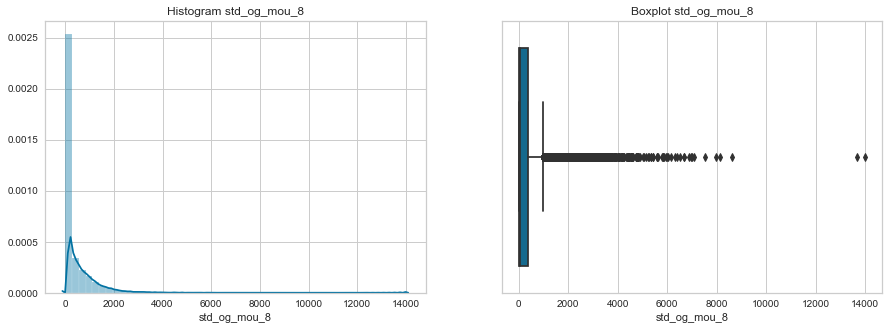

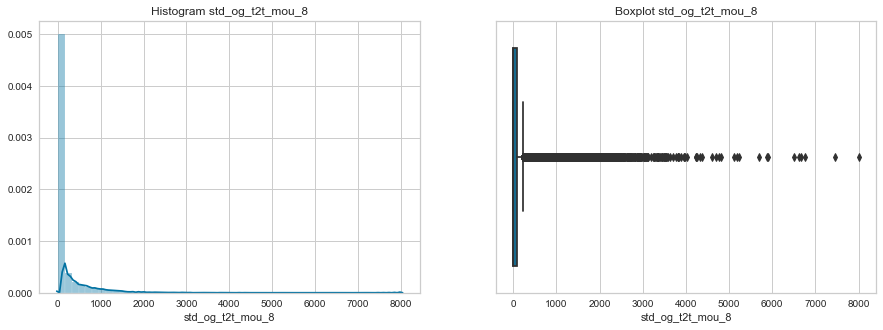

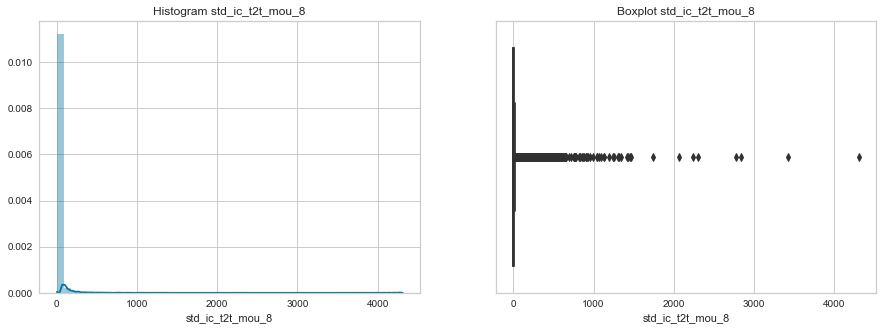

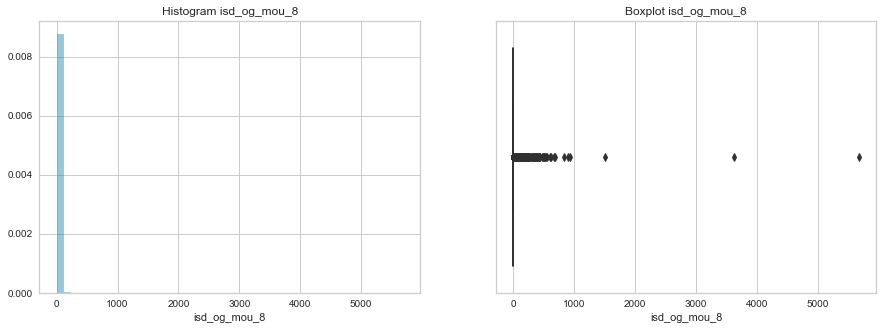

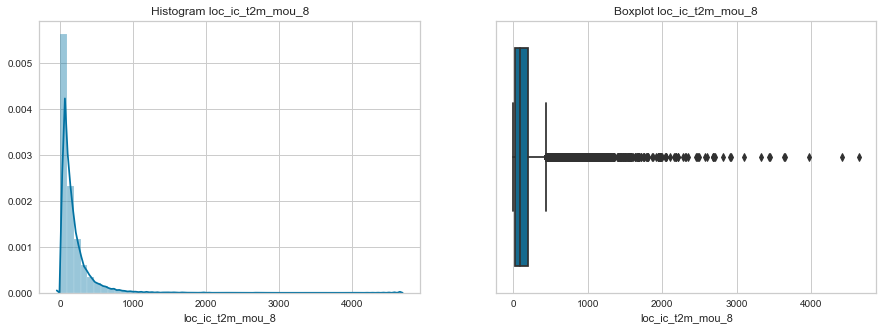

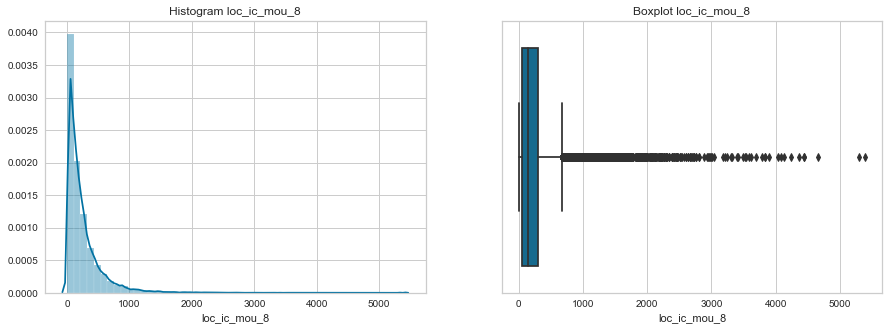

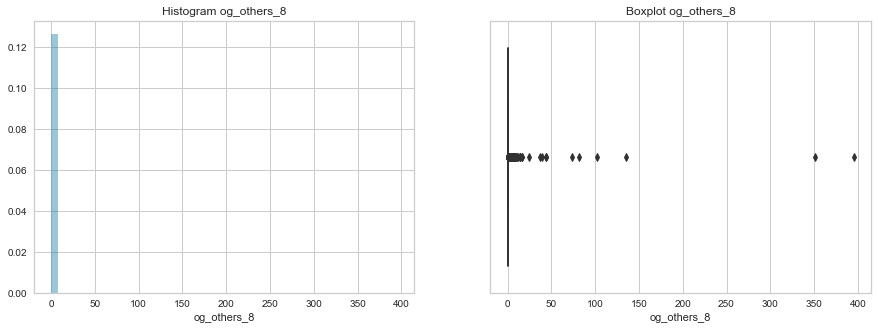

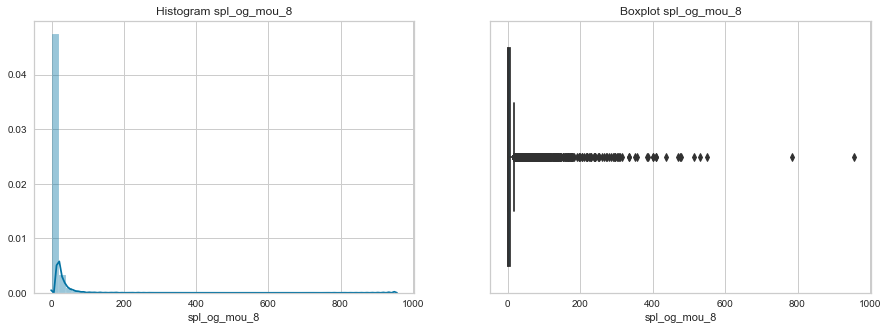

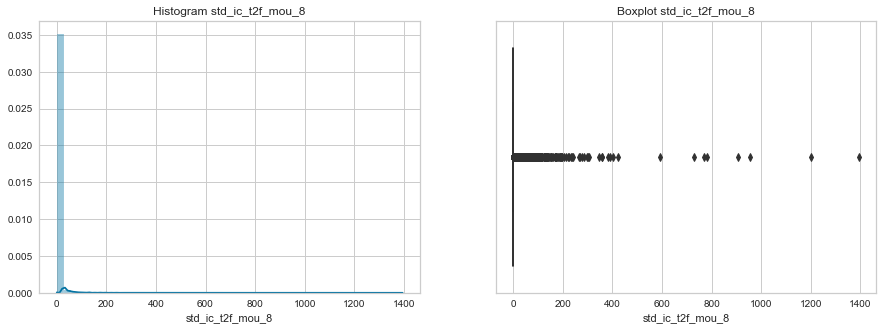

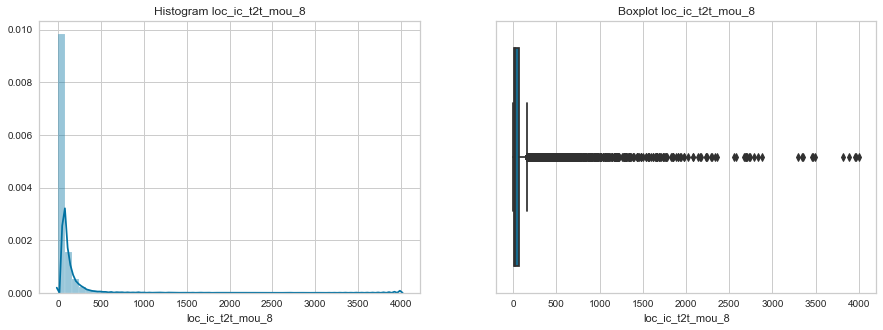

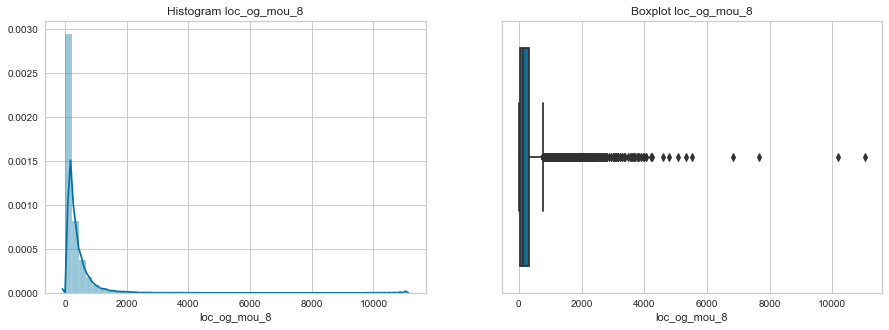

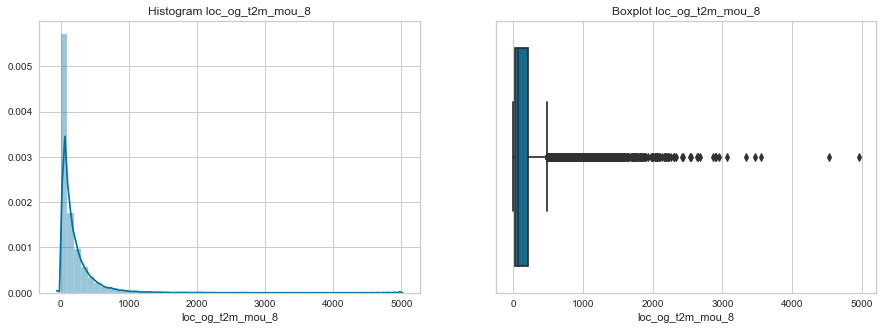

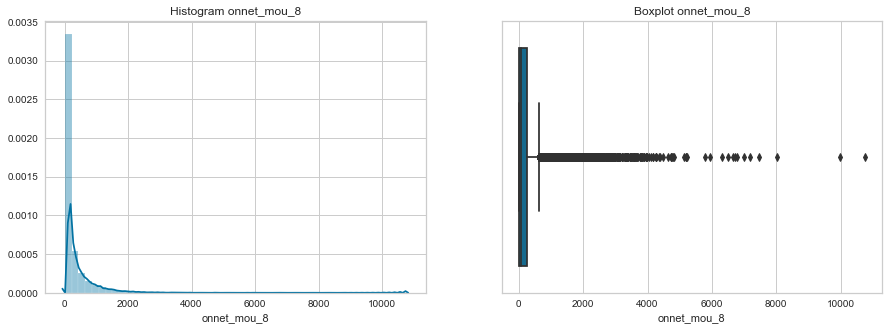

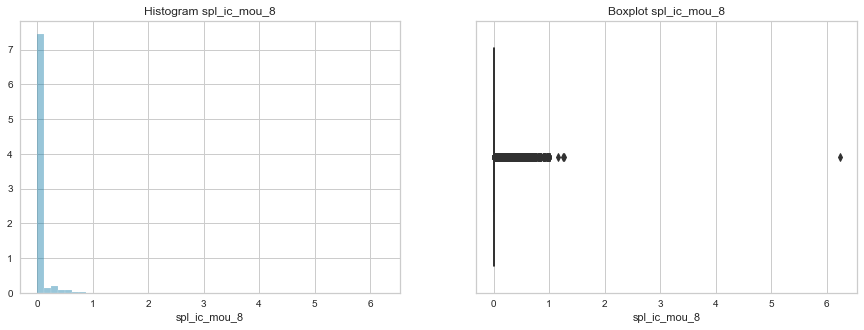

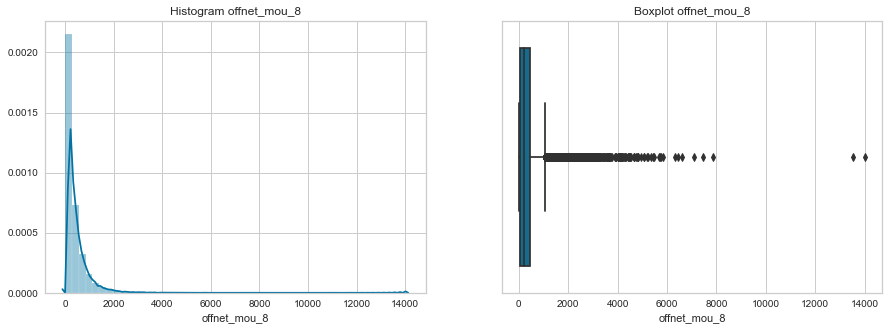

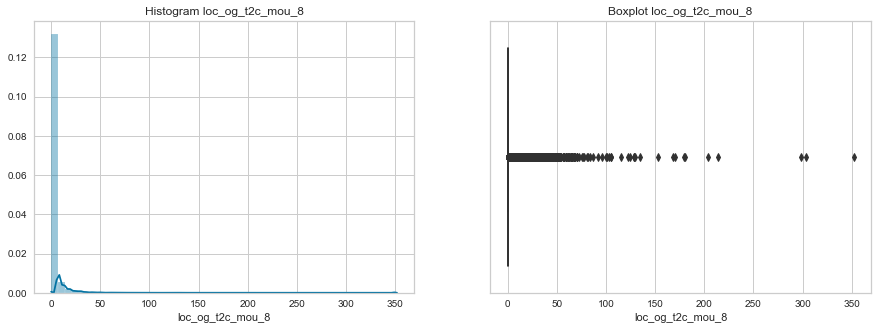

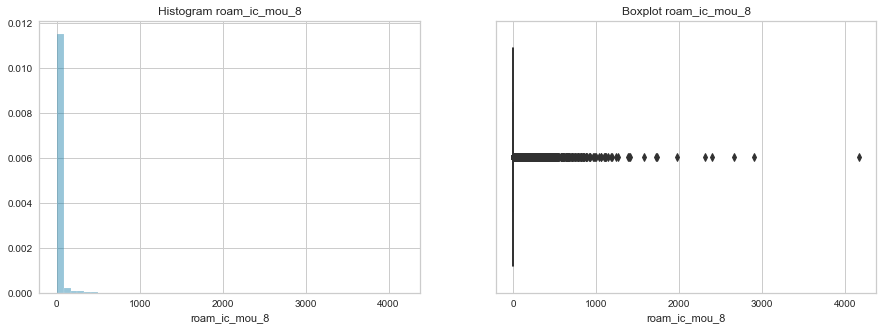

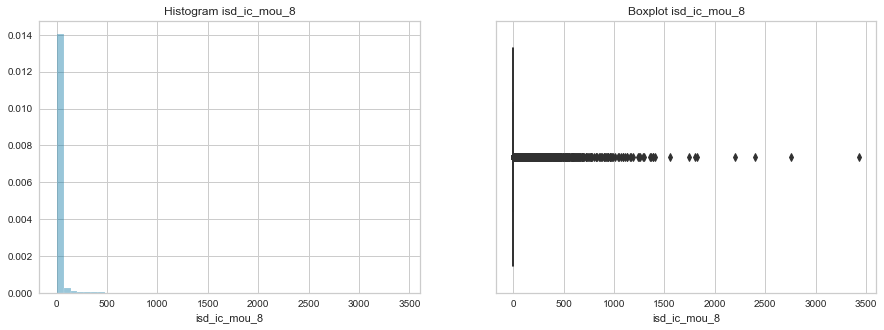

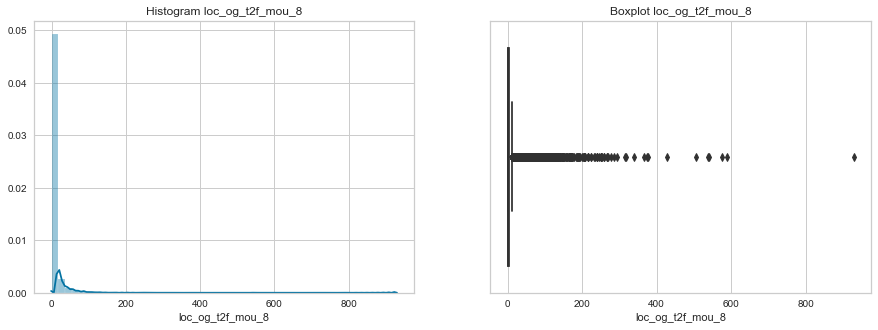

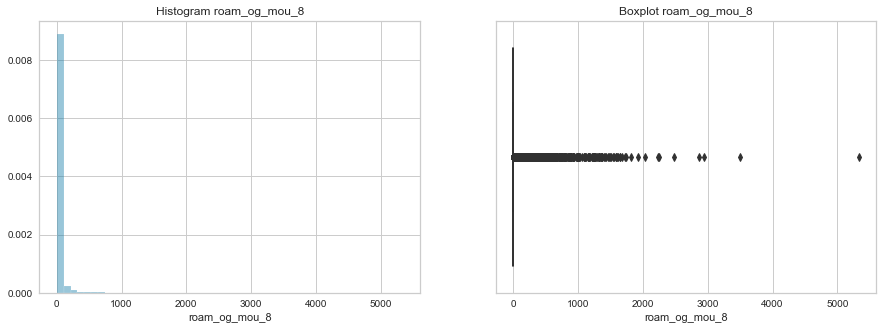

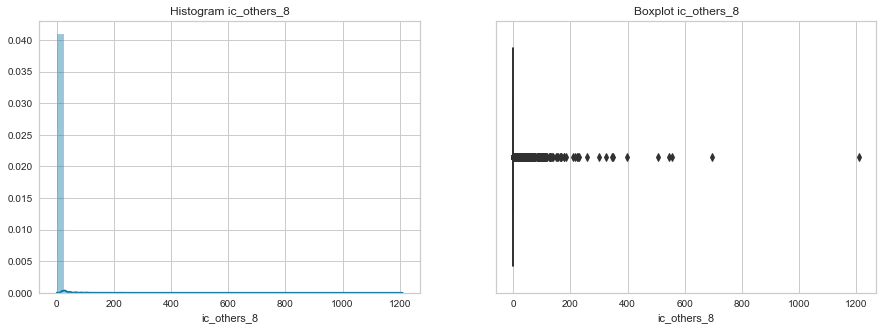

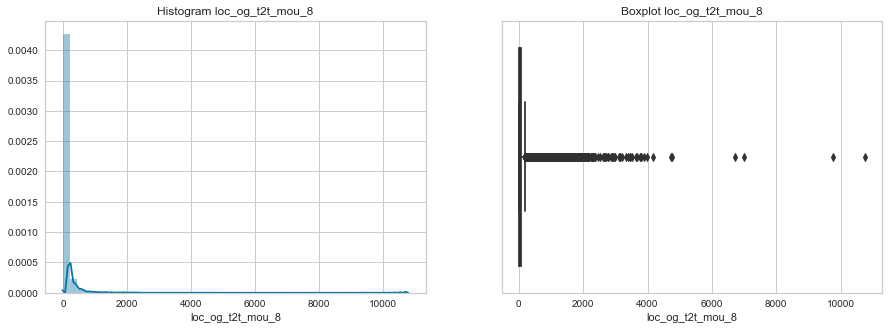

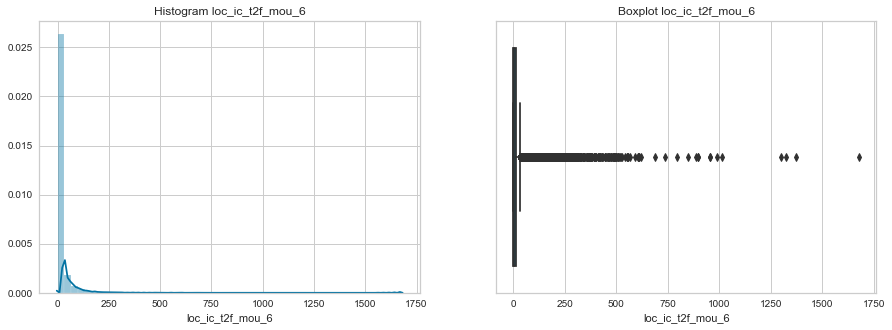

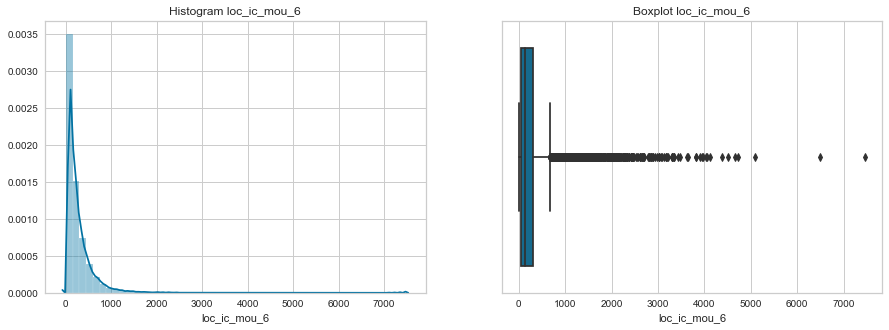

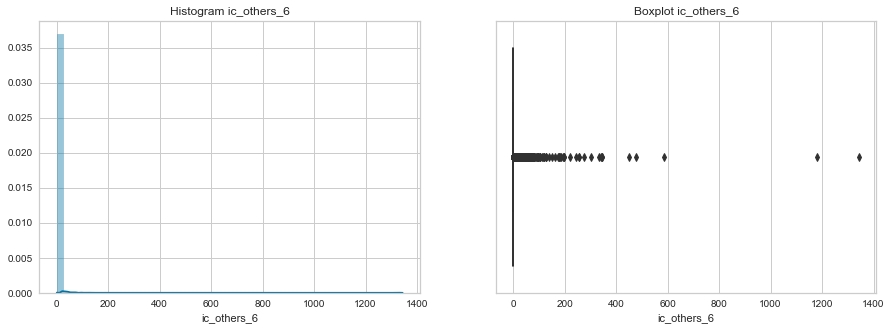

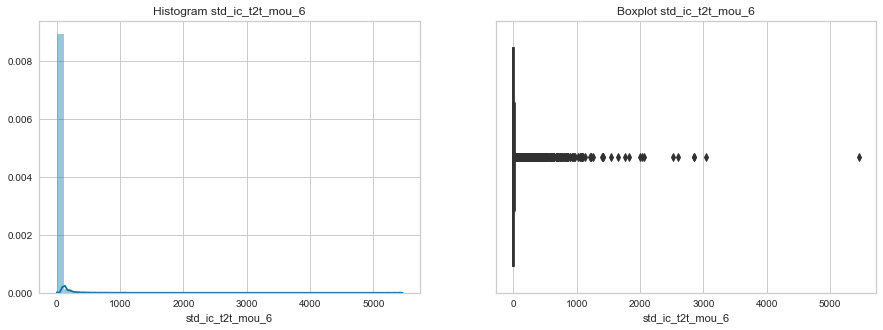

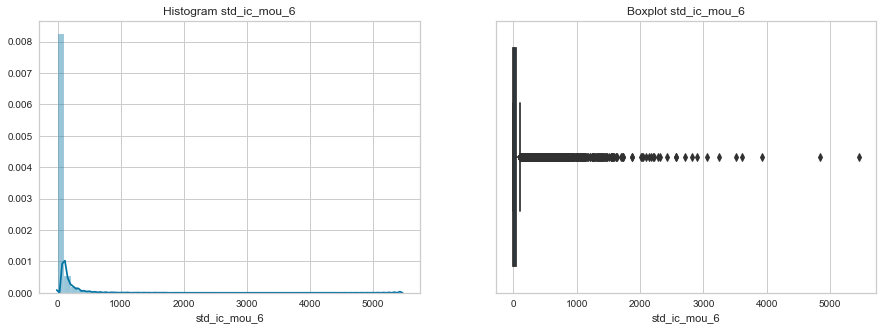

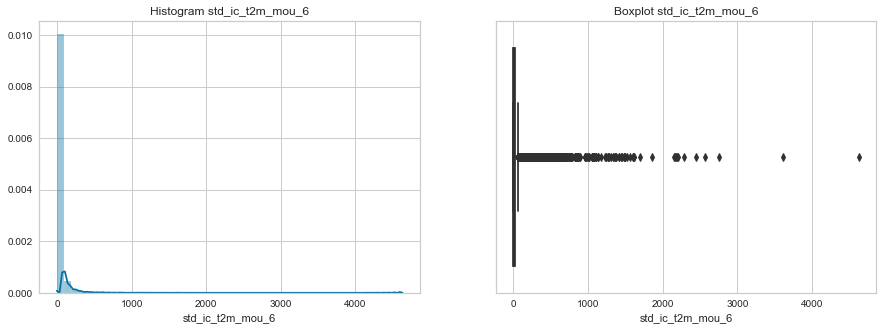

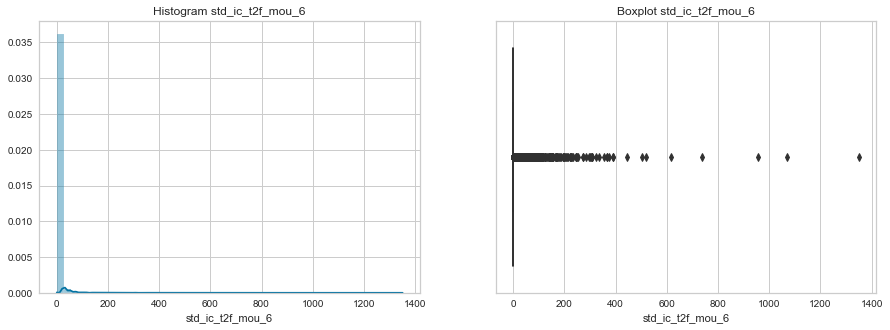

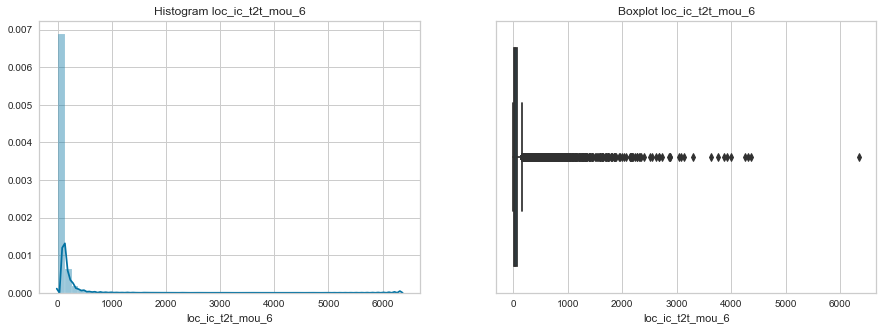

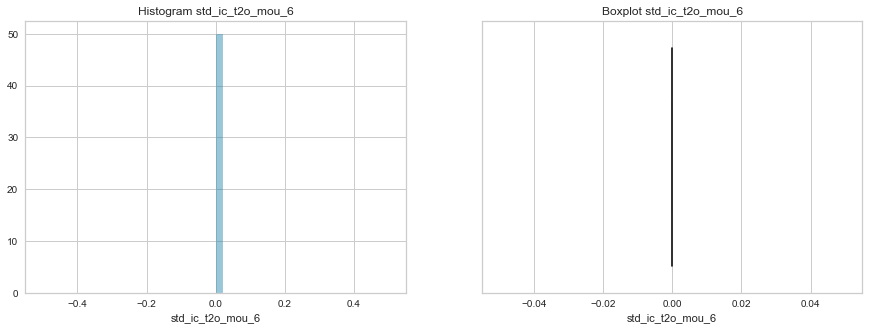

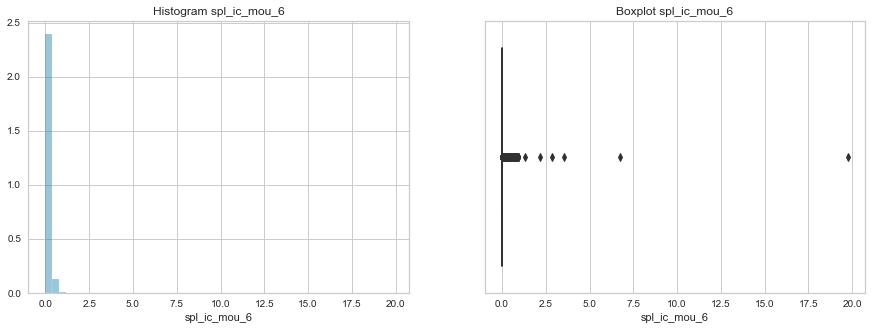

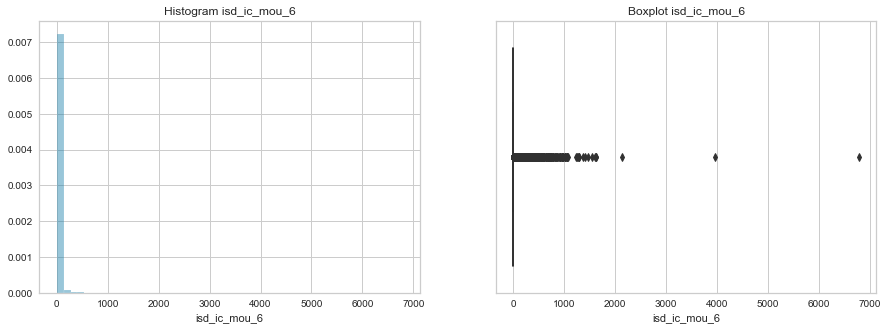

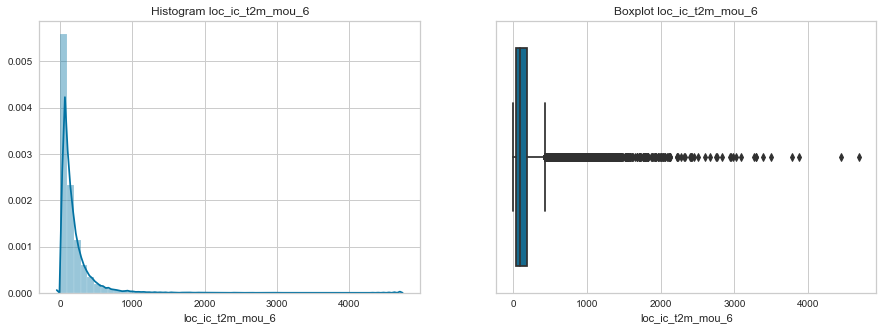

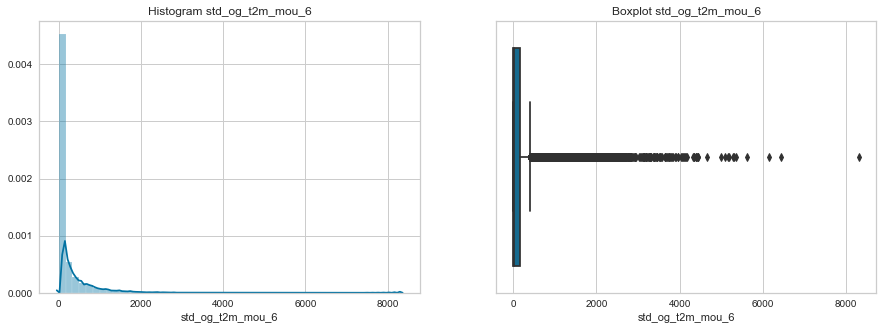

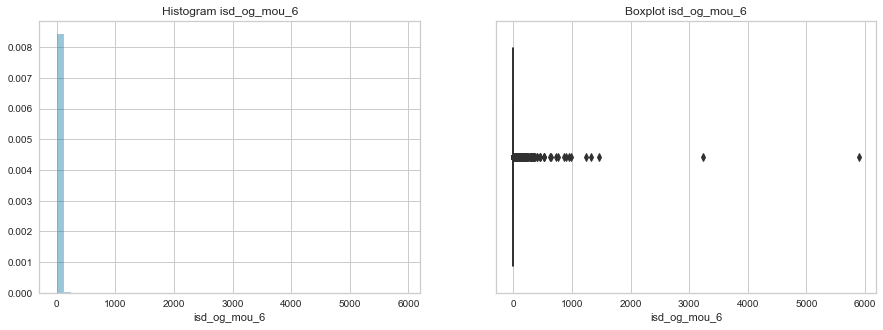

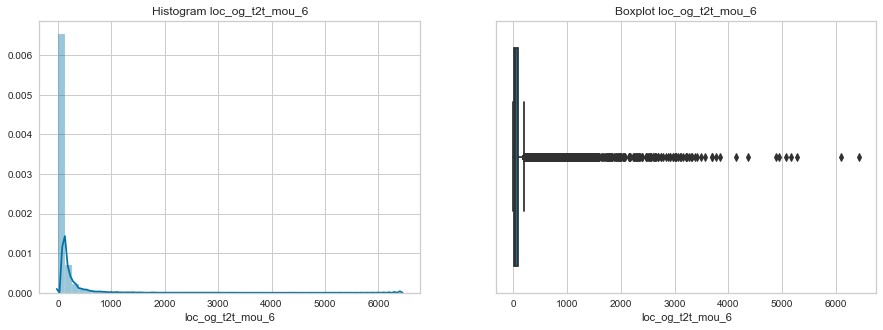

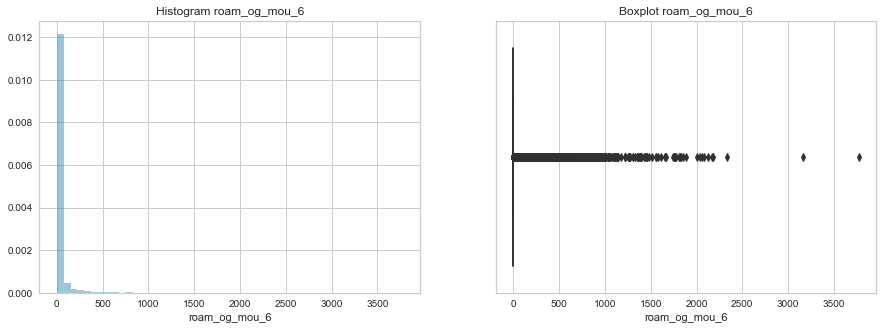

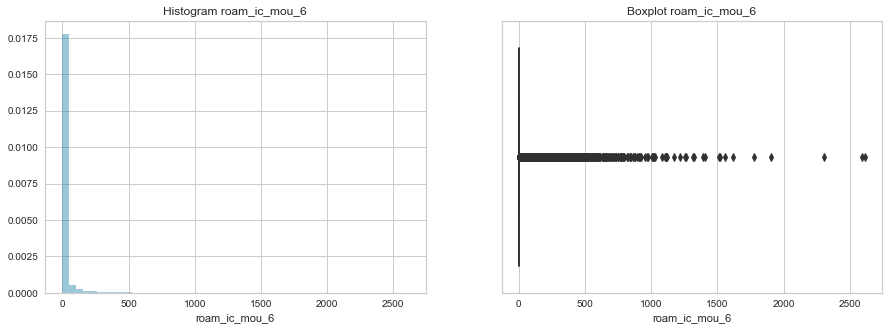

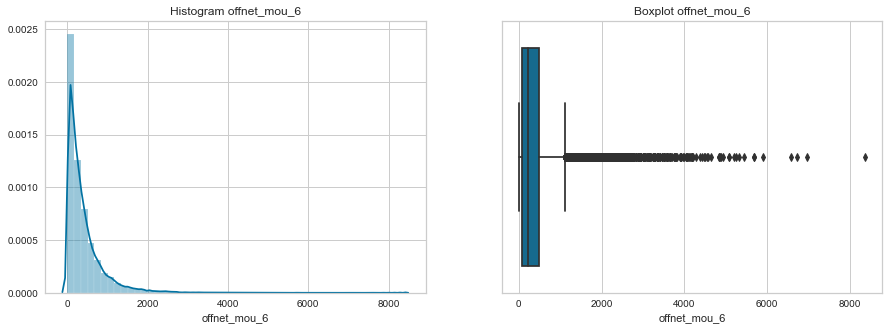

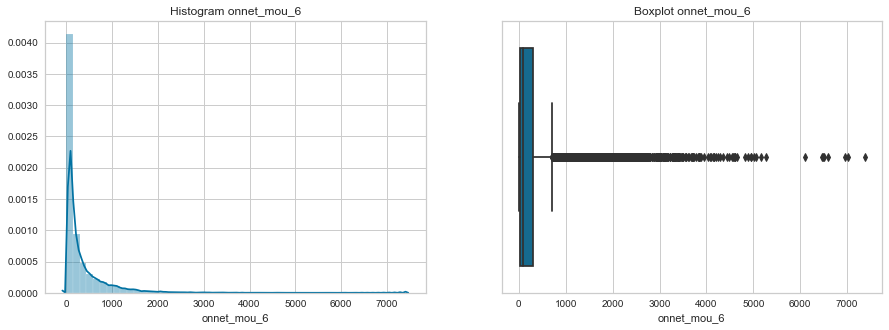

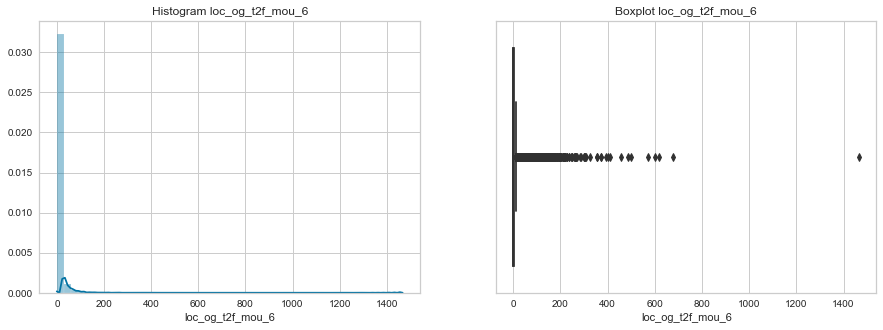

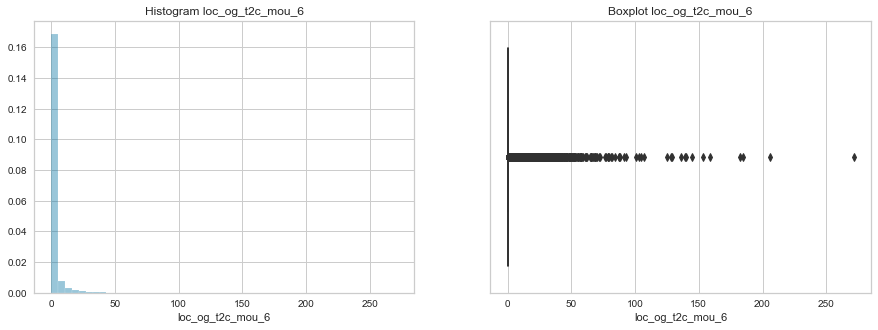

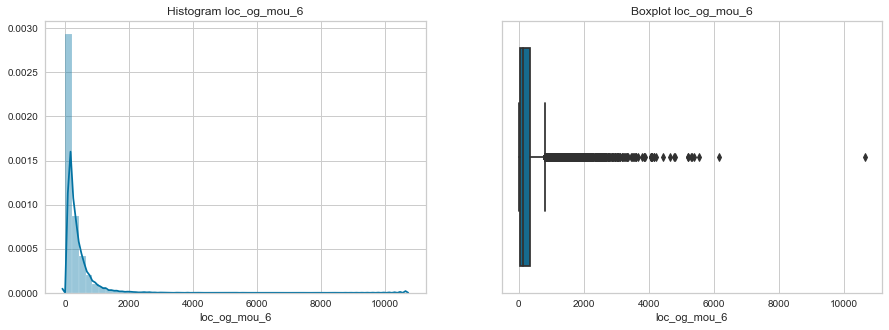

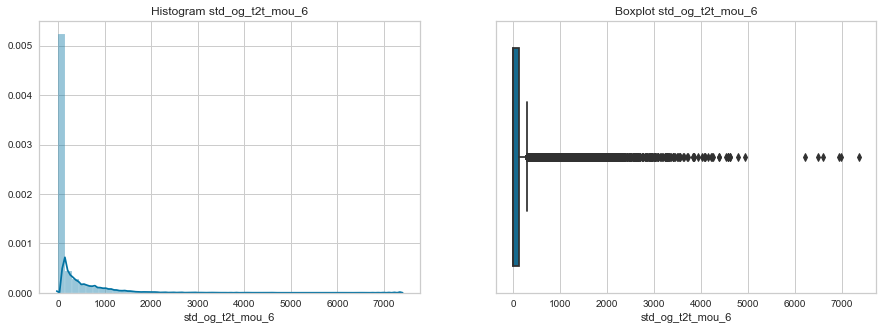

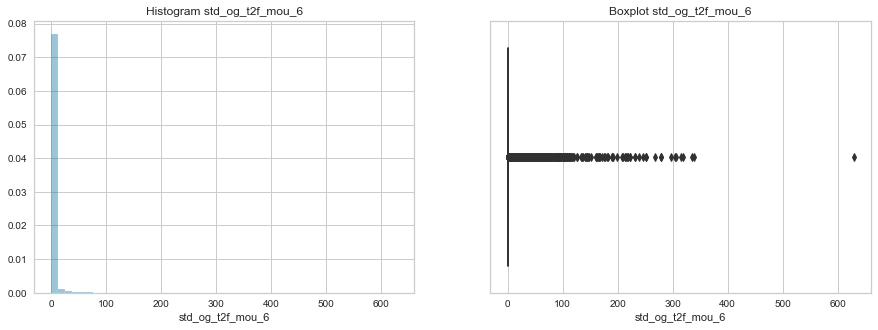

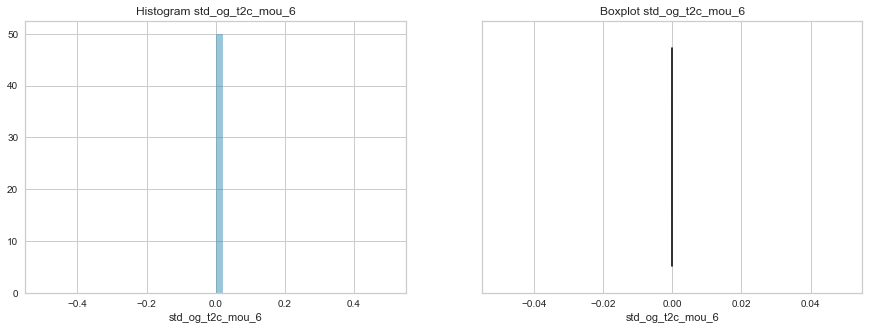

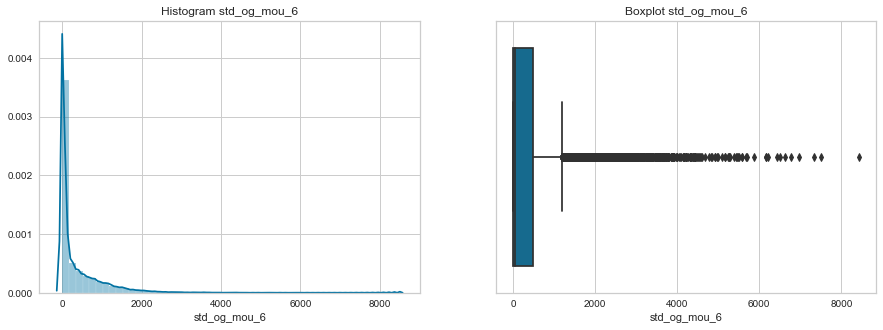

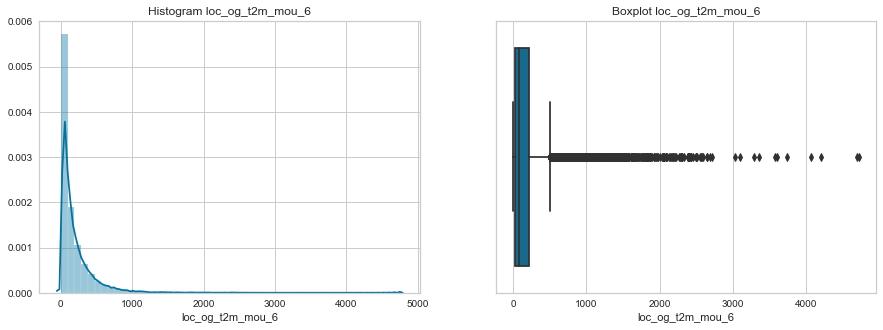

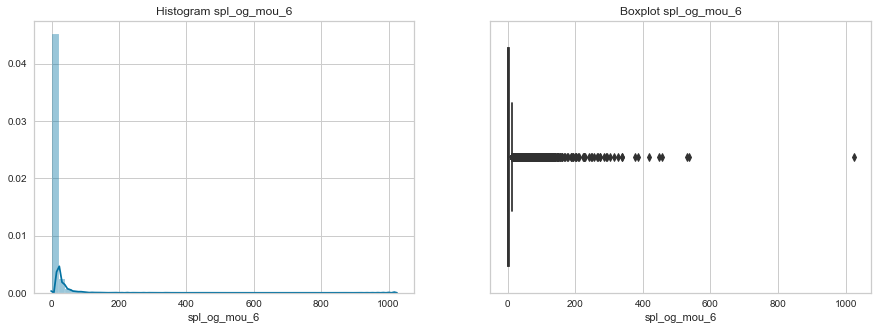

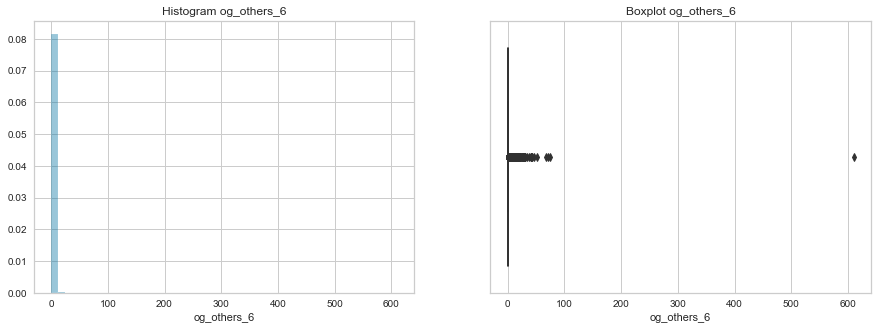

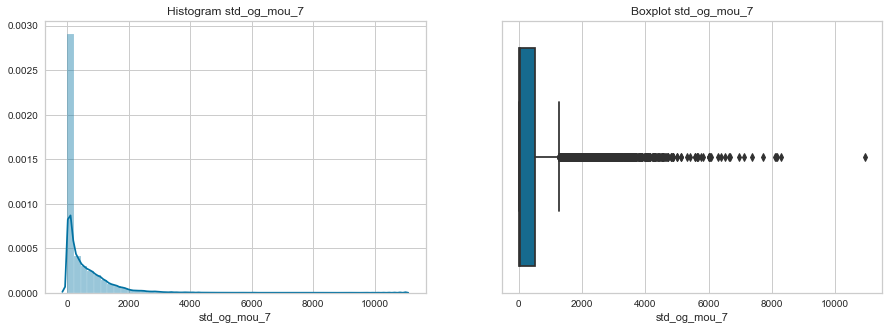

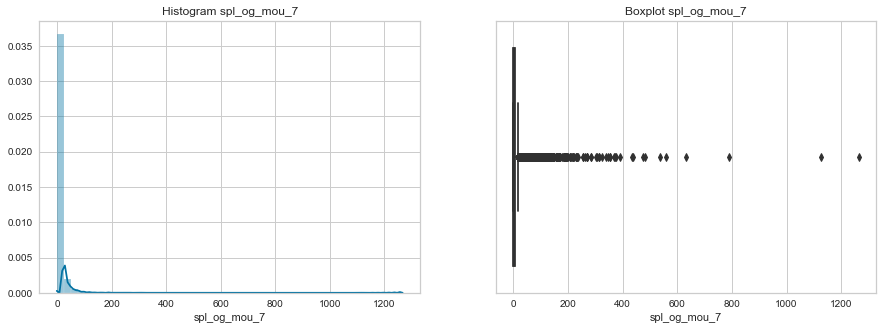

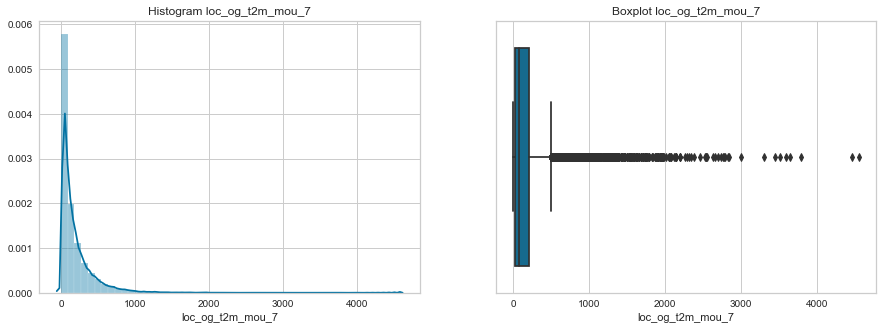

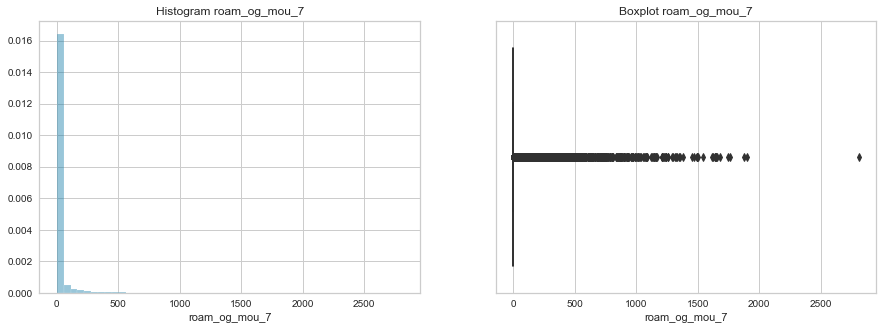

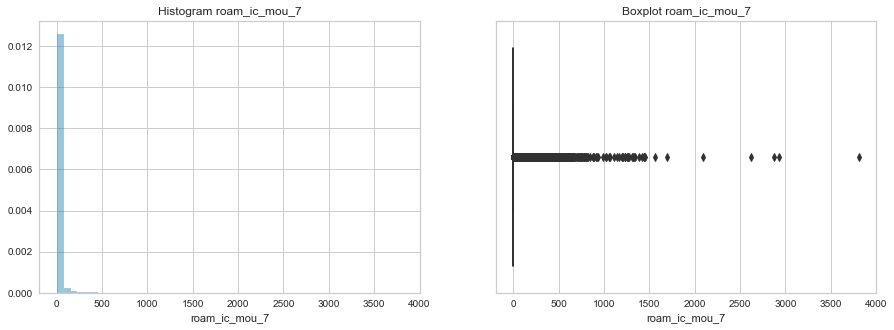

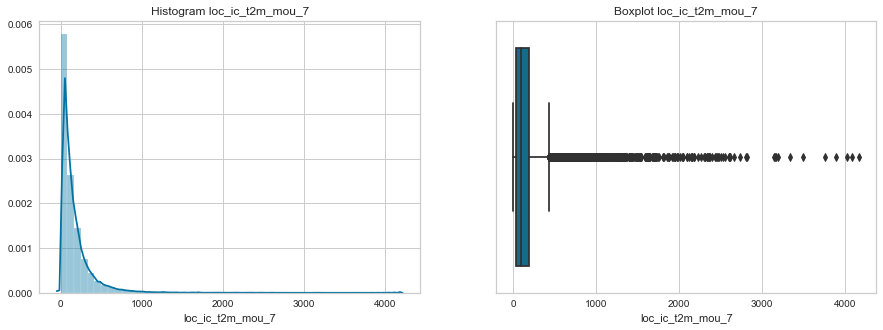

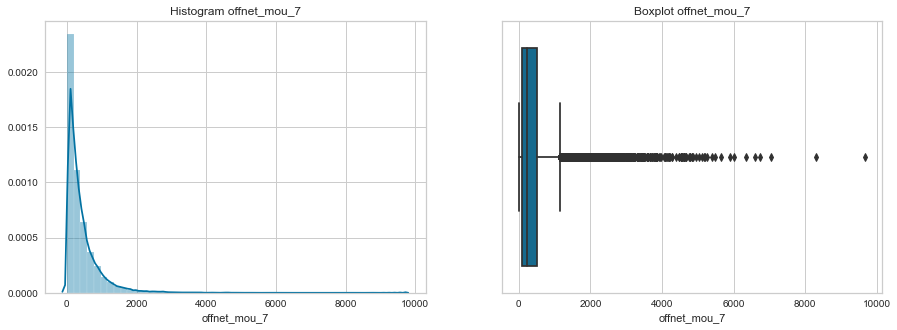

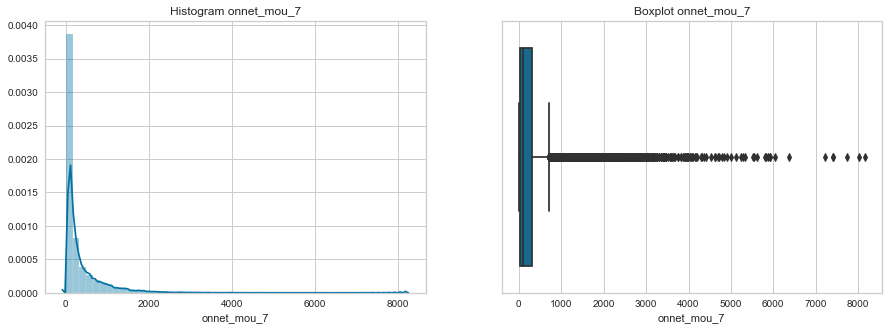

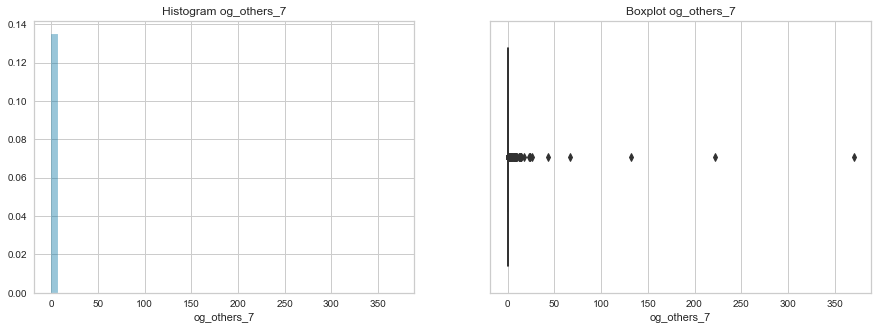

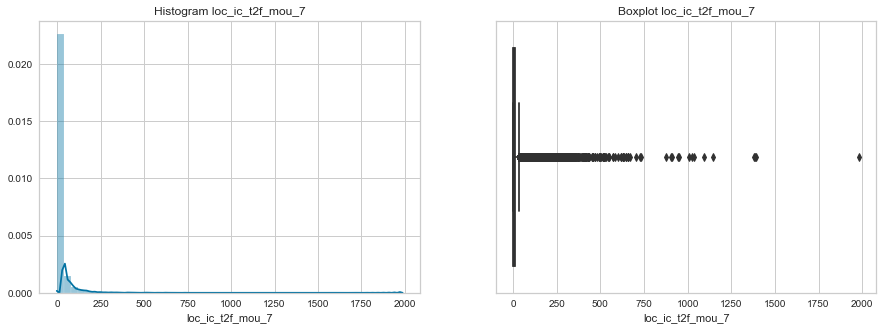

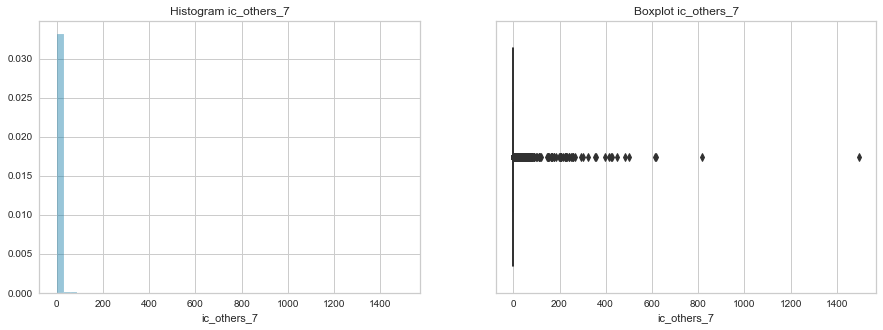

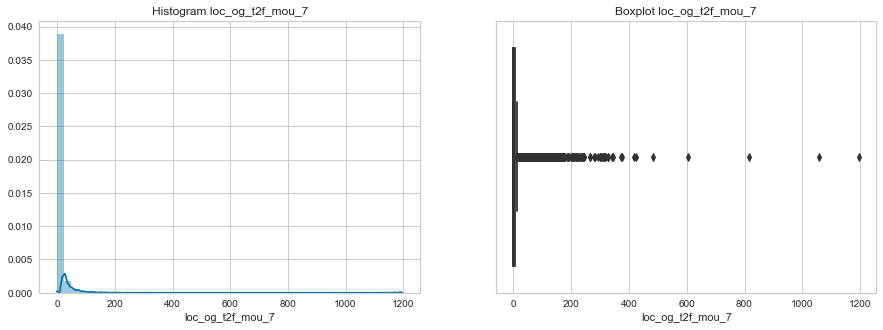

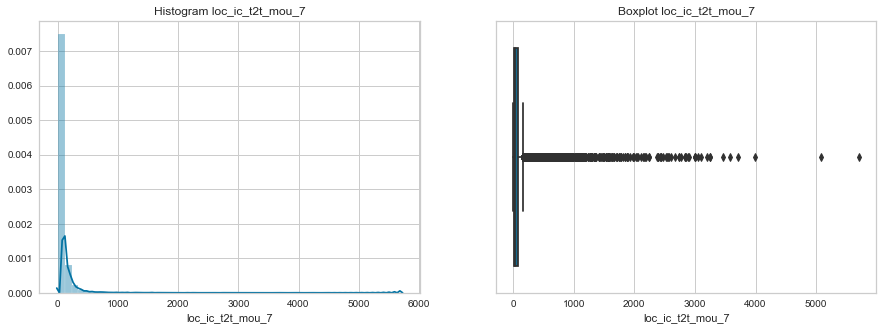

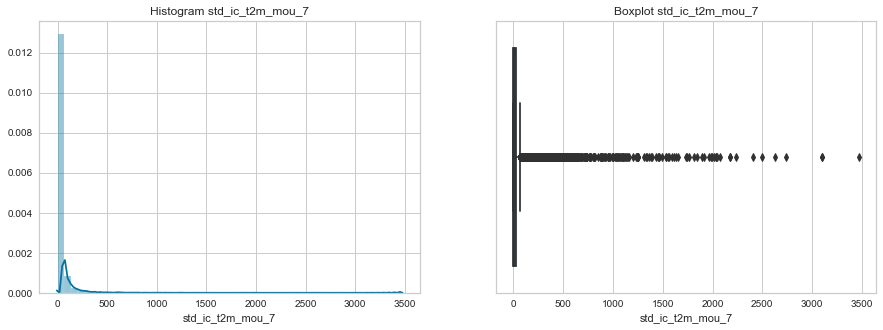

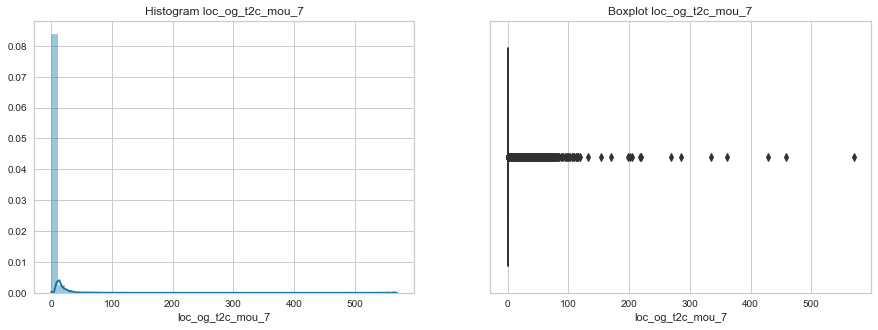

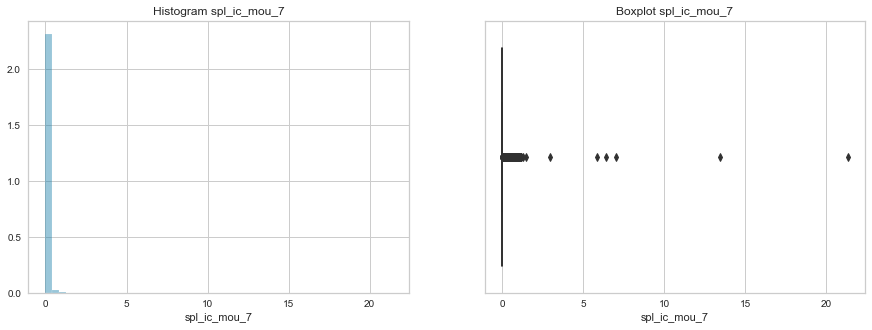

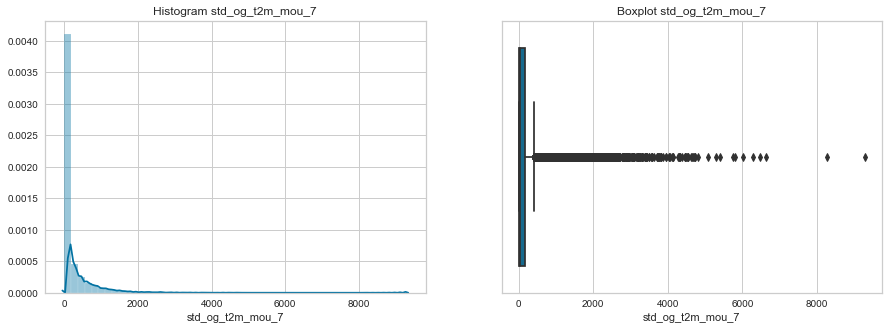

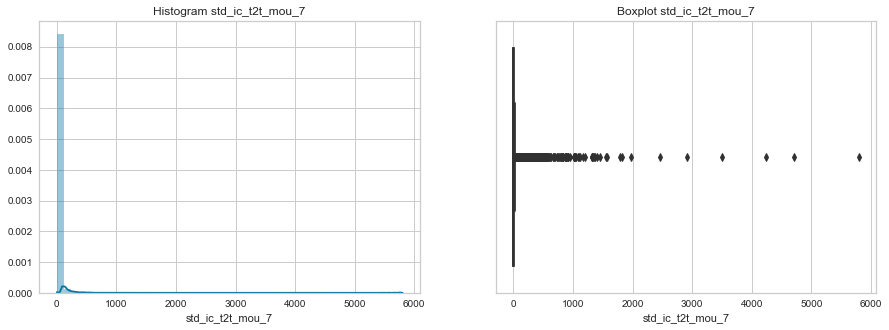

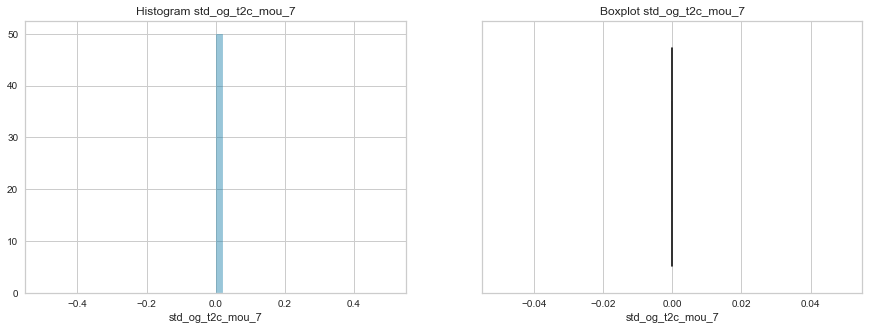

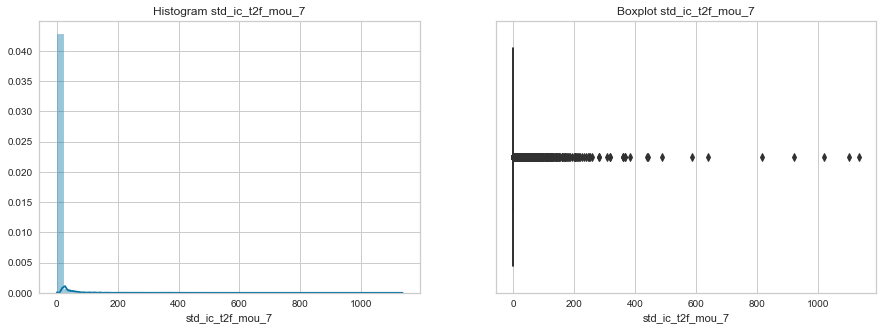

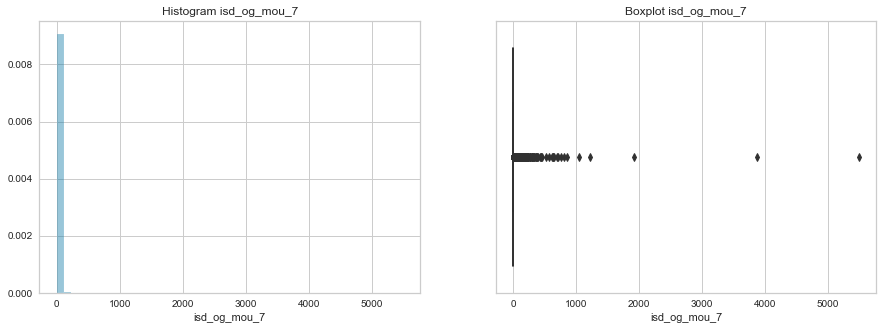

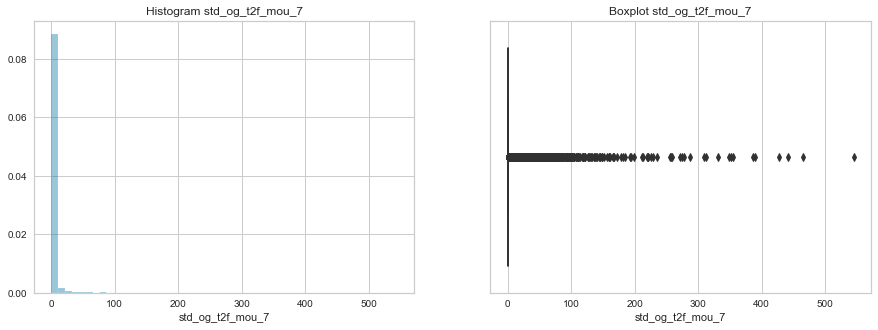

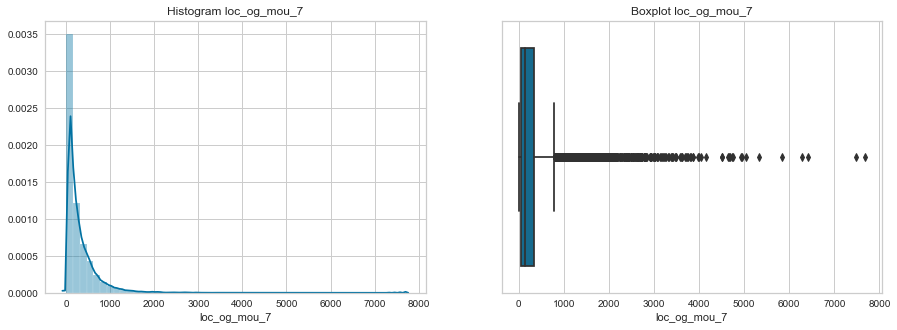

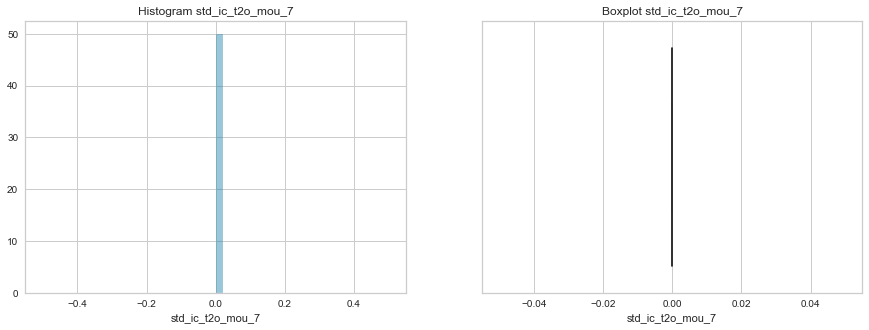

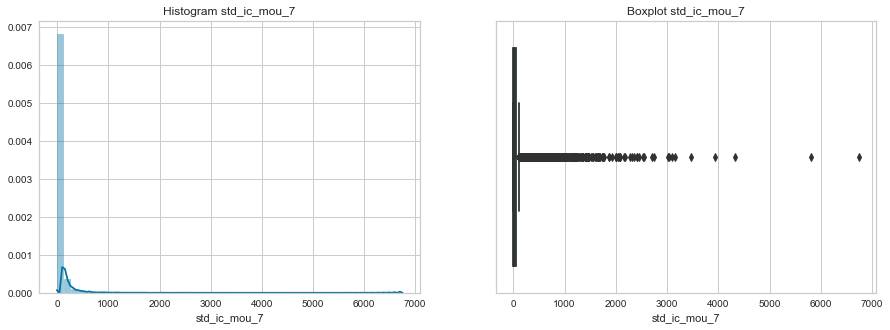

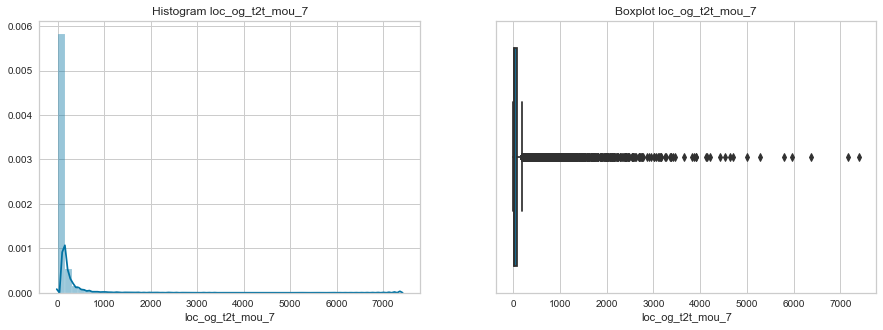

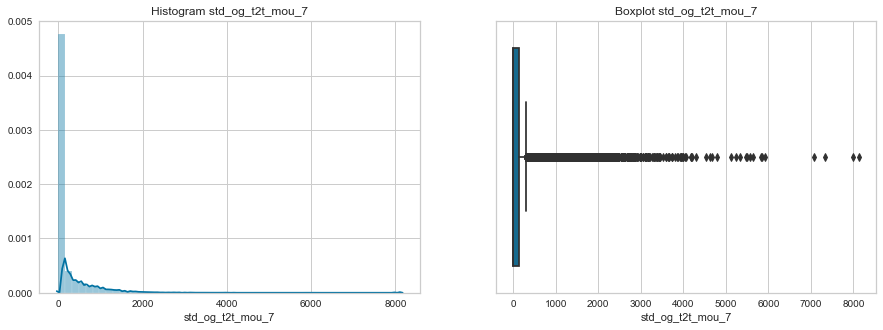

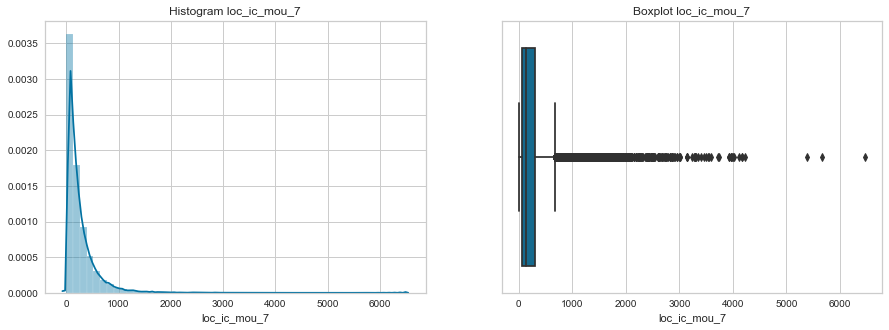

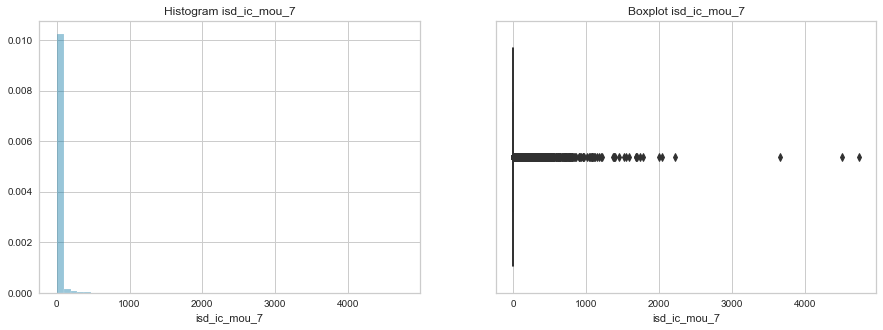

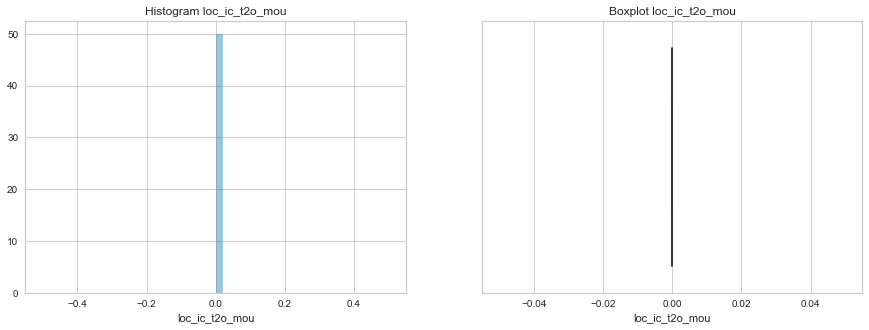

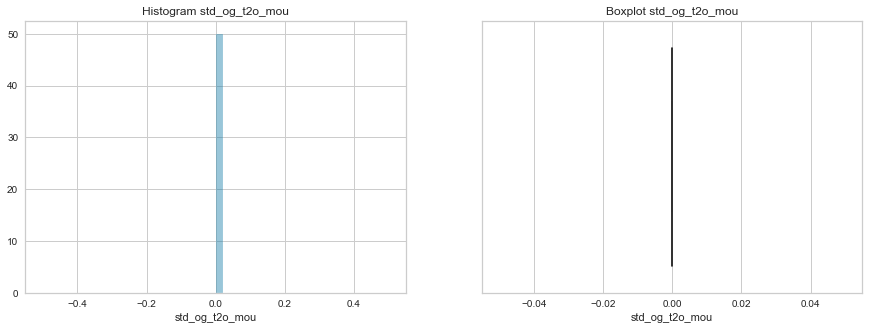

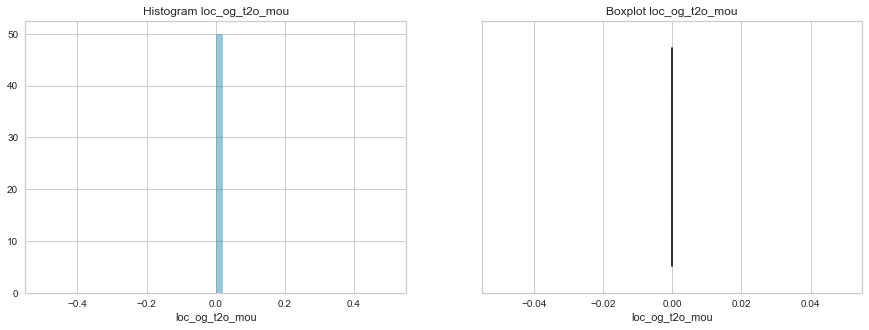

In [62]:
for col in missing_data['columns'].values:
    fig, axes = plt.subplots(1,2,figsize=(15, 5))
    axes[0].set_title('Histogram %s' %col)
    axes[1].set_title('Boxplot %s' %col)
    sns.distplot(tagged_churn_df[col], ax=axes[0])
    sns.boxplot(tagged_churn_df[col], ax=axes[1])
    plt.show()

Data is skewed for most of the features. This is due to the presence of outliers in the data.

### Replacing missing values with median value

In [63]:
for col in missing_data['columns'].values:
    median_val = tagged_churn_df[col].median()
    tagged_churn_df[col] = tagged_churn_df[col].fillna(median_val)
    
print('Missing values replaced with median')

Missing values replaced with median


In [64]:
get_missing_report(tagged_churn_df)

columns  missing_perc     type
0       mobile_number           0.0    int64
104  total_rech_amt_6           0.0  float64
106  total_rech_amt_8           0.0    int64
107    max_rech_amt_6           0.0    int64
108    max_rech_amt_7           0.0    int64
..                ...           ...      ...
56        og_others_6           0.0  float64
57        og_others_7           0.0  float64
58        og_others_8           0.0  float64
59     total_og_mou_6           0.0  float64
164             churn           0.0    int64

[165 rows x 3 columns]

## Feature Engineering

Combining highly correlated features

In [65]:
tagged_churn_df['av_ic_mou'] = (tagged_churn_df['total_ic_mou_6'] + tagged_churn_df['total_ic_mou_7'] + tagged_churn_df['total_ic_mou_8'])/3

tagged_churn_df['av_og_mou'] = (tagged_churn_df['total_og_mou_6'] + tagged_churn_df['total_og_mou_7'] + tagged_churn_df['total_og_mou_8'])/3

tagged_churn_df['av_recharge_amount'] = (tagged_churn_df['total_rech_amt_6'] + tagged_churn_df['total_rech_amt_7'])/2

tagged_churn_df['av_roam_ic_mou'] = (tagged_churn_df['roam_ic_mou_6'] + tagged_churn_df['roam_ic_mou_7'] + tagged_churn_df['roam_ic_mou_8'])/3

tagged_churn_df['av_roam_og_mou'] = (tagged_churn_df['roam_og_mou_6'] + tagged_churn_df['roam_og_mou_7'] + tagged_churn_df['roam_og_mou_8'])/3

tagged_churn_df['av_onnet_mou'] = (tagged_churn_df['onnet_mou_6'] + tagged_churn_df['onnet_mou_7'] + tagged_churn_df['onnet_mou_8'])/3

tagged_churn_df['av_offnet_mou'] = (tagged_churn_df['offnet_mou_6'] + tagged_churn_df['offnet_mou_7'] + tagged_churn_df['offnet_mou_8'])/3

tagged_churn_df['av_vol_2g_mb'] = (tagged_churn_df['vol_2g_mb_6'] + tagged_churn_df['vol_2g_mb_7'] + tagged_churn_df['vol_2g_mb_8'])/3

tagged_churn_df['av_night_pck_user'] = (tagged_churn_df['night_pck_user_6'] + tagged_churn_df['night_pck_user_7'] + tagged_churn_df['night_pck_user_8'])/3

tagged_churn_df['av_sachet_2g'] = (tagged_churn_df['sachet_2g_6'] + tagged_churn_df['sachet_2g_7'] + tagged_churn_df['sachet_2g_8'])/3

tagged_churn_df['av_vol_3g_mb'] = (tagged_churn_df['vol_3g_mb_6'] + tagged_churn_df['vol_3g_mb_7'] + tagged_churn_df['vol_3g_mb_8'] + tagged_churn_df['arpu_3g_6'] + tagged_churn_df['arpu_3g_7'] + tagged_churn_df['arpu_3g_8'] + tagged_churn_df['arpu_2g_6'] + tagged_churn_df['arpu_2g_7'] + tagged_churn_df['arpu_2g_8'])/9

In [66]:
cols_to_drop = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8',
               'total_rech_amt_6', 'total_rech_amt_7', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
               'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
               'offnet_mou_7', 'offnet_mou_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'night_pck_user_6', 'night_pck_user_7',
               'night_pck_user_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_3g_6', 
                'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']

In [67]:
tagged_churn_df.drop(cols_to_drop, axis=1, inplace=True)

In [68]:
tagged_churn_df.shape

(30001, 138)

Dropping columns having more than 70% zeros

In [69]:
perc_zeros_df = ((tagged_churn_df[tagged_churn_df == 0].count() / len(tagged_churn_df))*100).rename_axis('columns').to_frame('perc_zeros').reset_index()

In [70]:
perc_zeros_df

columns  perc_zeros
0        mobile_number    0.000000
1            circle_id    0.000000
2       loc_og_t2o_mou  100.000000
3       std_og_t2o_mou  100.000000
4       loc_ic_t2o_mou  100.000000
..                 ...         ...
133      av_offnet_mou    0.879971
134       av_vol_2g_mb   37.875404
135  av_night_pck_user   97.646745
136       av_sachet_2g   56.804773
137       av_vol_3g_mb    1.099963

[138 rows x 2 columns]

Dropping features having more than 70% zeros

In [71]:
zero_value_columns = perc_zeros_df[perc_zeros_df['perc_zeros'] >= 70]['columns'].values.tolist()
zero_value_columns

['loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'std_ic_t2f_mou_6',
 'std_ic_t2f_mou_7',
 'std_ic_t2f_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'spl_ic_mou_6',
 'spl_ic_mou_7',
 'spl_ic_mou_8',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8',
 'sep_vbc_3g',
 'churn',
 'av_night_pck_user']

In [72]:
zero_value_columns.remove('churn')
zero_value_columns

['loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'std_ic_t2f_mou_6',
 'std_ic_t2f_mou_7',
 'std_ic_t2f_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'spl_ic_mou_6',
 'spl_ic_mou_7',
 'spl_ic_mou_8',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8',
 'sep_vbc_3g',
 'av_night_pck_user']

In [73]:
tagged_churn_df.drop(zero_value_columns, axis=1, inplace=True)
tagged_churn_df.shape

(30001, 91)

In [74]:
tagged_churn_df.columns

Index(['mobile_number', 'circle_id', 'arpu_6', 'arpu_7', 'arpu_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8',
       'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
       'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_t2t_mou_6',
       'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6',
       'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_mou_6', 'std_ic_mou_7',
       'std_ic_mou

### Scaling data

In [75]:
std_scaler = StandardScaler()

In [76]:
features_df = tagged_churn_df.drop(['churn', 'mobile_number', 'circle_id'], axis=1)

In [77]:
features_df = pd.DataFrame(std_scaler.fit_transform(features_df), columns=features_df.columns)
features_df

arpu_6    arpu_7    arpu_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0     -0.783934 -0.721110 -0.587295         -0.259659         -0.251083   
1      1.108669  1.644683  5.305036         -0.146776         -0.227786   
2     -0.390267 -0.142900 -0.739582          0.927995          0.546856   
3     -0.095603  0.077060  0.257319         -0.351942         -0.332703   
4     -1.051034 -0.764712 -0.282161         -0.157404         -0.147581   
...         ...       ...       ...               ...               ...   
29996 -0.378121 -0.636509 -0.229352         -0.054318         -0.237521   
29997 -0.499089 -0.745809 -0.776747          1.482831          0.398093   
29998  0.187746 -0.220010  0.111038          2.730272          1.705637   
29999 -0.533902 -0.099736 -0.212207          0.373203          0.251035   
30000 -0.511253 -0.536500  0.195674         -0.371536         -0.358329   

       loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0             -0.347802         -0.338671         -0.343761         -0.666108   
1             -0.170437          0.577125          1.174732          0.032757   
2             -0.292805         -0.335784         -0.389872         -0.448456   
3             -0.245029         -0.292277         -0.317829         -0.214740   
4             -0.199939         -0.327844         -0.338259         -0.026329   
...                 ...               ...               ...               ...   
29996          0.045105         -0.451065         -0.596203         -0.426708   
29997         -0.322659         -0.588400         -0.597988         -0.618822   
29998          2.816238          1.644932          1.587724          1.459082   
29999         -0.336970         -0.107747         -0.065159         -0.114828   
30000         -0.347802         -0.660416         -0.682945         -0.666108   

       loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_mou_6  \
0             -0.281888         -0.283349         -0.301836     -0.336951   
1              2.521576          2.219986          2.427634      0.439430   
2             -0.286861         -0.292919         -0.301836      0.322579   
3             -0.252959         -0.292919         -0.220818     -0.422621   
4             -0.286861         -0.292919         -0.301836     -0.330163   
...                 ...               ...               ...           ...   
29996         -0.286861         -0.292919         -0.006481     -0.349174   
29997         -0.286861         -0.292919         -0.301836      0.491929   
29998          0.449037          0.594846          0.365277      2.768149   
29999         -0.286861         -0.292919         -0.301836      0.137028   
30000         -0.286861         -0.292919         -0.301836     -0.679921   

       loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         -0.333402     -0.666006         -0.402640         -0.406006   
1          0.738673      0.042467         -0.400312         -0.358542   
2          0.082007     -0.491401         -0.122304         -0.097025   
3         -0.436660     -0.306660         -0.168440         -0.114809   
4         -0.330864     -0.161525         -0.410961         -0.413841   
...             ...           ...               ...               ...   
29996     -0.554642     -0.248910         -0.395731         -0.413841   
29997     -0.147517     -0.619779         -0.410961         -0.413841   
29998      2.151173      2.727096         -0.169481         -0.287500   
29999      0.100927     -0.304610         -0.337633         -0.347406   
30000     -0.688097     -0.666006         -0.410961         -0.413841   

       std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  \
0             -0.373543         -0.395173         -0.393290         -0.385971   
1             -0.343332         -0.317632         -0.360971         -0.265800   
2             -0.316743         -0.406166         -0.411075         -0.200872   
3        

## Model Training

### Train test split

In [78]:
X_train, X_test, y_train, y_test = train_test_split(features_df, tagged_churn_df['churn'].values, test_size=0.3, random_state=123)

### Handle data imbalance

In [79]:
#smote for synthetic oversampling of data to maintain data balance
smote = SMOTE()

In [80]:
X_train, y_train = smote.fit_sample(X_train, y_train)

In [81]:
len(X_train)

38588

In [82]:
len(y_train)

38588

In [83]:
len(y_train[y_train == 0])

19294

In [84]:
len(y_train[y_train == 1])

19294

### Performing PCA on train data

In [85]:
pca = PCA(0.95)

In [86]:
pca.fit(X_train)

PCA(n_components=0.95)

In [87]:
comp_arr = pca.components_
comp_arr

array([[ 1.67253790e-01,  1.89790612e-01,  1.83895837e-01, ...,
        -5.25590216e-02, -1.11239357e-01,  2.03991573e-02],
       [ 7.01663092e-02,  6.47024635e-02,  8.94626917e-03, ...,
        -5.38439941e-02, -4.94159761e-02, -1.23776672e-01],
       [ 5.91971931e-02,  4.20423261e-02,  2.66683199e-02, ...,
        -6.28337196e-02, -2.42766311e-01,  1.12327898e-01],
       ...,
       [-2.62080918e-01,  9.37379956e-02,  9.72959339e-02, ...,
        -3.09351247e-02, -1.87363123e-02,  2.61834910e-02],
       [-6.16139301e-03,  2.08887799e-01,  1.23683767e-01, ...,
         7.26922601e-05,  6.18831382e-02, -8.74867641e-02],
       [ 1.47939608e-01,  4.57688997e-02, -5.52912382e-02, ...,
         2.95107172e-02,  2.11871530e-02, -3.90965785e-02]])

In [88]:
comp_arr.shape

(45, 88)

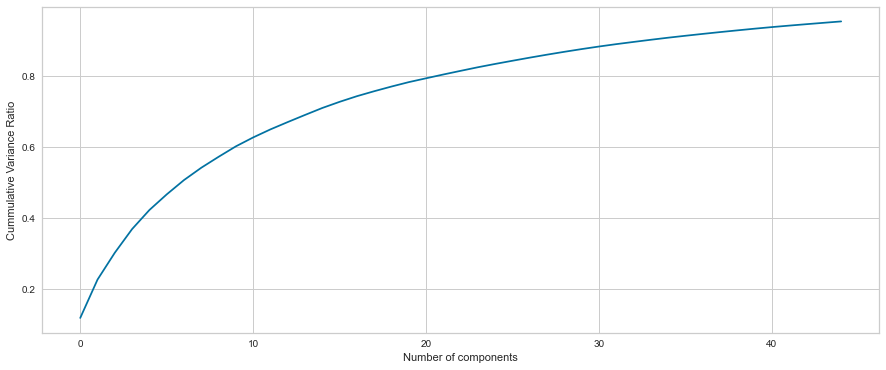

In [89]:
plt.figure(figsize = (15, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cummulative Variance Ratio')
plt.show()

30 components is able to explain 90% of variance in the data. We can select n_components=30.

In [90]:
pca = PCA(n_components=30)
pca.fit(X_train)

PCA(n_components=30)

In [91]:
X_train_pca = pca.transform(X_train)

In [92]:
X_train_pca

array([[ 3.26878789, -3.16136938, -2.04148049, ...,  0.64035283,
         0.01383326, -0.36039468],
       [ 2.3995165 , -1.57415903, -0.56825194, ..., -0.2472655 ,
         0.07827491, -0.18715276],
       [-3.35969751, -1.1508356 ,  1.42177899, ...,  1.0339126 ,
        -0.09321093,  0.35680828],
       ...,
       [-1.04074705,  3.11526679,  0.75200618, ...,  0.09296667,
         0.23008707, -0.08866341],
       [-3.45624922, -0.69374513, -0.73795809, ...,  0.59156639,
        -0.41051754, -0.16701798],
       [-1.01220676,  3.09327624,  1.34328735, ...,  0.22171233,
         0.30493999, -0.21107817]])

In [93]:
X_train_pca.shape

(38588, 30)

In [94]:
X_test_pca = pca.transform(X_test)
X_test_pca.shape

(9001, 30)

In [95]:
train_pca_df = pd.DataFrame(X_train_pca, columns=['component_'+str(x) for x in list(range(X_train_pca.shape[1]))])
train_pca_df.head()

component_0  component_1  component_2  component_3  component_4  \
0     3.268788    -3.161369    -2.041480    -2.788488     0.242754   
1     2.399517    -1.574159    -0.568252    -1.676397    -1.201293   
2    -3.359698    -1.150836     1.421779    -0.544221     0.190690   
3     0.907519     1.161312     2.761596     1.499063     0.152562   
4    -4.070399    -0.615740    -1.650638    -0.048699     0.165334   

   component_5  component_6  component_7  component_8  component_9  \
0    -0.509466     0.689683    -1.152464    -1.371265    -2.964217   
1     0.727996    -1.827067     0.843881     3.084340    -0.064632   
2    -0.757002     0.114080     0.143701     0.418670    -0.057328   
3     8.878553    -0.304100    -2.989523    -0.672367    -2.371137   
4     0.472543     0.009428     0.643344     0.509867    -0.539017   

   component_10  component_11  component_12  component_13  component_14  \
0      0.667896     -1.680976      0.673004      0.291209      0.195832   
1      0.614145      1.895079     -1.808030      1.158578      0.039180   
2      0.131251      0.373041     -0.131151     -0.405337      0.086354   
3      1.919047      1.039915     -1.982291     -0.403426      0.372958   
4      0.148316      0.252937      0.079818      0.079465      0.335509   

   component_15  component_16  component_17  component_18  component_19  \
0     -1.096185     -0.096737     -1.098427     -0.451713      0.187539   
1      1.067351     -0.385943      0.611326     -0.362525     -0.013884   
2     -0.047979     -0.595649     -0.665235      0.599241      0.004373   
3     -0.093912     -0.618034     -1.523063     -0.198119      0.019370   
4     -0.119450      0.477273     -0.452498     -0.043017     -0.503069   

   component_20  component_21  component_22  component_23  component_24  \
0     -0.946197     -3.060841     -1.255896     -0.810084     -0.196821   
1     -0.142936     -2.092631     -0.859164     -0.992379      0.283955   
2      0.235935      0.157330      0.577659     -0.964734      0.296913   
3      0.715889     -0.119919      0.060201      0.222708      0.425940   
4     -0.036140      0.271964      0.615514     -0.597496     -0.508559   

   component_25  component_26  component_27  component_28  component_29  
0      0.425159     -0.408004      0.640353      0.013833     -0.360395  
1     -1.487217     -0.339053     -0.247265      0.078275     -0.187153  
2      0.658634     -0.384743      1.033913     -0.093211      0.356808  
3     -0.096902      0.530805      0.053502      0.325797     -0.244367  
4      0.252443     -0.168843      1.011389     -0.569922     -0.797010

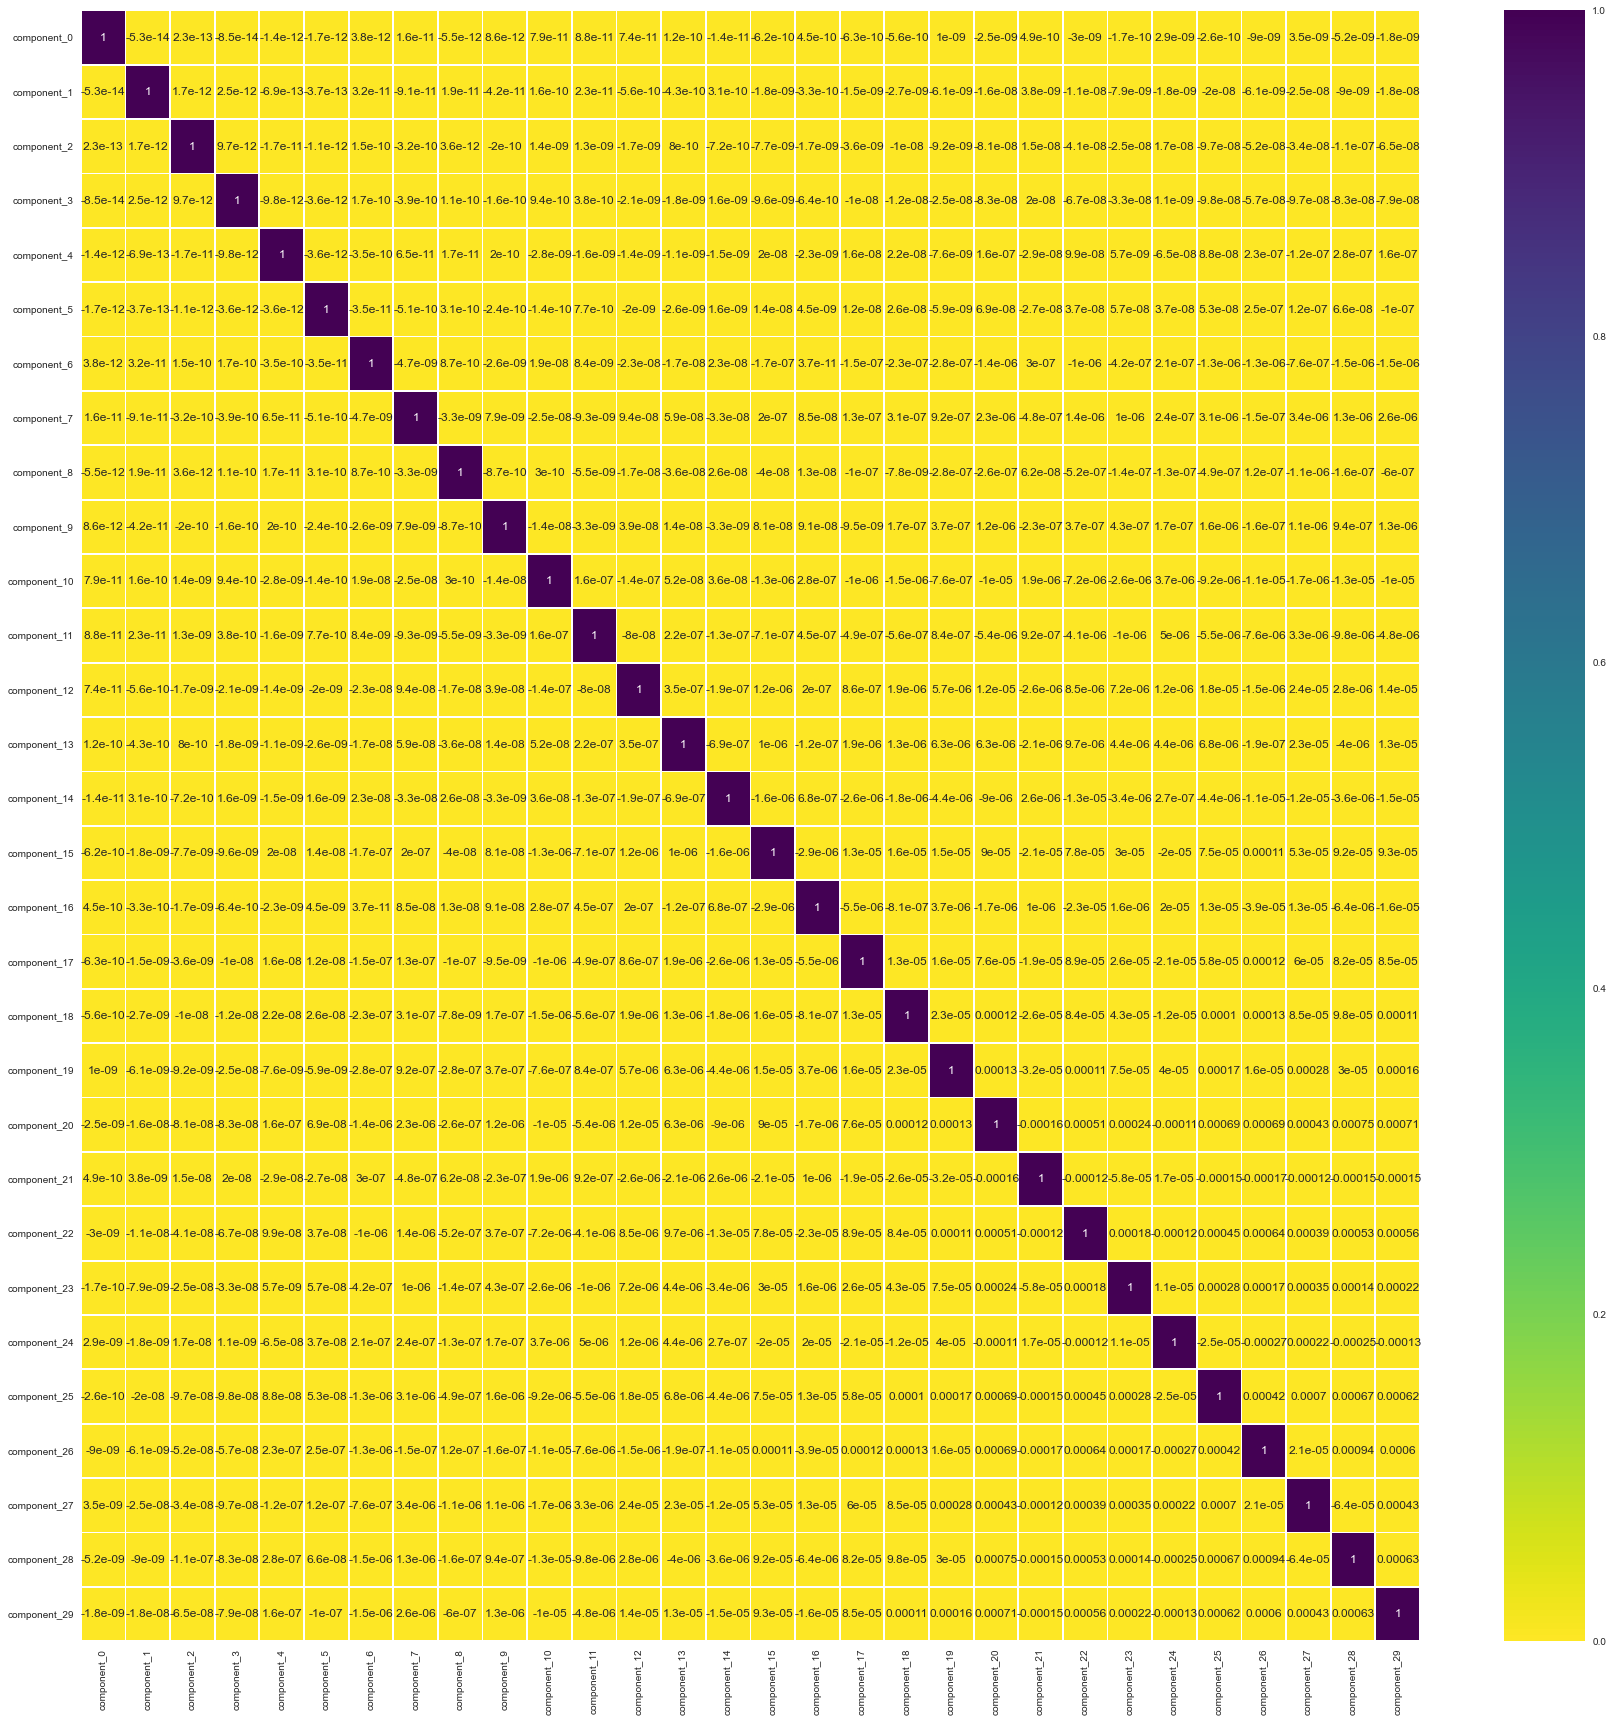

In [96]:
plt.figure(figsize=(30,30))
sns.heatmap(train_pca_df.corr(), cmap='viridis_r', annot=True, linecolor='white', linewidths=0.8)
plt.show()

No correlation between the components which is good.

### Train logistic regression model on PCA data

In [97]:
#logistic regression model
lr = LogisticRegression()

In [98]:
#hyperparameter
lr_params = {'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'liblinear'], 'C': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]}

In [99]:
#gridsearch for hyperparameter tuning
#StratifiedKFold for model cross-validation (to handle overfitting)
grid_model_lr = GridSearchCV(estimator=lr, param_grid=lr_params, cv=StratifiedKFold(), verbose=3, n_jobs=2)

In [100]:
#fitting the model
grid_model_lr.fit(X_train_pca, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  50 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:    6.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear']},
             verbose=3)

In [101]:
# best logistic regression parameters
grid_model_lr.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

In [102]:
# test predictions
y_pred_lr = grid_model_lr.predict(X_test_pca)

In [103]:
# test probabilities
y_pred_prob_lr = grid_model_lr.predict_proba(X_test_pca)

In [104]:
#Function for Model Summary
def show_model_summary(y_true, y_pred, y_pred_prob):

        print('Classification Report: ')
        print(classification_report(y_true, y_pred))
        print('Confusion Matrix: ')
        print(confusion_matrix(y_true, y_pred))
        print('Logloss: ', log_loss(y_true, y_pred_prob[:, 1]))
        print('R-Squared' , r2_score(y_true,y_pred))
             
        auc_score = roc_auc_score(y_true, y_pred_prob[:, 1])
        print('auc: ', auc_score)

In [105]:
show_model_summary(y_test, y_pred_lr, y_pred_prob_lr)

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      8266
           1       0.26      0.80      0.40       735

    accuracy                           0.80      9001
   macro avg       0.62      0.80      0.64      9001
weighted avg       0.92      0.80      0.84      9001

Confusion Matrix: 
[[6624 1642]
 [ 146  589]]
Logloss:  0.4418728321430391
R-Squared -1.6489608279798733
auc:  0.8634832302144183


#### Logistic Regression on PCA data (Results)

- We have achieved 80% accuracy and churn recall is around 80%.

- AUC score is 86.4% and logloss is 0.44
- R-Squared is -1.64

In [106]:
#Function for Plotting AUC-ROC curve
def plot_roc_auc(trained_model, X_test, y_test):
    plt.figure(figsize=(10,8))
    visualizer = ROCAUC(trained_model, classes=['not_churn', 'churn'])
    visualizer.score(X_test, y_test)    
    visualizer.show()
    plt.show()

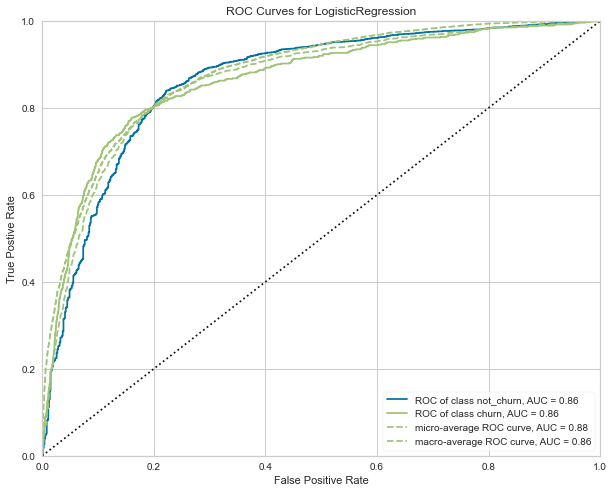

In [107]:
# roc-auc curve
plot_roc_auc(grid_model_lr.best_estimator_, X_test_pca, y_test)

In [108]:
#Function for getting feature importances
def get_importance(features, importances):
    feature_importance_df = pd.DataFrame({'features': features, 'importances': importances})

    plt.figure(figsize=(25,5))
    plt.bar(features, importances)
    plt.tight_layout()
    plt.xticks(rotation=90)
    plt.show()
    
    return feature_importance_df

In [109]:
#Setting parameters for plotting graph
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

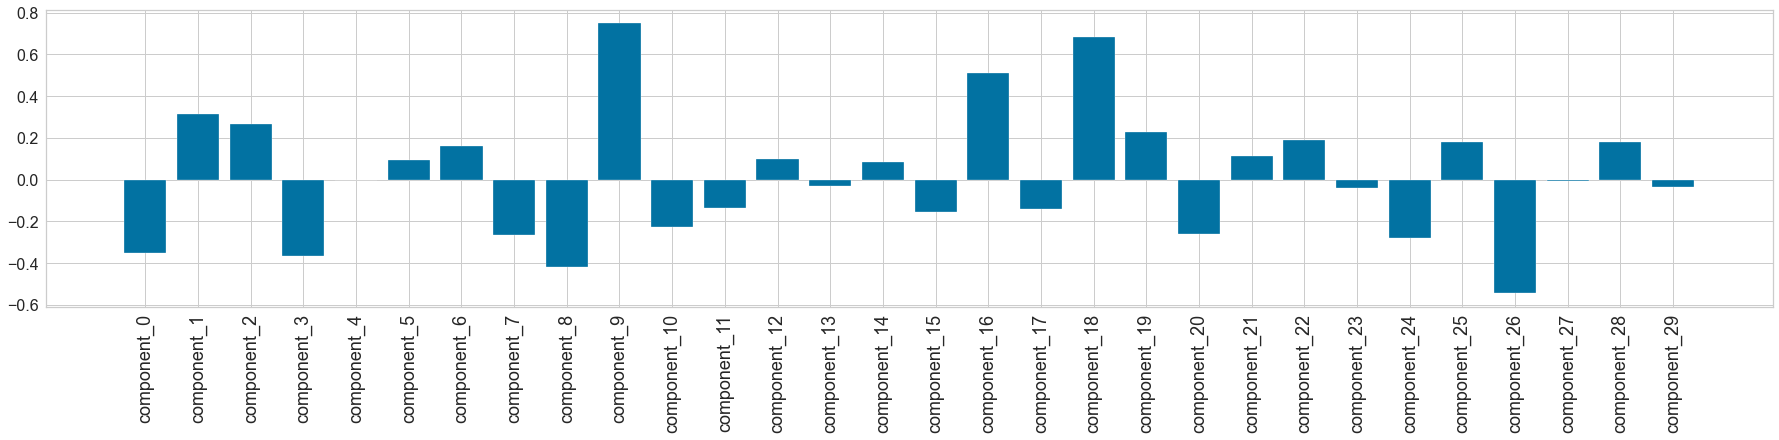

features  importances
0    component_0    -0.352952
1    component_1     0.312374
2    component_2     0.266220
3    component_3    -0.363325
4    component_4    -0.001127
5    component_5     0.094269
6    component_6     0.162121
7    component_7    -0.264326
8    component_8    -0.418487
9    component_9     0.748903
10  component_10    -0.226087
11  component_11    -0.134752
12  component_12     0.100418
13  component_13    -0.031749
14  component_14     0.083688
15  component_15    -0.155614
16  component_16     0.513154
17  component_17    -0.140039
18  component_18     0.682789
19  component_19     0.227081
20  component_20    -0.260316
21  component_21     0.115487
22  component_22     0.191937
23  component_23    -0.038245
24  component_24    -0.280158
25  component_25     0.182834
26  component_26    -0.543898
27  component_27    -0.005209
28  component_28     0.182334
29  component_29    -0.035992

In [110]:
# logistic regression feature importance
get_importance(['component_'+str(x) for x in list(range(X_train_pca.shape[1]))], grid_model_lr.best_estimator_.coef_[0])

### Ensemble models on PCA data

In [111]:
# initializing ensemble models

rf_model = RandomForestClassifier(random_state = 23)
adaboost_model = AdaBoostClassifier(random_state = 23)
gboost_model = GradientBoostingClassifier(random_state = 23)
xgboost_model = XGBClassifier(random_state = 23)

In [112]:
# individual model hyperparameters
rf_params = {'n_estimators':[100, 200], 'max_depth':[2,3,4], 'min_samples_split':[2, 4, 6], 'min_samples_leaf':[2,3,4]}
ada_params = {'n_estimators':[50, 100], 'learning_rate':[1e-2, 0.1, 1.0]}
gbm_params = {'n_estimators':[50, 100], 'learning_rate':[1e-2, 0.1, 1.0], 'max_depth':[2,3,4], 'min_samples_split':[2, 4, 6], 'min_samples_leaf':[2,3,4]}
xgb_params = {'learning_rate':[1e-2, 0.1, 1.0], 'max_depth':[2,3,4], 'reg_alpha': [1e-2, 0.1], 'reg_lambda': [1e-2, 0.1]}

In [113]:
# storing model object and hyperparameters in a dictionary
model_dict = {'random_forest': [rf_model, rf_params], 
              'ada_boost': [adaboost_model, ada_params], 
              'gradient_boost': [gboost_model, gbm_params], 
              'xgboost': [xgboost_model, xgb_params]}

In [114]:
# list to store best model and results
trained_models = []

# train each ensemble model one by one
# tqdm to show progress
for model_name in tqdm(model_dict):
    
    print('Training %s model ' %model_name)
    model_entity = model_dict[model_name]
    estimator = model_entity[0]
    estimator_params = model_entity[1]
    
    # Grid search for hyperparameter tuning
    # Randomized search for faster hyperparameter tuning
    # StratiedfiedKFold for model cross-validation
#     estimator_grid_model = GridSearchCV(estimator=estimator, param_grid=estimator_params, cv=StratifiedKFold(), n_jobs=2)
    estimator_grid_model = RandomizedSearchCV(estimator=estimator, param_distributions=estimator_params, cv=StratifiedKFold(), n_jobs=2)
    estimator_grid_model.fit(X_train_pca, y_train)
    print('\n %s Model training complete.' %model_name)
    # get test results
    y_pred_grid_model = estimator_grid_model.predict(X_test_pca)
    # get test probabilities
    y_pred_prob_grid_model = estimator_grid_model.predict_proba(X_test_pca)
    # store model name with best estimator and results in a dict object
    trained_model_dict = {}
    trained_model_dict['model_name'] = model_name
    trained_model_dict['best_estimator'] = estimator_grid_model.best_estimator_
    trained_model_dict['y_pred'] = y_pred_grid_model
    trained_model_dict['y_pred_prob'] = y_pred_prob_grid_model
    # append to results to list
    trained_models.append(trained_model_dict)
    
# trained_models

  0%|                                                                                                       | 0/4 [00:00<?, ?it/s]

Training random_forest model 

 random_forest Model training complete.


 25%|███████████████████████▌                                                                      | 1/4 [03:47<11:23, 227.75s/it]

Training ada_boost model 

 ada_boost Model training complete.


 50%|███████████████████████████████████████████████                                               | 2/4 [07:09<07:19, 219.85s/it]

Training gradient_boost model 


 75%|██████████████████████████████████████████████████████████████████████▌                       | 3/4 [21:22<06:49, 409.82s/it]


 gradient_boost Model training complete.
Training xgboost model 


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [23:06<00:00, 346.55s/it]


 xgboost Model training complete.




Showing summary for random_forest model
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      8266
           1       0.28      0.71      0.40       735

    accuracy                           0.82      9001
   macro avg       0.62      0.77      0.65      9001
weighted avg       0.91      0.82      0.86      9001

Confusion Matrix: 
[[6898 1368]
 [ 213  522]]
Logloss:  0.5100808452957235
R-Squared -1.3422858327942842
auc:  0.8413181774040369
ROC-AUC curve for random_forest model


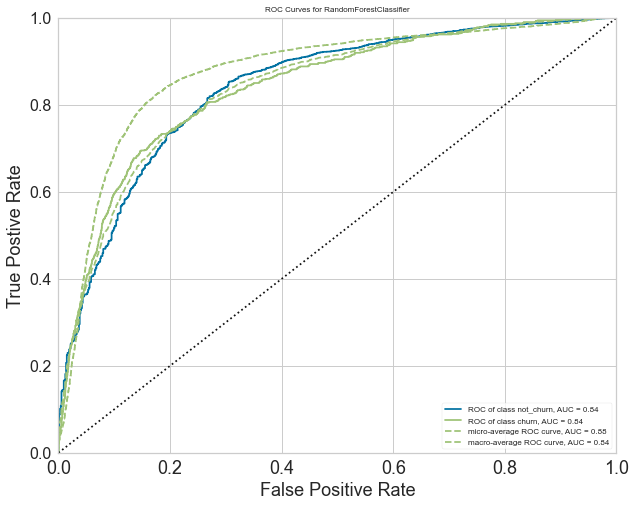

Feature Importance for random_forest model


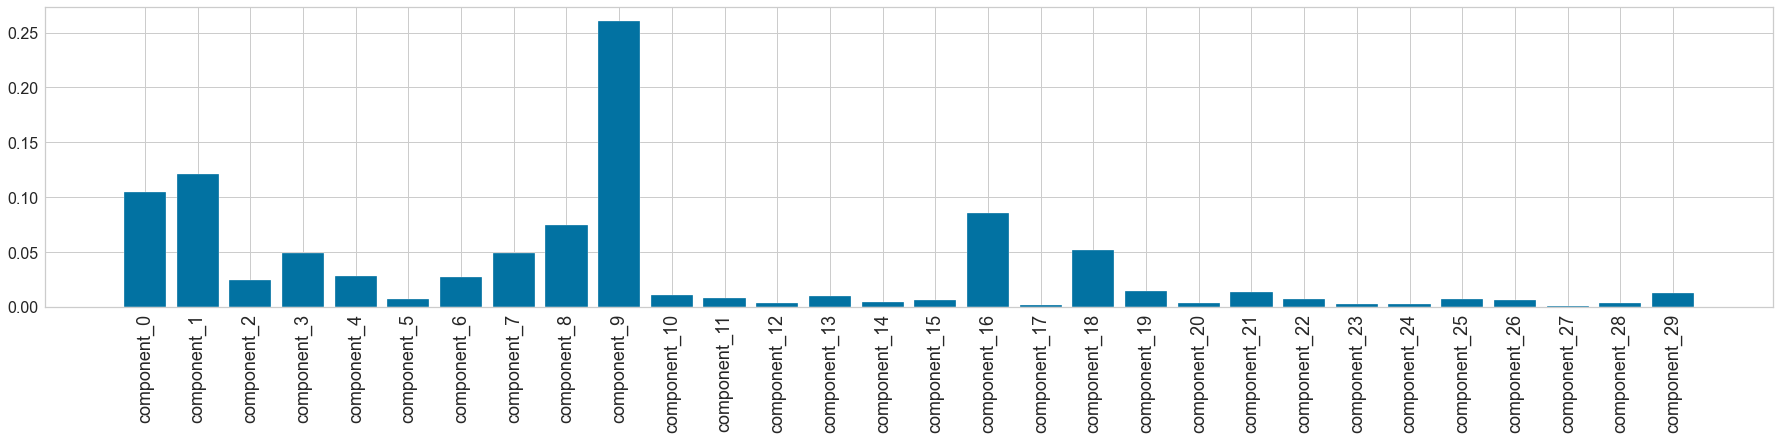





Showing summary for ada_boost model
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      8266
           1       0.27      0.76      0.40       735

    accuracy                           0.82      9001
   macro avg       0.62      0.79      0.65      9001
weighted avg       0.92      0.82      0.85      9001

Confusion Matrix: 
[[6776 1490]
 [ 174  561]]
Logloss:  0.6838565248660289
R-Squared -1.4652521352116943
auc:  0.8465910680749436
ROC-AUC curve for ada_boost model


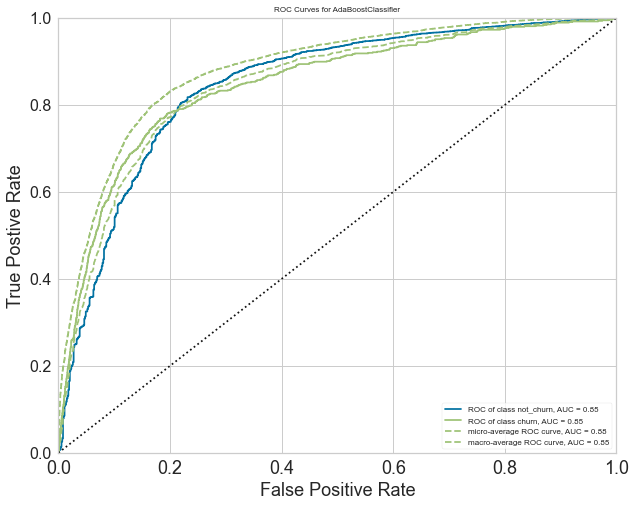

Feature Importance for ada_boost model


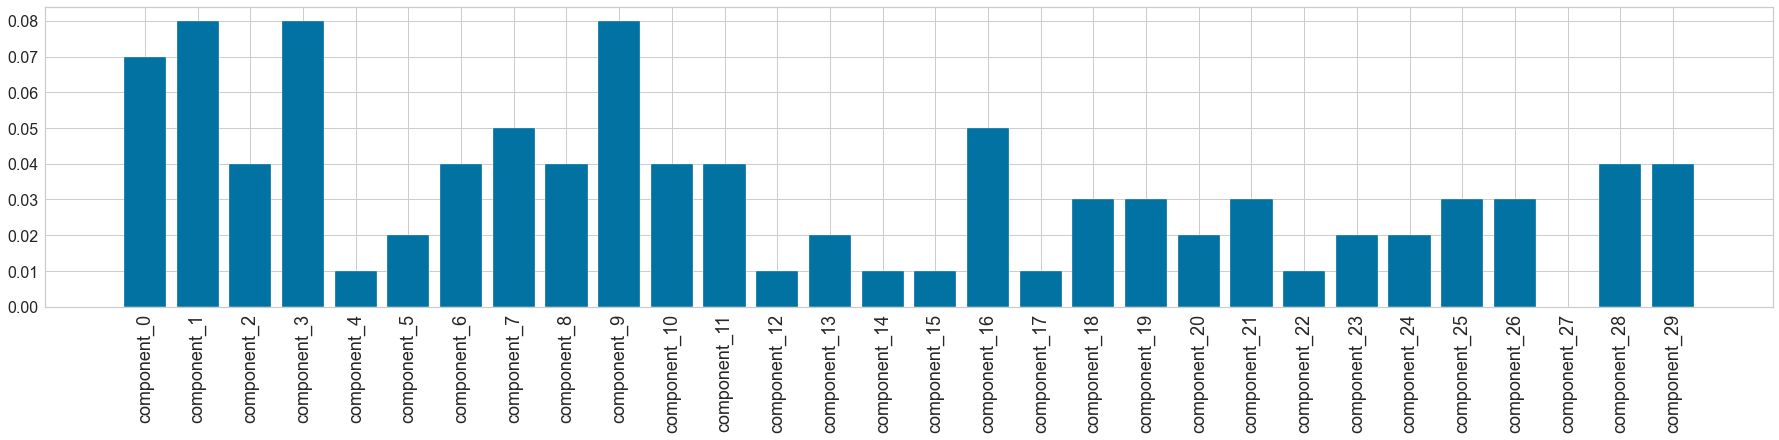





Showing summary for gradient_boost model
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      8266
           1       0.32      0.62      0.43       735

    accuracy                           0.86      9001
   macro avg       0.64      0.75      0.67      9001
weighted avg       0.91      0.86      0.88      9001

Confusion Matrix: 
[[7314  952]
 [ 278  457]]
Logloss:  0.429514855058716
R-Squared -0.8222717105230672
auc:  0.8221069506922053
ROC-AUC curve for gradient_boost model


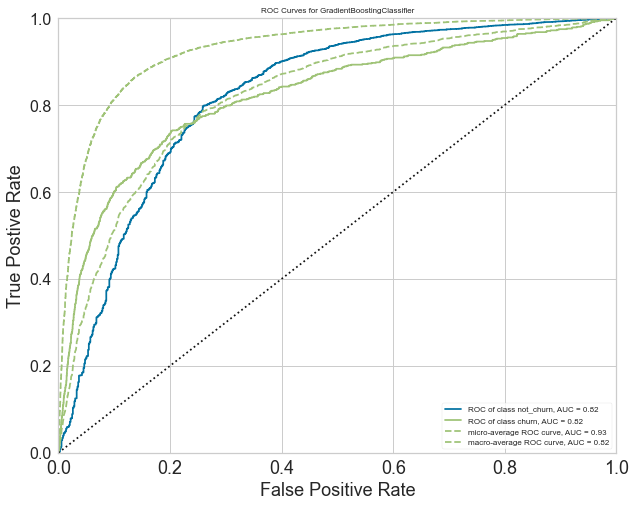

Feature Importance for gradient_boost model


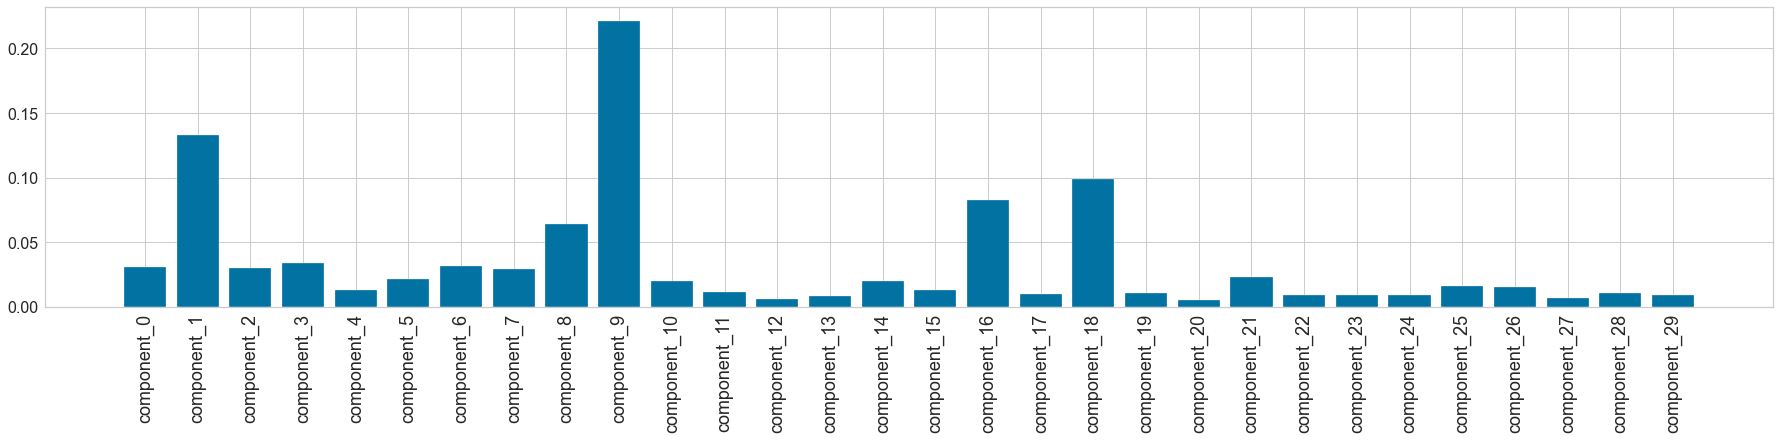





Showing summary for xgboost model
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      8266
           1       0.32      0.63      0.43       735

    accuracy                           0.86      9001
   macro avg       0.64      0.76      0.67      9001
weighted avg       0.91      0.86      0.88      9001

Confusion Matrix: 
[[7286  980]
 [ 269  466]]
Logloss:  0.43127561173971124
R-Squared -0.8504206231246432
auc:  0.8286213009278233
ROC-AUC curve for xgboost model


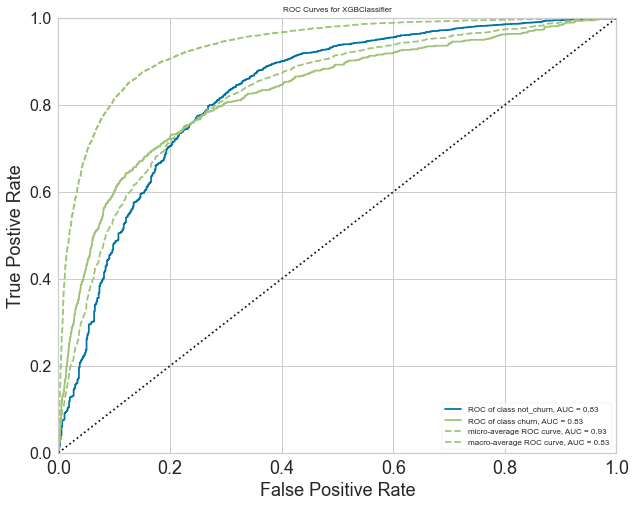

Feature Importance for xgboost model


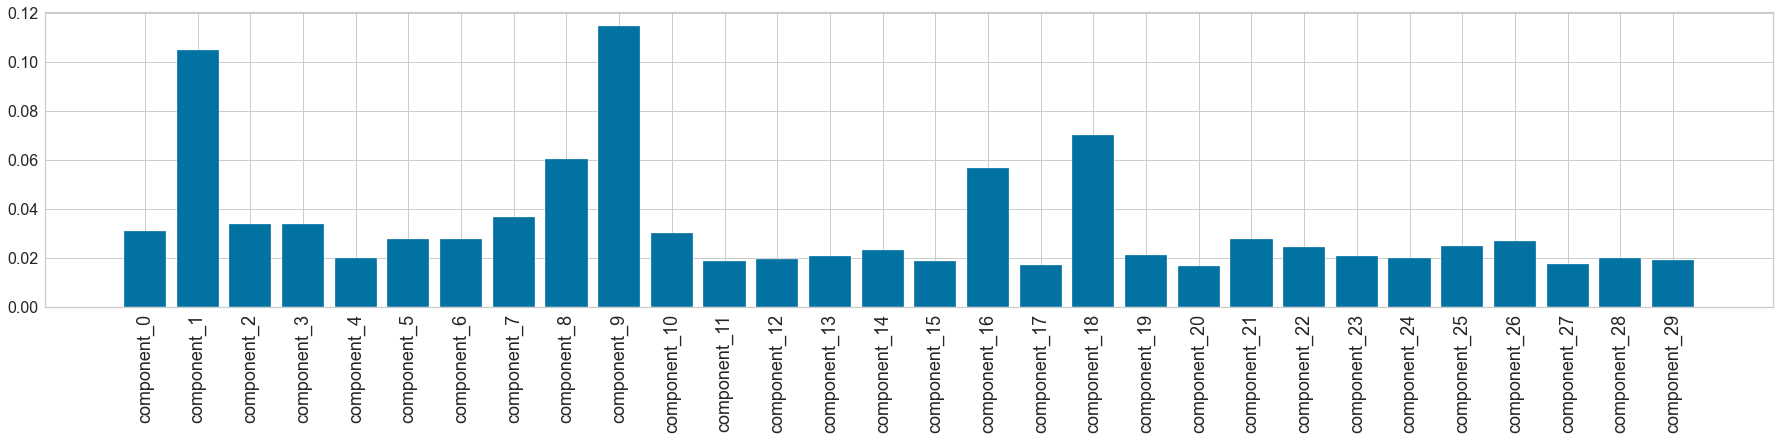

In [115]:

# showing model results one by one
for model_dict in trained_models:
    
    # get model data
    model_name = model_dict['model_name']
    estimator = model_dict['best_estimator']
    y_pred = model_dict['y_pred']
    y_pred_prob = model_dict['y_pred_prob']
    
    print('=====================================================')
    print('\n')
    # show model summary
    print('Showing summary for %s model' %model_name)
    show_model_summary(y_test, y_pred, y_pred_prob)
    
    # plot roc-auc curve
    print('ROC-AUC curve for %s model' %model_name)
    plot_roc_auc(estimator, X_test_pca, y_test)
    
    # plot feature importance
    print('Feature Importance for %s model' %model_name)
    features = ['component_'+str(x) for x in list(range(X_train_pca.shape[1]))]
    get_importance(features, estimator.feature_importances_)
    
    print('\n')

#### Ensemble model on PCA data (Results)

- <b>Random Forest</b> => Accuracy = 82%, Churn Recall = 71%, AUC Score = 84%, logloss = 0.51


- <b>AdaBoost</b> => Accuracy = 82%, Churn Recall = 76%, AUC Score = 85%, logloss = 0.68


- <b>GradientBoosting</b> => Accuracy = 86%, Churn Recall = 62%, AUC Score = 82%, logloss = 0.43


- <b>XGBoost</b> => Accuracy = 86%, Churn Recall = 63%, AUC Score = 82.8%, logloss = 0.43

Above results suggests <b>XGBoost</b> model as the winner in terms of accuracy. 
But <b>AdaBoost</b> model has the best recall value for churn.

Since, we need a model which can better predict churn. Hence we choose the <b> AdaBoost </b> model.

## Modeling using RFE

### Selecting features using RFE

#### Finiding optimal feature selection parameter

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [19:01<00:00, 36.84s/it]


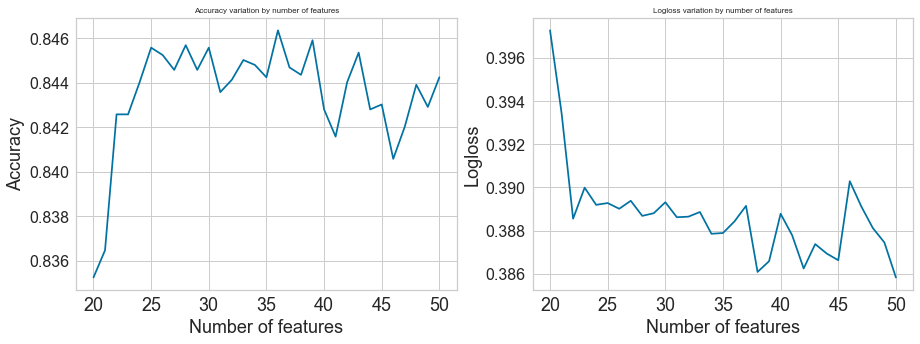

In [116]:
# number of features from 20 to 50
n_features = list(range(20, 51))
accuracies = []
log_losses = []

# tqdm to show progress bar
for i in tqdm(n_features):
    
    # initialize RFE object, logistic regression model as base estimator 
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=i)
    X_train_new = rfe.fit_transform(X_train, y_train)
    X_test_new = rfe.transform(X_test)
    
    # test data
    y_pred = rfe.estimator_.predict(X_test_new)
    y_pred_prob = rfe.estimator_.predict_proba(X_test_new)
    
    # accuracy score and logloss value
    accuracies.append(accuracy_score(y_test, y_pred))
    log_losses.append(log_loss(y_test, y_pred_prob))
    

# plot variation of accuracy and logloss with change in number of features
fig, axes = plt.subplots(1,2, figsize=(15,5))

axes[0].set_xlabel('Number of features')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy variation by number of features')
axes[0].plot(n_features, accuracies)

axes[1].set_xlabel('Number of features')
axes[1].set_ylabel('Logloss')
axes[1].set_title('Logloss variation by number of features')
axes[1].plot(n_features, log_losses)
plt.show()

Model performance doesnot change much after 30 features. So, we can select 30 features only.

In [117]:
# refit rfe with 30 features
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=30)

In [118]:
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=30)

In [119]:
# feature support list
rfe_support = rfe.support_
rfe_support

array([False,  True, False, False, False,  True, False,  True,  True,
       False, False,  True, False,  True,  True,  True, False,  True,
        True, False,  True,  True, False,  True, False, False, False,
       False, False,  True, False, False,  True, False, False,  True,
       False,  True,  True,  True, False,  True,  True, False,  True,
        True, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True,  True,  True, False, False, False])

In [120]:
# ranking list
rfe_ranking = rfe.ranking_
rfe_ranking

array([21,  1, 25, 52, 45,  1, 41,  1,  1, 26, 27,  1, 40,  1,  1,  1, 39,
        1,  1, 17,  1,  1, 46,  1, 58, 33, 32, 49, 20,  1, 44, 48,  1, 38,
       57,  1, 14,  1,  1,  1, 18,  1,  1, 53,  1,  1, 19, 59, 55, 13,  1,
        9, 42, 54, 12, 43, 28,  1, 15,  4,  2, 35, 31, 29, 10,  5,  3, 16,
        6,  1, 47, 37, 30,  7, 24, 36, 50, 11, 56,  1, 22, 34,  1,  1,  1,
       51,  8, 23])

In [121]:
all_features = X_train.columns
all_features

Index(['arpu_6', 'arpu_7', 'arpu_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7',
       'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7',
       'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7',
       'loc_og_t2f_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8',
       'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8',
       'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7',
       'loc_ic_t2f_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8',
       'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8',
       'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_rech_num_6',
       'tota

In [122]:
rfe_features_df = pd.DataFrame({'features': all_features, 'support': rfe_support, 'ranking': rfe_ranking})
rfe_features_df

features  support  ranking
0             arpu_6    False       21
1             arpu_7     True        1
2             arpu_8    False       25
3   loc_og_t2t_mou_6    False       52
4   loc_og_t2t_mou_7    False       45
..               ...      ...      ...
83      av_onnet_mou     True        1
84     av_offnet_mou     True        1
85      av_vol_2g_mb    False       51
86      av_sachet_2g    False        8
87      av_vol_3g_mb    False       23

[88 rows x 3 columns]

In [123]:
rfe_features_df[rfe_features_df['support'] == True]

features  support  ranking
1               arpu_7     True        1
5     loc_og_t2t_mou_8     True        1
7     loc_og_t2m_mou_7     True        1
8     loc_og_t2m_mou_8     True        1
11    loc_og_t2f_mou_8     True        1
13        loc_og_mou_7     True        1
14        loc_og_mou_8     True        1
15    std_og_t2t_mou_6     True        1
17    std_og_t2t_mou_8     True        1
18    std_og_t2m_mou_6     True        1
20    std_og_t2m_mou_8     True        1
21        std_og_mou_6     True        1
23        std_og_mou_8     True        1
29    loc_ic_t2t_mou_8     True        1
32    loc_ic_t2m_mou_8     True        1
35    loc_ic_t2f_mou_8     True        1
37        loc_ic_mou_7     True        1
38        loc_ic_mou_8     True        1
39    std_ic_t2t_mou_6     True        1
41    std_ic_t2t_mou_8     True        1
42    std_ic_t2m_mou_6     True        1
44    std_ic_t2m_mou_8     True        1
45        std_ic_mou_6     True        1
50    total_rech_num_8     True        1
57  last_day_rch_amt_8     True        1
69  av_rech_amt_data_8     True        1
79           av_og_mou     True        1
82      av_roam_og_mou     True        1
83        av_onnet_mou     True        1
84       av_offnet_mou     True        1

In [124]:
# list of 30 features selected by RFE
selected_features = rfe_features_df[rfe_features_df['support'] == True]['features'].values.tolist()
selected_features

['arpu_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_8',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_8',
 'std_og_mou_6',
 'std_og_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_t2t_mou_6',
 'std_ic_t2t_mou_8',
 'std_ic_t2m_mou_6',
 'std_ic_t2m_mou_8',
 'std_ic_mou_6',
 'total_rech_num_8',
 'last_day_rch_amt_8',
 'av_rech_amt_data_8',
 'av_og_mou',
 'av_roam_og_mou',
 'av_onnet_mou',
 'av_offnet_mou']

In [125]:
# new train and test set
X_train_new = rfe.transform(X_train)
X_test_new = rfe.transform(X_test)

In [126]:
X_train_new = pd.DataFrame(X_train_new, columns=selected_features)
X_test_new = pd.DataFrame(X_test_new, columns=selected_features)

### Train logistic regression model on RFE data

In [127]:
# initialize logistic regression model
lr_rfe_model = LogisticRegression()

# GridsearchCV for hyperparameter tuning
# StratifiedKFold for model cross-validation
grid_model_rfe_lr = GridSearchCV(estimator=lr_rfe_model, param_grid=lr_params, cv=StratifiedKFold(), verbose=3, n_jobs=2)

In [128]:
# train model
grid_model_rfe_lr.fit(X_train_new, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  32 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:  2.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear']},
             verbose=3)

In [129]:
# test data
y_pred_rfe_lr = grid_model_rfe_lr.predict(X_test_new)
y_pred_prob_rfe_lr = grid_model_rfe_lr.predict_proba(X_test_new)

In [130]:
show_model_summary(y_test, y_pred_rfe_lr, y_pred_prob_rfe_lr)

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      8266
           1       0.33      0.78      0.47       735

    accuracy                           0.85      9001
   macro avg       0.66      0.82      0.69      9001
weighted avg       0.93      0.85      0.88      9001

Confusion Matrix: 
[[7112 1154]
 [ 160  575]]
Logloss:  0.38165728671965343
R-Squared -0.94671953465635
auc:  0.8907369916270403


#### Logistic Regression model on RFE data (Results)

- Accuracy = 85%, Churn Recall = 78%, AUC Score = 89.07%, logloss = 0.38

This is a good model till now.

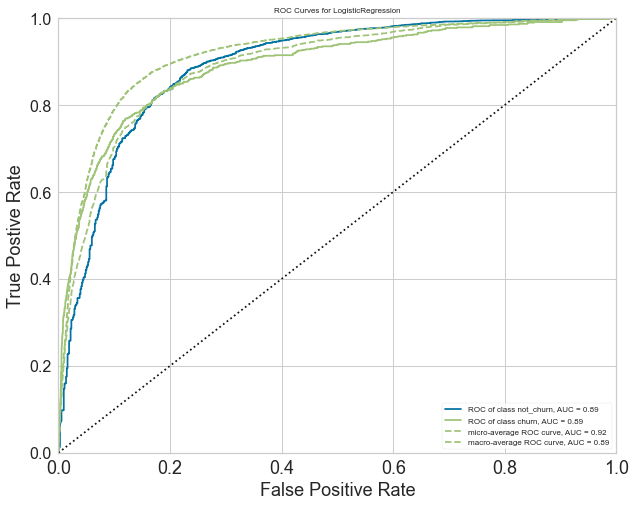

In [131]:
# roc-auc curve
plot_roc_auc(grid_model_rfe_lr.best_estimator_, X_test_new, y_test)

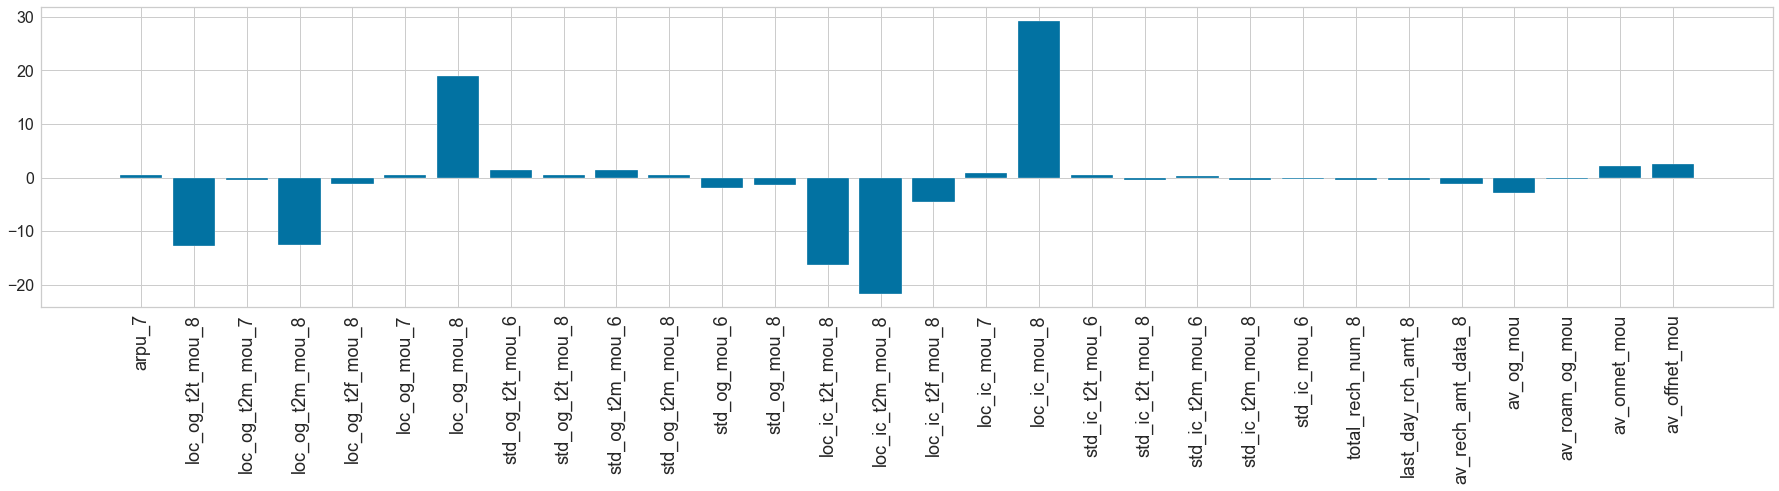

features  importances
0               arpu_7     0.456792
1     loc_og_t2t_mou_8   -12.758151
2     loc_og_t2m_mou_7    -0.439305
3     loc_og_t2m_mou_8   -12.702422
4     loc_og_t2f_mou_8    -1.280647
5         loc_og_mou_7     0.423431
6         loc_og_mou_8    19.044436
7     std_og_t2t_mou_6     1.449970
8     std_og_t2t_mou_8     0.512052
9     std_og_t2m_mou_6     1.353180
10    std_og_t2m_mou_8     0.415438
11        std_og_mou_6    -2.008040
12        std_og_mou_8    -1.365818
13    loc_ic_t2t_mou_8   -16.363181
14    loc_ic_t2m_mou_8   -21.681827
15    loc_ic_t2f_mou_8    -4.598801
16        loc_ic_mou_7     0.788824
17        loc_ic_mou_8    29.314546
18    std_ic_t2t_mou_6     0.429737
19    std_ic_t2t_mou_8    -0.522563
20    std_ic_t2m_mou_6     0.366936
21    std_ic_t2m_mou_8    -0.401436
22        std_ic_mou_6    -0.351740
23    total_rech_num_8    -0.444535
24  last_day_rch_amt_8    -0.448881
25  av_rech_amt_data_8    -1.161932
26           av_og_mou    -2.926280
27      av_roam_og_mou    -0.238429
28        av_onnet_mou     2.161933
29       av_offnet_mou     2.457629

In [132]:
# feature importance plot
get_importance(selected_features, grid_model_rfe_lr.best_estimator_.coef_[0])

### Checking multi-colinearity

In [133]:
vif_df = pd.DataFrame() 
vif_df['features'] = X_train_new.columns 
vif_df['vif_value'] = [variance_inflation_factor(X_train_new.values, i) for i in range(len(X_train_new.columns))]
vif_df = vif_df.sort_values(by='vif_value', ascending=False)
vif_df

features     vif_value
6         loc_og_mou_8  2.416942e+09
17        loc_ic_mou_8  1.477621e+09
3     loc_og_t2m_mou_8  1.009395e+09
1     loc_og_t2t_mou_8  8.635095e+08
14    loc_ic_t2m_mou_8  7.259409e+08
13    loc_ic_t2t_mou_8  3.366901e+08
15    loc_ic_t2f_mou_8  2.616416e+07
4     loc_og_t2f_mou_8  6.837787e+06
12        std_og_mou_8  6.375468e+03
11        std_og_mou_6  6.366355e+03
9     std_og_t2m_mou_6  3.205478e+03
10    std_og_t2m_mou_8  2.892180e+03
7     std_og_t2t_mou_6  2.669730e+03
8     std_og_t2t_mou_8  2.577258e+03
26           av_og_mou  3.927275e+02
29       av_offnet_mou  2.096037e+02
28        av_onnet_mou  1.763470e+02
22        std_ic_mou_6  1.088963e+02
20    std_ic_t2m_mou_6  4.838378e+01
18    std_ic_t2t_mou_6  4.804188e+01
27      av_roam_og_mou  1.679781e+01
5         loc_og_mou_7  1.103464e+01
2     loc_og_t2m_mou_7  9.533595e+00
16        loc_ic_mou_7  3.077078e+00
0               arpu_7  1.963909e+00
23    total_rech_num_8  1.699072e+00
21    std_ic_t2m_mou_8  1.557296e+00
19    std_ic_t2t_mou_8  1.453255e+00
24  last_day_rch_amt_8  1.364228e+00
25  av_rech_amt_data_8  1.289548e+00

Selecting features with vif values less than 10

In [134]:
selected_features2 = vif_df[vif_df['vif_value'] < 10]['features'].values.tolist()
selected_features2

['loc_og_t2m_mou_7',
 'loc_ic_mou_7',
 'arpu_7',
 'total_rech_num_8',
 'std_ic_t2m_mou_8',
 'std_ic_t2t_mou_8',
 'last_day_rch_amt_8',
 'av_rech_amt_data_8']

Adding 'aon' since it is an important feature. Churn probability also depends on the amount of time a customer has stayed with a service. New customers have higher likelihood of leaving the service sooner.

In [135]:
selected_features2.append('aon')
selected_features2

['loc_og_t2m_mou_7',
 'loc_ic_mou_7',
 'arpu_7',
 'total_rech_num_8',
 'std_ic_t2m_mou_8',
 'std_ic_t2t_mou_8',
 'last_day_rch_amt_8',
 'av_rech_amt_data_8',
 'aon']

In [136]:
# new features
X_train_new2 = X_train[selected_features2]
X_test_new2 = X_test[selected_features2]

In [137]:
# check vif
vif_df = pd.DataFrame() 
vif_df['features'] = X_train_new2.columns 
vif_df['vif_value'] = [variance_inflation_factor(X_train_new2.values, i) for i in range(len(X_train_new2.columns))]
vif_df = vif_df.sort_values(by='vif_value', ascending=False)
vif_df

features  vif_value
0    loc_og_t2m_mou_7   1.464611
1        loc_ic_mou_7   1.381825
2              arpu_7   1.261976
6  last_day_rch_amt_8   1.216296
3    total_rech_num_8   1.149619
7  av_rech_amt_data_8   1.124529
8                 aon   1.104112
4    std_ic_t2m_mou_8   1.068023
5    std_ic_t2t_mou_8   1.055683

### Train logistic regression model on new features

In [138]:
# initialize logistic regression model
lr_rfe_model2 = LogisticRegression()

# GridsearchCV for hyperparameter tuning
# StratifiedKFold for model cross-validation
grid_model_rfe_lr2 = GridSearchCV(estimator=lr_rfe_model2, param_grid=lr_params, cv=StratifiedKFold(), verbose=3, n_jobs=2)

In [139]:
grid_model_rfe_lr2.fit(X_train_new2, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:    2.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear']},
             verbose=3)

In [140]:
# best parameter after tuning
grid_model_rfe_lr2.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

In [141]:
# test data
y_pred_rfe_lr2 = grid_model_rfe_lr2.predict(X_test_new2)
y_pred_prob_rfe_lr2 = grid_model_rfe_lr2.predict_proba(X_test_new2)

In [142]:
show_model_summary(y_test, y_pred_rfe_lr2, y_pred_prob_rfe_lr2)

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      8266
           1       0.23      0.80      0.36       735

    accuracy                           0.77      9001
   macro avg       0.60      0.78      0.61      9001
weighted avg       0.92      0.77      0.82      9001

Confusion Matrix: 
[[6319 1947]
 [ 149  586]]
Logloss:  0.47677060569328583
R-Squared -2.1052695164685766
auc:  0.8443445900014979


#### Logistic Regression model on new features (Results)

- Accuracy = 77%, Churn Recall = 80%, AUC Score = 84%, log loss = 0.47

Overall Churn Recall value has improved.

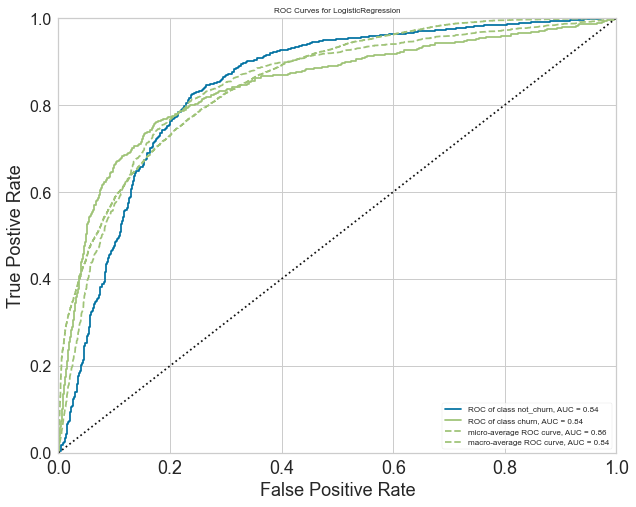

In [143]:
# roc - auc curve
plot_roc_auc(grid_model_rfe_lr2.best_estimator_, X_test_new2, y_test)

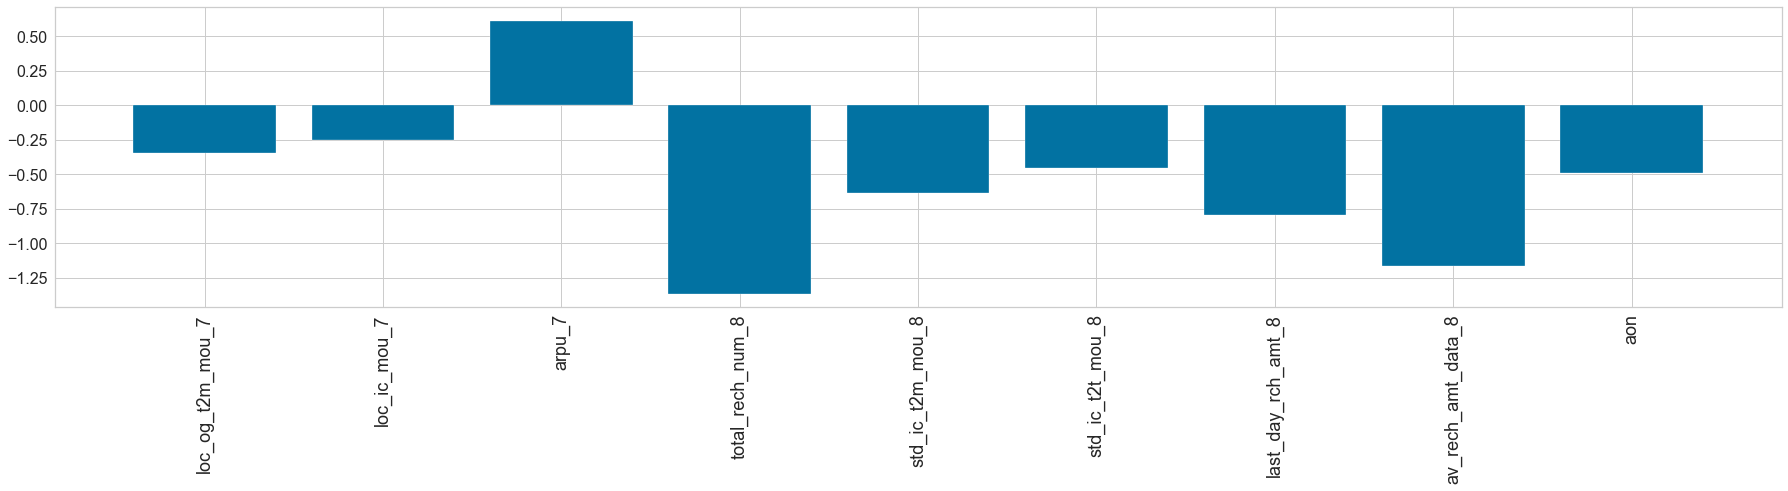

features  importances
0    loc_og_t2m_mou_7    -0.343005
1        loc_ic_mou_7    -0.247571
2              arpu_7     0.613541
3    total_rech_num_8    -1.362406
4    std_ic_t2m_mou_8    -0.637006
5    std_ic_t2t_mou_8    -0.454367
6  last_day_rch_amt_8    -0.792205
7  av_rech_amt_data_8    -1.160857
8                 aon    -0.489306

In [144]:
# feature importance plot
get_importance(selected_features2, grid_model_rfe_lr2.best_estimator_.coef_[0])

### Training a decision tree with RFE data

In [145]:
# initialize decision tree model
dt_model = DecisionTreeClassifier()

# decision tree hyperparameters
dt_params = {'max_depth': [2, 3, 4],
             'min_samples_split': [2, 4, 6],
             'min_samples_leaf': [2, 3, 4]}

# GridsearchCV for hyper-parameter tuning
# StratifiedKFold for model cross-validation
grid_model_dt = GridSearchCV(estimator=dt_model, param_grid=dt_params, cv=StratifiedKFold(), verbose=3, n_jobs=2)

In [146]:
# fit model
grid_model_dt.fit(X_train_new, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   17.7s
[Parallel(n_jobs=2)]: Done 135 out of 135 | elapsed:   19.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'max_depth': [2, 3, 4], 'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 4, 6]},
             verbose=3)

In [147]:
# best parameters after tuning
grid_model_dt.best_params_

{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [148]:
# test data
y_pred_rfe_dt = grid_model_dt.predict(X_test_new)
y_pred_prob_rfe_dt = grid_model_dt.predict_proba(X_test_new)

In [149]:
show_model_summary(y_test, y_pred_rfe_dt, y_pred_prob_rfe_dt)

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      8266
           1       0.29      0.77      0.42       735

    accuracy                           0.82      9001
   macro avg       0.63      0.80      0.66      9001
weighted avg       0.92      0.82      0.86      9001

Confusion Matrix: 
[[6846 1420]
 [ 167  568]]
Logloss:  0.42209304641467355
R-Squared -1.3511749630895187
auc:  0.8641409527759809


#### Decision tree model on new features (Results) 
- Accuracy = 82%, AUC Score = 86.4% , Churn Recall = 77% ,Logloss = 0.42

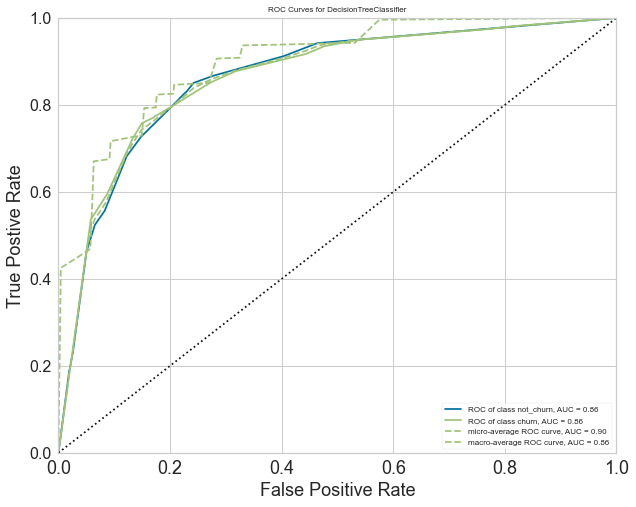

In [150]:
# plot roc-auc curve
plot_roc_auc(grid_model_dt.best_estimator_, X_test_new, y_test)

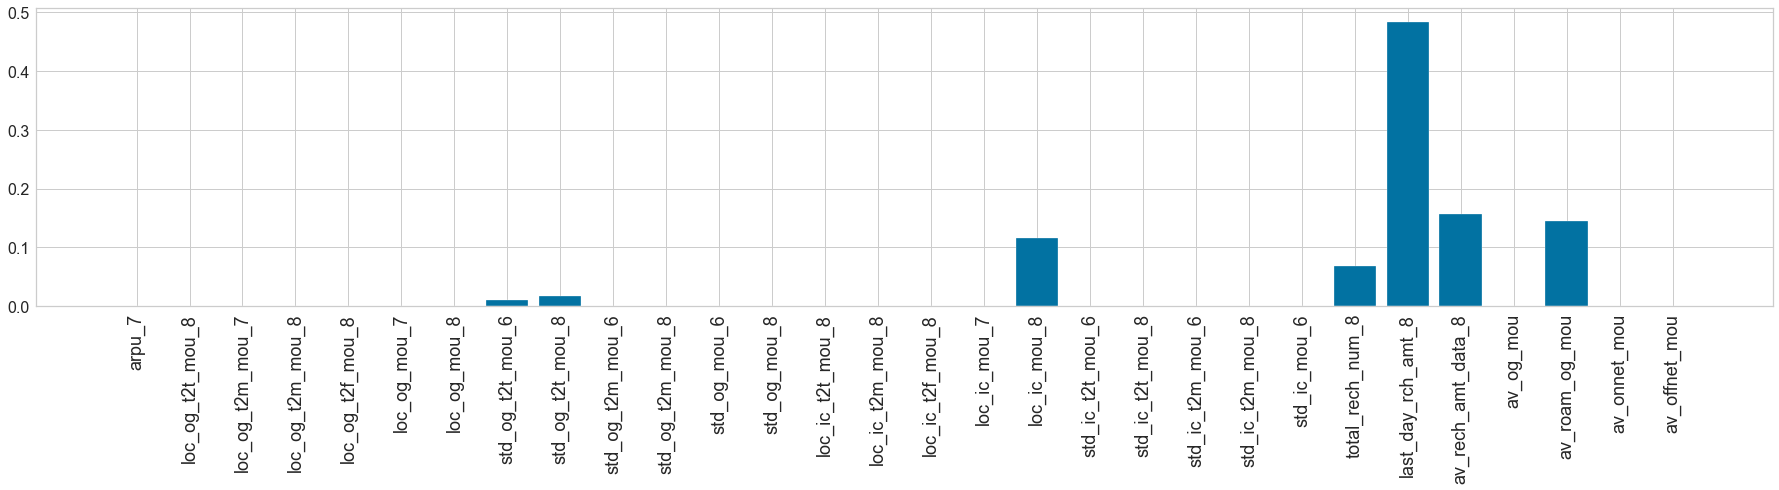

features  importances
0               arpu_7     0.000000
1     loc_og_t2t_mou_8     0.000000
2     loc_og_t2m_mou_7     0.000000
3     loc_og_t2m_mou_8     0.000000
4     loc_og_t2f_mou_8     0.000000
5         loc_og_mou_7     0.000000
6         loc_og_mou_8     0.000000
7     std_og_t2t_mou_6     0.011008
8     std_og_t2t_mou_8     0.017994
9     std_og_t2m_mou_6     0.000000
10    std_og_t2m_mou_8     0.000000
11        std_og_mou_6     0.000000
12        std_og_mou_8     0.000000
13    loc_ic_t2t_mou_8     0.000000
14    loc_ic_t2m_mou_8     0.000000
15    loc_ic_t2f_mou_8     0.000000
16        loc_ic_mou_7     0.000000
17        loc_ic_mou_8     0.115874
18    std_ic_t2t_mou_6     0.000000
19    std_ic_t2t_mou_8     0.000000
20    std_ic_t2m_mou_6     0.000000
21    std_ic_t2m_mou_8     0.000000
22        std_ic_mou_6     0.000000
23    total_rech_num_8     0.069161
24  last_day_rch_amt_8     0.483638
25  av_rech_amt_data_8     0.156678
26           av_og_mou     0.000000
27      av_roam_og_mou     0.145647
28        av_onnet_mou     0.000000
29       av_offnet_mou     0.000000

In [151]:
# plot feature importances
get_importance(selected_features, grid_model_dt.best_estimator_.feature_importances_)

### Random Forest Model on RFE features

In [152]:
# GridSearchCV for hyper-parameter tuning
# StratifiedKFold for model cross-validation
grid_model_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, cv=StratifiedKFold(), verbose=3, n_jobs=2)

In [153]:
# fit the data
grid_model_rf.fit(X_train_new, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   52.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 270 out of 270 | elapsed: 11.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'max_depth': [2, 3, 4], 'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200]},
             verbose=3)

In [154]:
# best params after tuning
grid_model_rf.best_params_

{'max_depth': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 200}

In [155]:
# test data
y_pred_rf = grid_model_rf.predict(X_test_new)
y_pred_prob_rf = grid_model_rf.predict_proba(X_test_new)

In [156]:
show_model_summary(y_test, y_pred_rf, y_pred_prob_rf)

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      8266
           1       0.33      0.81      0.47       735

    accuracy                           0.85      9001
   macro avg       0.66      0.83      0.69      9001
weighted avg       0.93      0.85      0.88      9001

Confusion Matrix: 
[[7067 1199]
 [ 140  595]]
Logloss:  0.39197205631417725
R-Squared -0.9837575775531604
auc:  0.9024271213445457


#### Random Forest on new features (Results)
- Accuracy = 85%, AUC Score = 90.2% , Churn Recall = 81% , logloss = 0.39

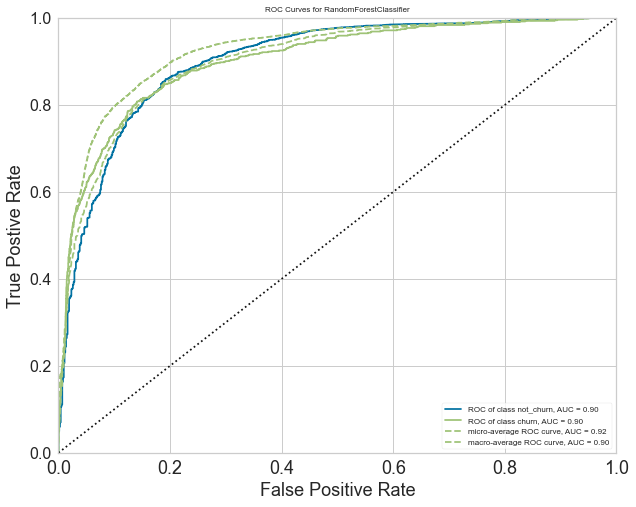

In [157]:
plot_roc_auc(grid_model_rf.best_estimator_, X_test_new, y_test)

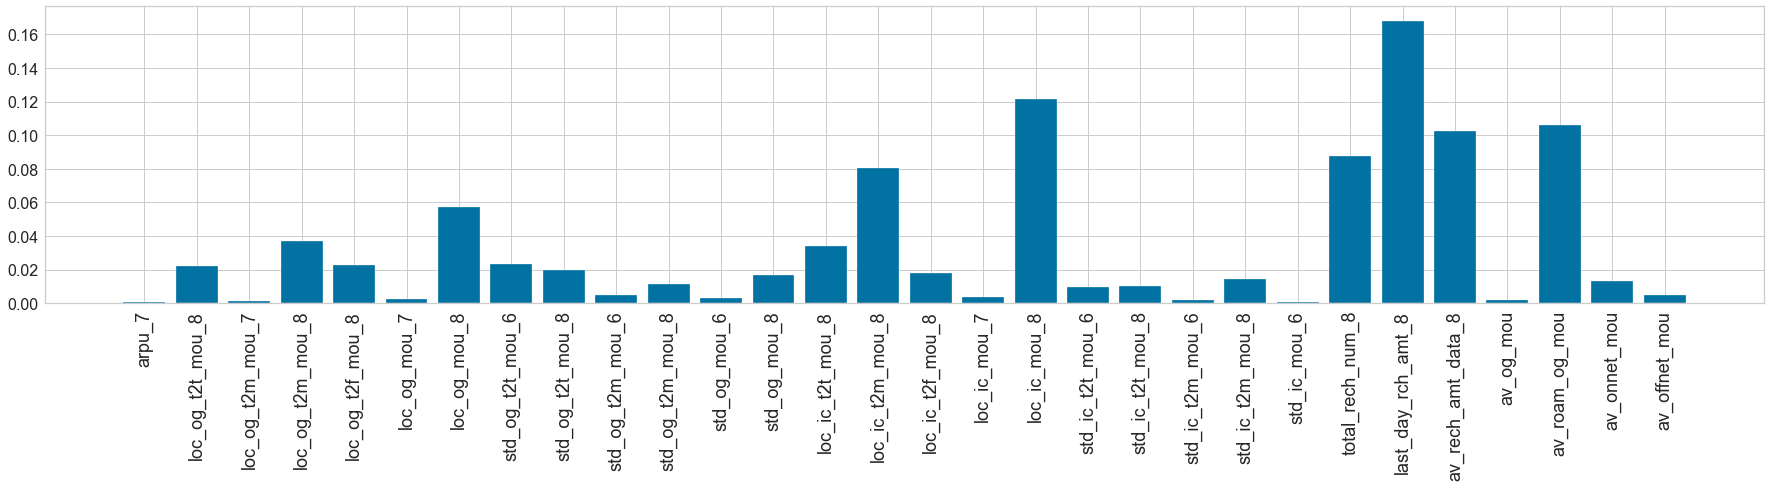

features  importances
0               arpu_7     0.000548
1     loc_og_t2t_mou_8     0.021894
2     loc_og_t2m_mou_7     0.001468
3     loc_og_t2m_mou_8     0.036822
4     loc_og_t2f_mou_8     0.022660
5         loc_og_mou_7     0.002614
6         loc_og_mou_8     0.056987
7     std_og_t2t_mou_6     0.023079
8     std_og_t2t_mou_8     0.019507
9     std_og_t2m_mou_6     0.004606
10    std_og_t2m_mou_8     0.011592
11        std_og_mou_6     0.003044
12        std_og_mou_8     0.016691
13    loc_ic_t2t_mou_8     0.033987
14    loc_ic_t2m_mou_8     0.080403
15    loc_ic_t2f_mou_8     0.017790
16        loc_ic_mou_7     0.003638
17        loc_ic_mou_8     0.121711
18    std_ic_t2t_mou_6     0.009761
19    std_ic_t2t_mou_8     0.010113
20    std_ic_t2m_mou_6     0.001913
21    std_ic_t2m_mou_8     0.014283
22        std_ic_mou_6     0.000548
23    total_rech_num_8     0.087550
24  last_day_rch_amt_8     0.168236
25  av_rech_amt_data_8     0.102802
26           av_og_mou     0.001594
27      av_roam_og_mou     0.106022
28        av_onnet_mou     0.013176
29       av_offnet_mou     0.004959

In [158]:
get_importance(selected_features, grid_model_rf.best_estimator_.feature_importances_)

Therefore using RFE the best model which we got is the <b>Random Forest</b> Model with 81% Churn Recall value

## Conclusion

Top 5 Important Features from the Random Forest model are

- Last Day recharge amount for month 8
- Local Incoming minutes over call for month 8
- Average recharge amount data for month 8
- Average roaming for outgoing minutes over call
- Local T2M incoming minutes over call for month 8 

And many more features which mostly related to month 8 i.e the Active Month

## Recommendations

According to the obeservations from the modelling exercise the best ways to manage customer churn for High Value Prepaid customers are

- Main Focus should be on the 'active' month features like
    - Local calls 
    - STD calls  
    - Incoming calls
    - Outgoing calls
    - Operator T to T, i.e. within same operator (mobile to mobile)
    - Operator T to other operator mobile
    - Average revenue per user
    - Roaming calls etc.
    
Should closely monitor if there is a decrease in MOU or Recharge amount compared to the previous month of these features  

- Based on these features the Telecom Operator should start providing schemes which are better than the operator for the high value customers.
- Should send CRM notifications/email/messages to such customers in order to retain them.
- Should introduce offers to orders or Plans which these customers use most frequently.
- Should build trust among the customers by making hard to refuse for these consumers.